# Transform marker data
Scaling to suitable levels, arcsinh transformation and scaling to [0,1] of (pre-filtered) marker abundance levels from a MIBI cell table.

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
from plotnine import *
from tqdm import tqdm

In [2]:
# Where should the output be saved?
preprocess_dir = "./ProcessAll/preprocessing_figures/"

In [3]:
# Read the cell size normalized table
cell_table = pd.read_csv("/data/cell_table.csv", index_col=0)
# Remove ".tiff" from the column names for convenience
cell_table.columns = [x.split(".tiff")[0] for x in cell_table.columns]
cell_table.columns

Index(['chan_39', 'chan_48', 'Fe', 'chan_69', 'chan_71', 'SMA', 'CA9',
       'nuclei', 'Noodle', 'CD98', 'CytC', 'CD4', 'MSH2', 'FoxP3', 'MCT1',
       'PDL1', 'CD31', 'PD1', 'ASCT2', 'CD7', 'LDH', 'CD163', 'STING1', 'DCN',
       'CD68', 'GS', 'CD8', 'CD3e', 'GLS', 'MPO', 'ATP5A', 'CS', 'CD20',
       'PKM2', 'GLUT1', 'HLADRa', 'CD14', 'CD45', 'PanCK', 'MSH6', 'ARG1',
       'CPT1A', 'Vimentin', 'Ki67', 'membrane', 'Au', 'nuclei_clahe',
       'membrane_clahe', 'GLUT1_clahe', 'ASCT2_clahe', 'centroid-0',
       'centroid-1', 'eccentricity', 'perimeter', 'convex_area', 'area',
       'axis_major_length', 'axis_minor_length', 'label', 'fov', 'url',
       'AreaShape_Center_X', 'AreaShape_Center_X_1', 'AreaShape_Center_Y',
       'AreaShape_Center_Y_1', 'NuclearIntensity'],
      dtype='object')

In [4]:
# Define channels to transform and to exclude
channels = ['ARG1', 'ASCT2', 'ATP5A', 'CA9', 'CD14','CD163', 'STING1',
       'CD20', 'CD3e', 'CD31', 'CD4', 'CD45', 'CD68', 'CD7', 'CD8',
       'CD98', 'CPT1A', 'CS', 'DCN', 'GS', 'MPO', 'MSH2', 'MSH6',
       'CytC', 'FoxP3', 'GLS', 'GLUT1', 'HLADRa', 'Ki67',
       'LDH', 'MCT1', 'PDL1', 'PD1', 'PKM2', 'PanCK', 'SMA', 'Vimentin']
background = ['chan_39', 'chan_48', 'chan_69', 'chan_71', 'Au', 'Noodle', 'Fe', 
              'nuclei_clahe', 'membrane_clahe', 'GLUT1_clahe', 'ASCT2_clahe', 'url',
       'AreaShape_Center_X', 'AreaShape_Center_X_1', 'AreaShape_Center_Y',
       'AreaShape_Center_Y_1', 'NuclearIntensity']

In [5]:
# Following columns will be kept but not transformed:
[x for x in cell_table.columns if not x in background and not x in channels]

['nuclei',
 'membrane',
 'centroid-0',
 'centroid-1',
 'eccentricity',
 'perimeter',
 'convex_area',
 'area',
 'axis_major_length',
 'axis_minor_length',
 'label',
 'fov']

In [6]:
# drop background channels - axis=1 specifies that you want to drop columns (as opposed to rows)
cell_table = cell_table.drop(background, axis = 1)

In [7]:
# Display the statistics of the channels
cell_table[channels].describe()

ARG1          ASCT2          ATP5A            CA9  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.000487       0.003236       0.007947       0.006318   
std         0.000714       0.004967       0.009801       0.010461   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000123       0.000519       0.001823       0.001645   
50%         0.000275       0.001632       0.004877       0.003543   
75%         0.000564       0.004008       0.010378       0.007064   
max         0.035111       0.214050       0.217841       0.696736   

                CD14          CD163         STING1           CD20  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.001040       0.000174       0.004044       0.000556   
std         0.002085       0.000841       0.005080       0.004519   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000200       0.000002       0.000976       0.000014   
50%         0.000387       0.000019       0.002430       0.000081   
75%         0.000927       0.000070       0.005199       0.000240   
max         0.133880       0.096254       0.191422       0.268033   

                CD3e           CD31  ...         HLADRa           Ki67  \
count  602543.000000  602543.000000  ...  602543.000000  602543.000000   
mean        0.000411       0.002187  ...       0.000185       0.001337   
std         0.001397       0.006397  ...       0.000739       0.003112   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000032       0.000200  ...       0.000030       0.000154   
50%         0.000083       0.000623  ...       0.000065       0.000379   
75%         0.000183       0.001636  ...       0.000129       0.000963   
max         0.097058       0.282231  ...       0.131453       0.115542   

                 LDH           MCT1           PDL1            PD1  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.001384       0.002774       0.000174       0.000085   
std         0.001747       0.005247       0.000444       0.000256   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000288       0.000170       0.000029       0.000006   
50%         0.000819       0.000883       0.000080       0.000031   
75%         0.001829       0.003175       0.000178       0.000089   
max         0.080142       0.294500       0.043073       0.027623   

                PKM2          PanCK            SMA       Vimentin  
count  602543.000000  602543.000000  602543.000000  602543.000000  
mean        0.005797       0.005665       0.018206       0.010144  
std         0.007354       0.009125       0.048972       0.021335  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.001487       0.000696       0.000000       0.000259  
50%         0.003481       0.002554       0.000037       0.000970  
75%         0.007281       0.007016       0.009134       0.011387  
max         0.193403       0.379362       1.109179       1.136200  

[8 rows x 37 columns]

## 99.9% percentile scaling to 10

In [8]:
# Create output directory if it doesn't exist
if not os.path.exists(preprocess_dir):
    os.makedirs(preprocess_dir)

raw_dir = os.path.join(preprocess_dir, "raw")
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

  0%|          | 0/37 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_ARG1.png


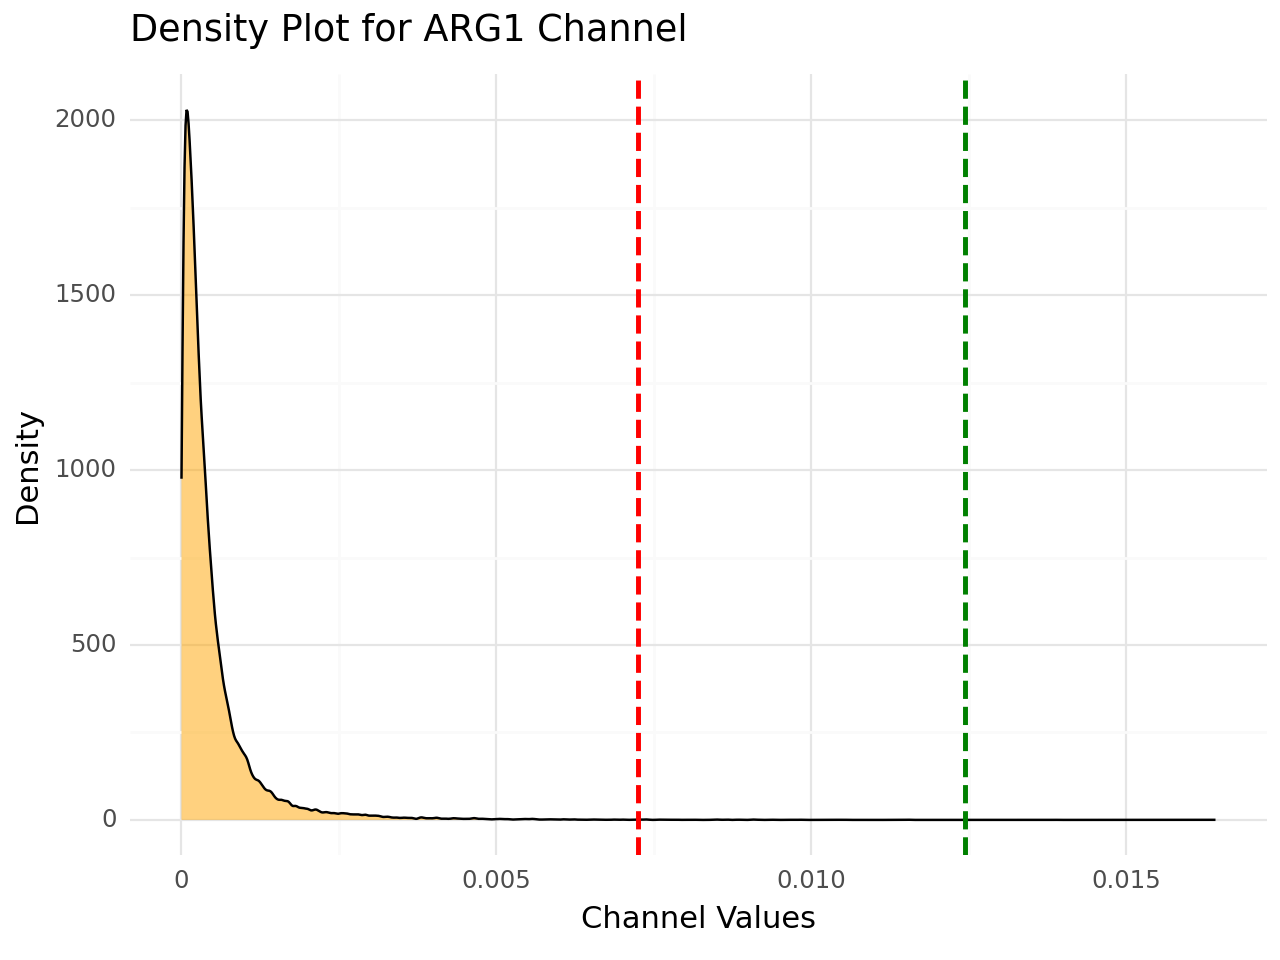

  3%|▎         | 1/37 [00:02<01:17,  2.16s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_ASCT2.png


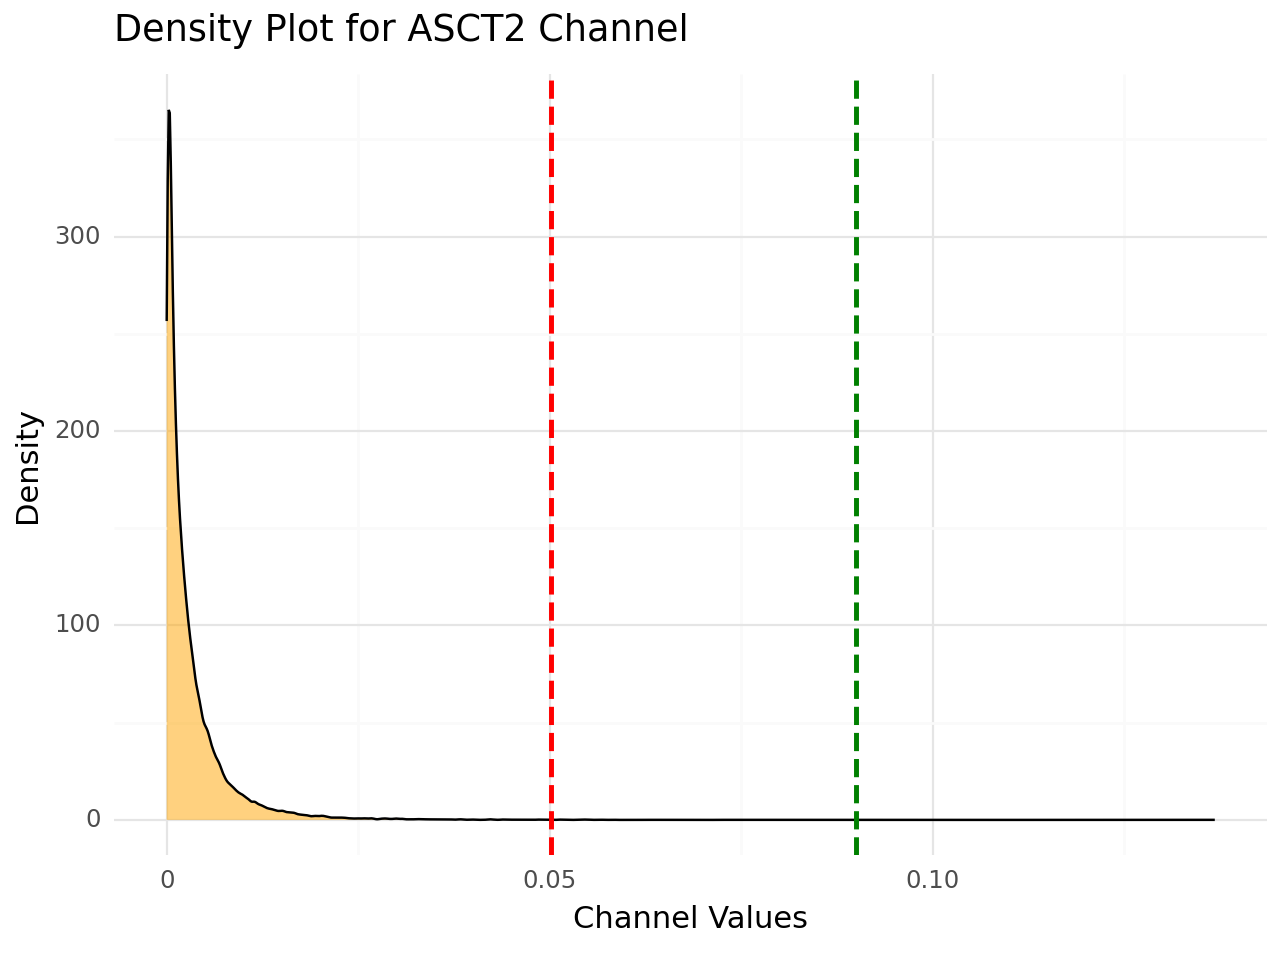

  5%|▌         | 2/37 [00:03<01:06,  1.89s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_ATP5A.png


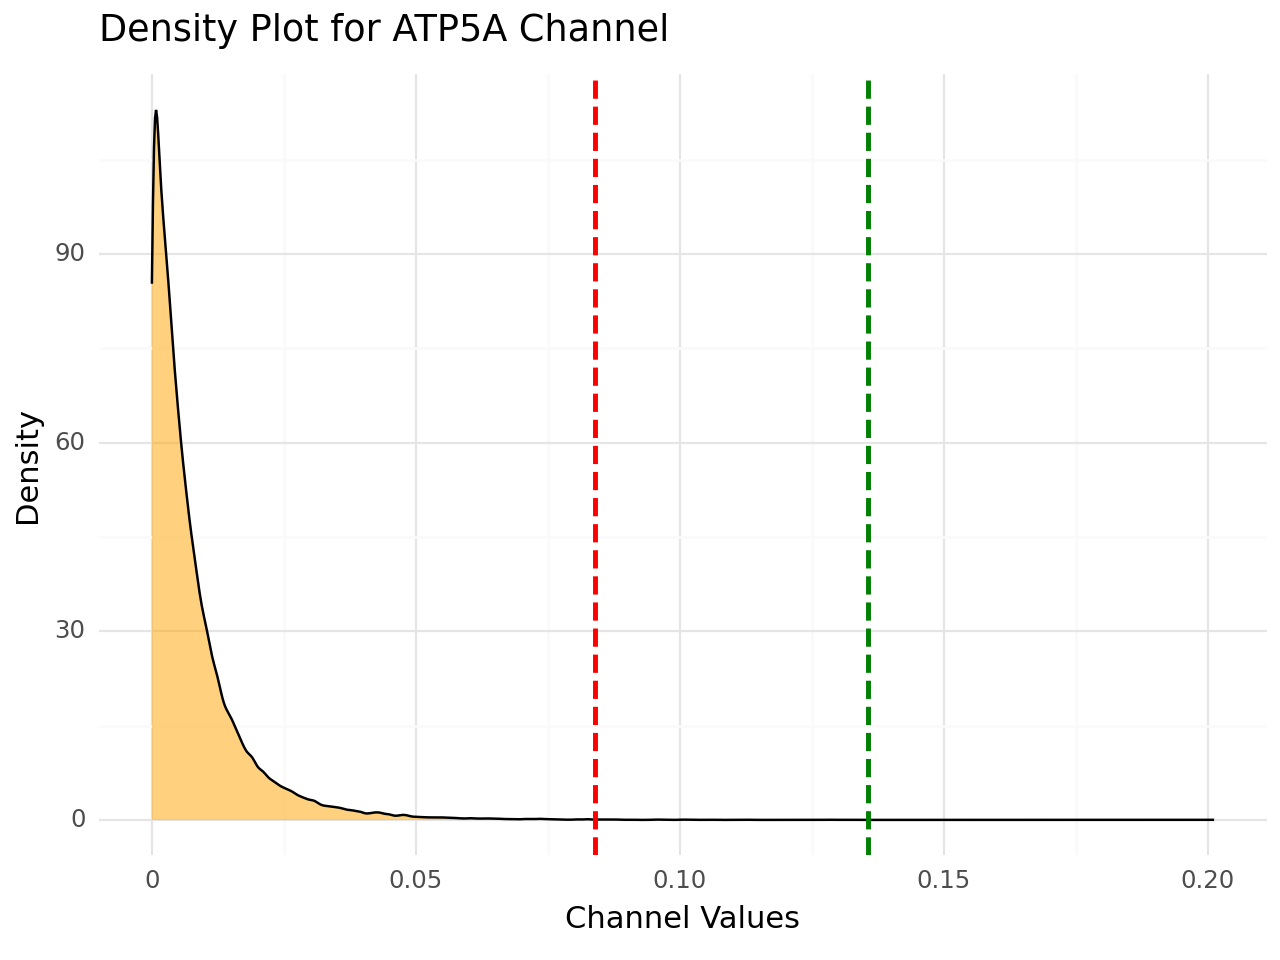

  8%|▊         | 3/37 [00:05<01:01,  1.80s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CA9.png


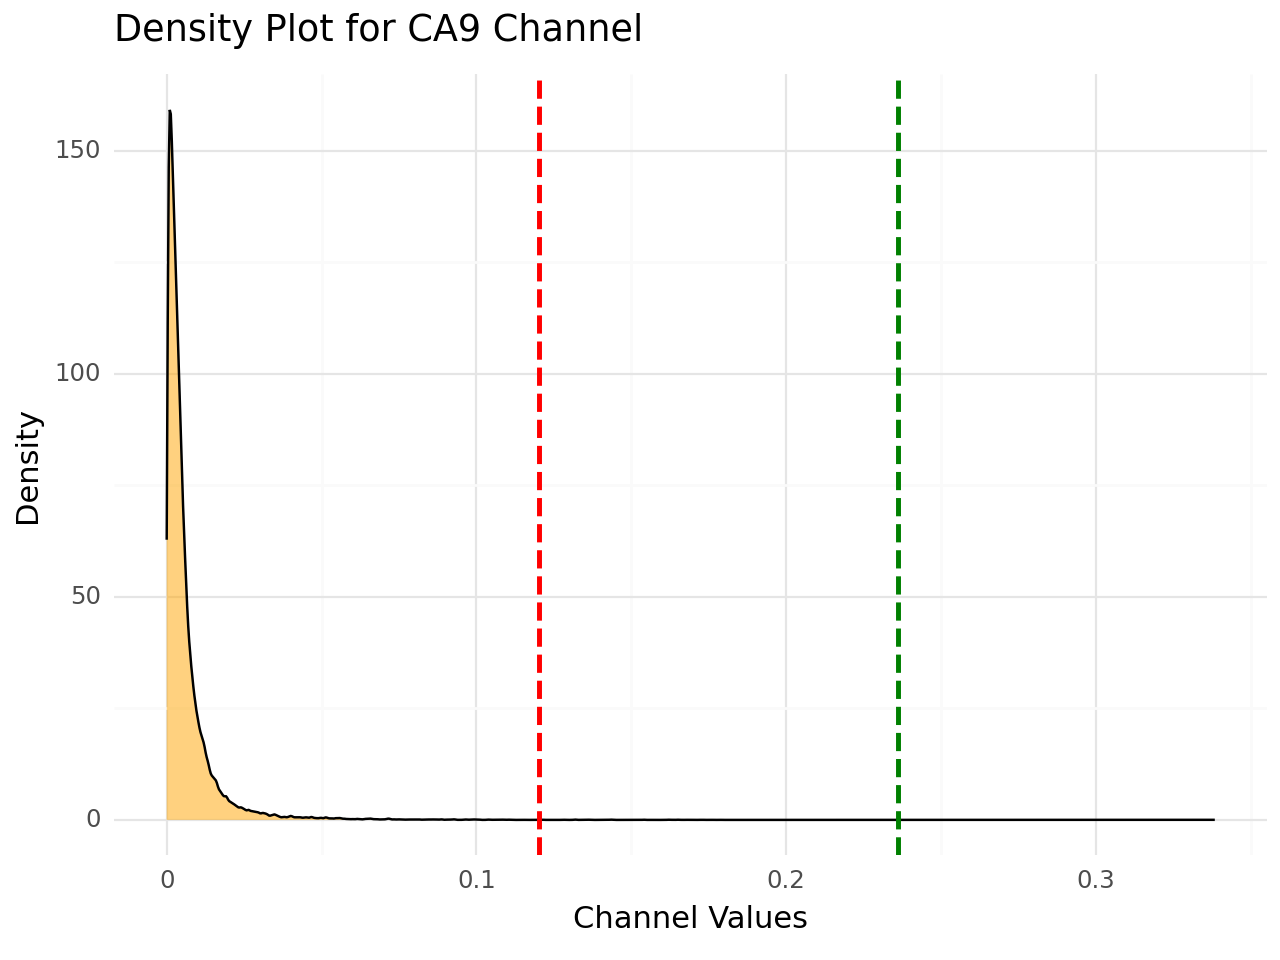

 11%|█         | 4/37 [00:07<00:58,  1.77s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD14.png


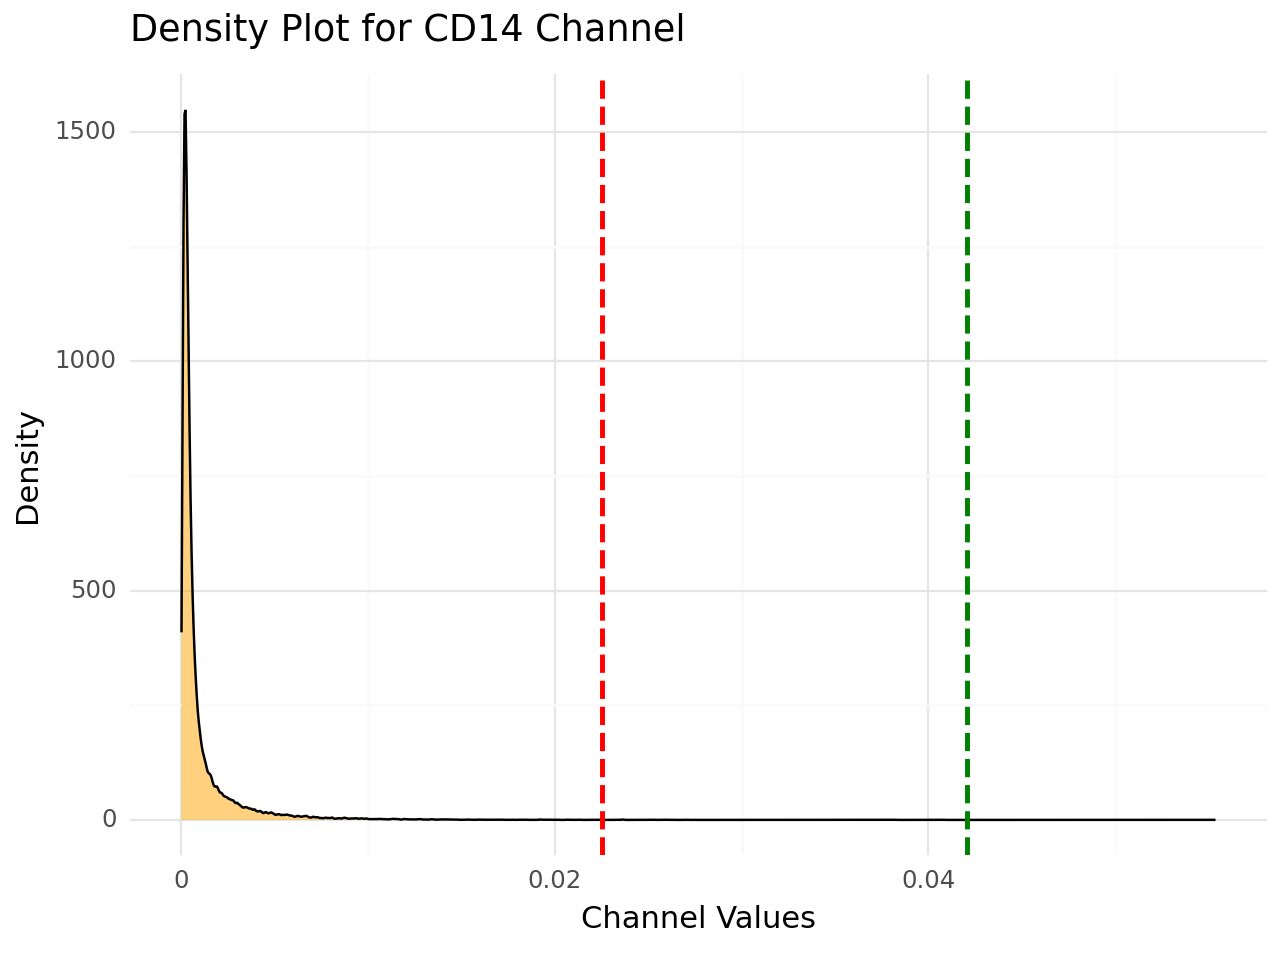

 14%|█▎        | 5/37 [00:08<00:55,  1.74s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD163.png


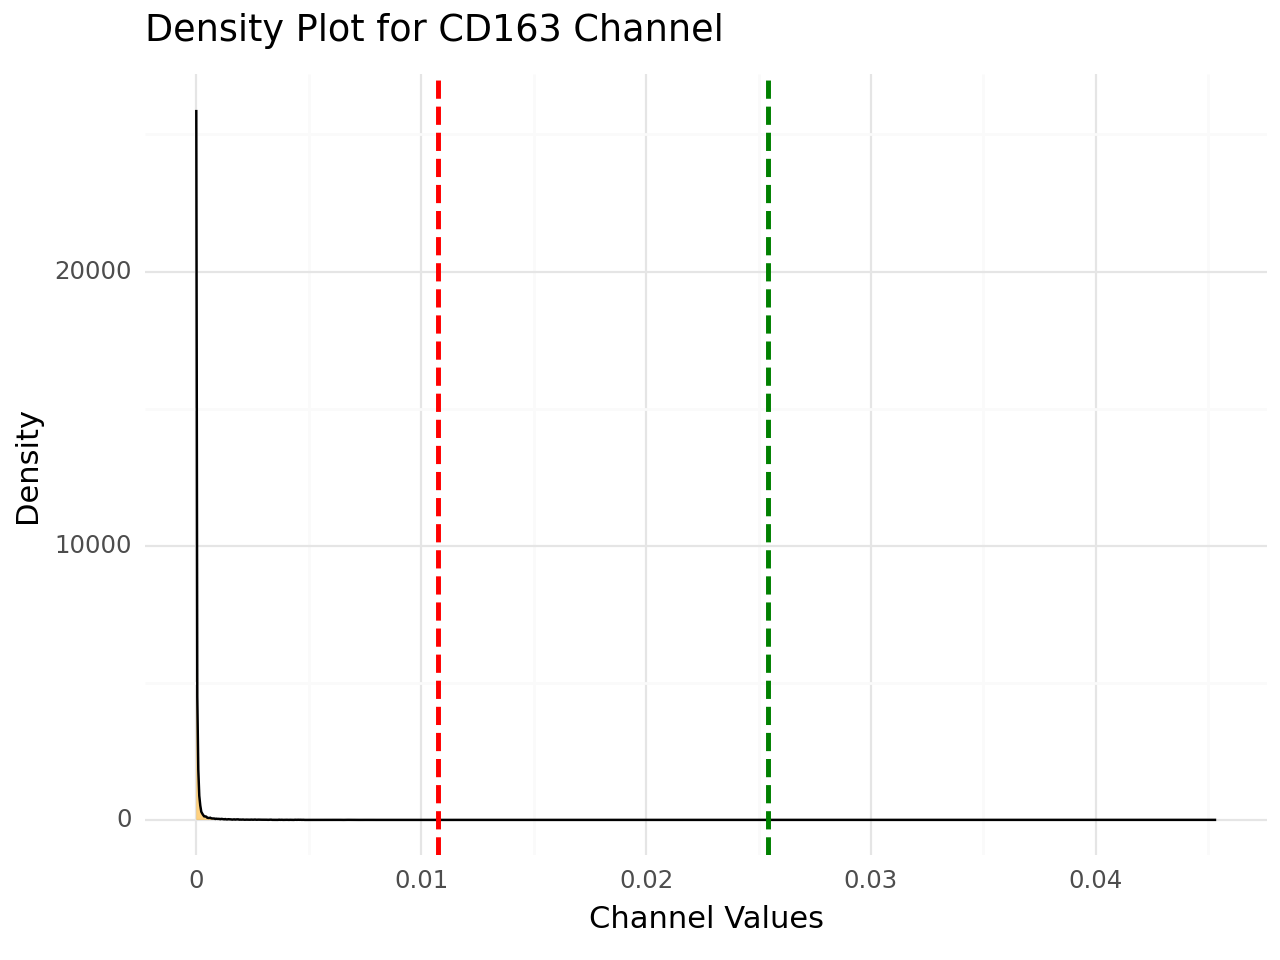

 16%|█▌        | 6/37 [00:10<00:53,  1.73s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_STING1.png


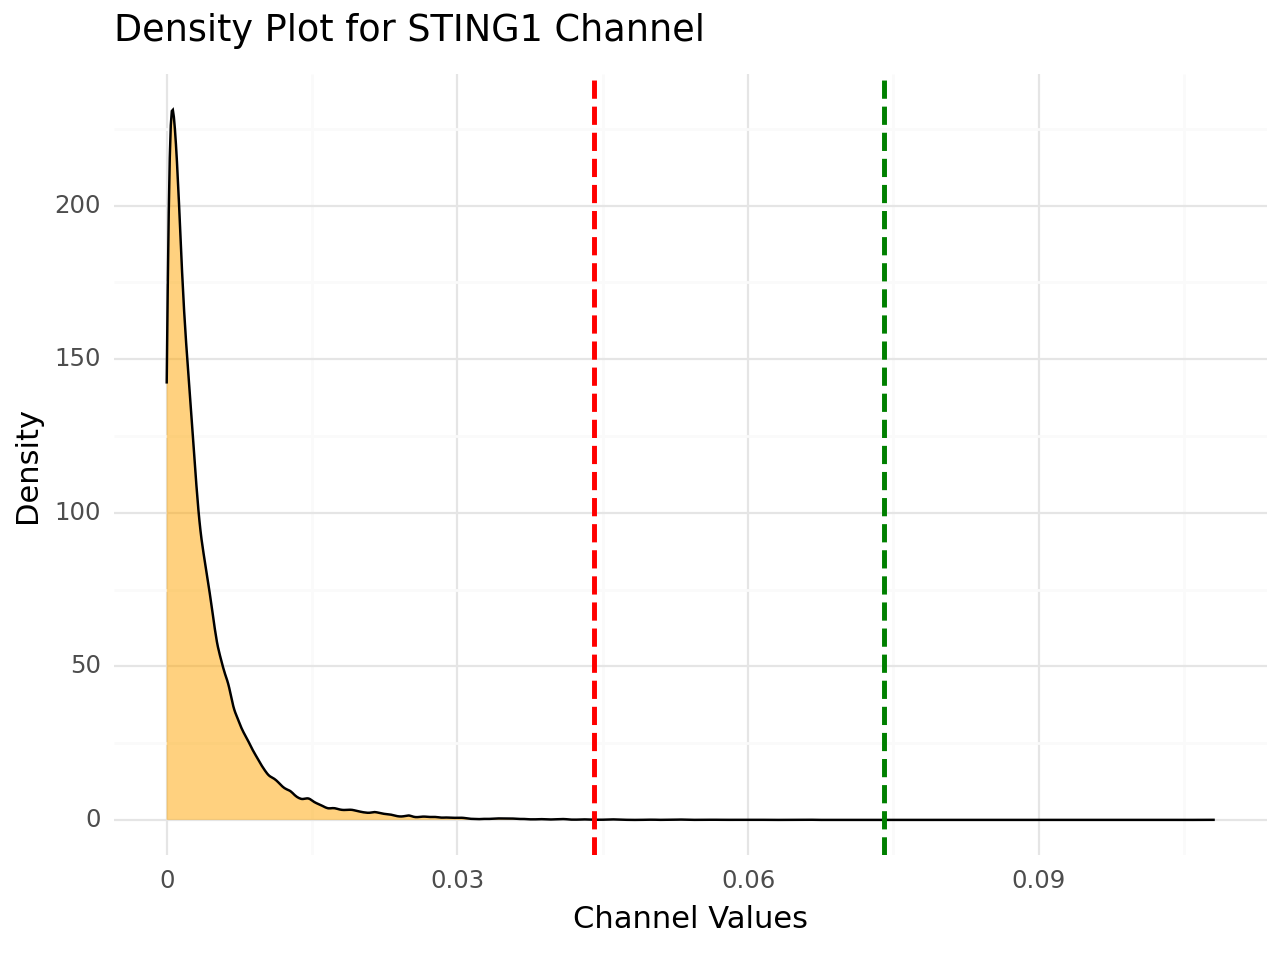

 19%|█▉        | 7/37 [00:12<00:51,  1.72s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD20.png


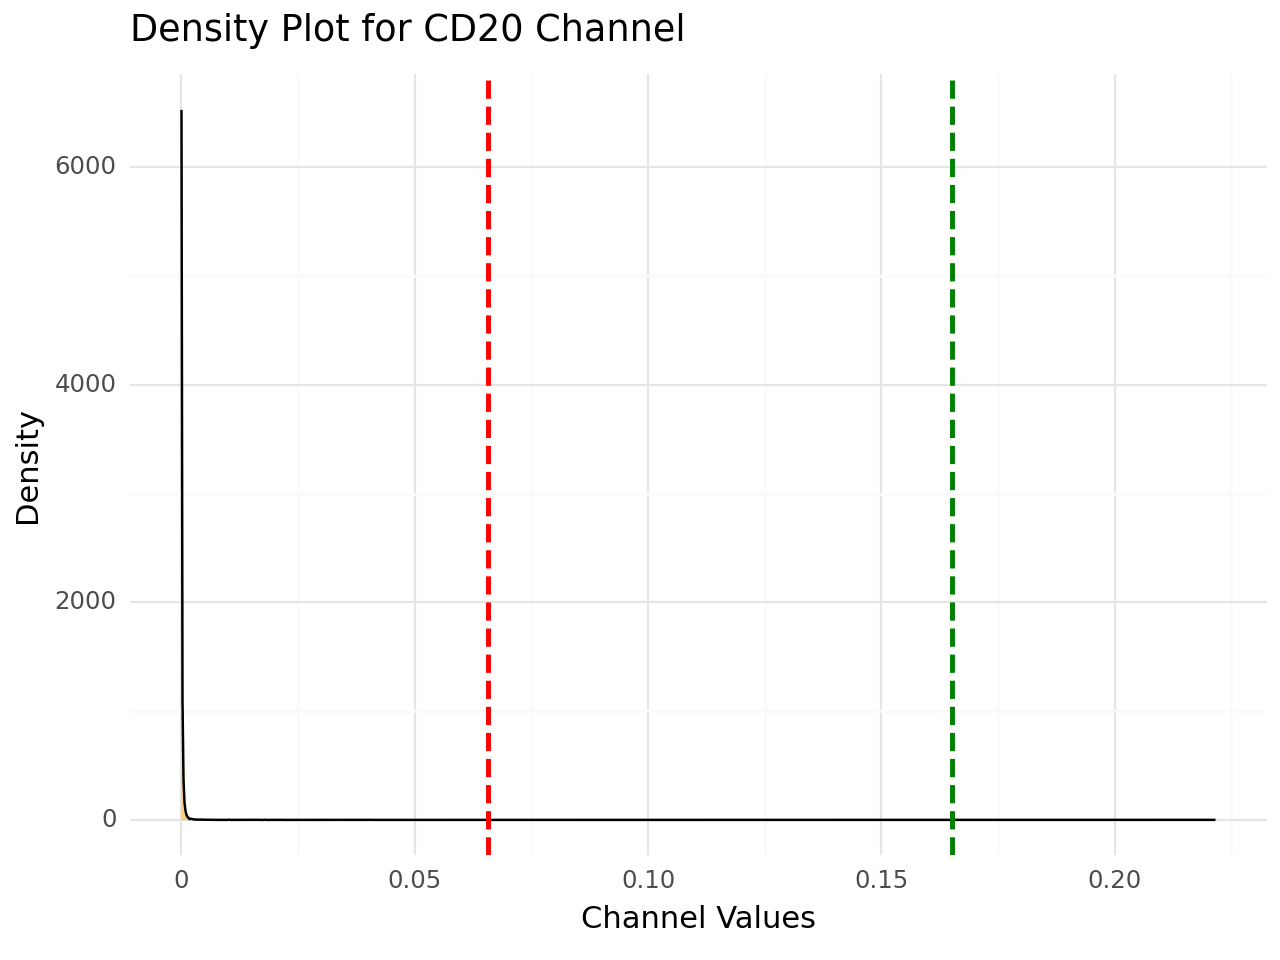

 22%|██▏       | 8/37 [00:14<00:49,  1.72s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD3e.png


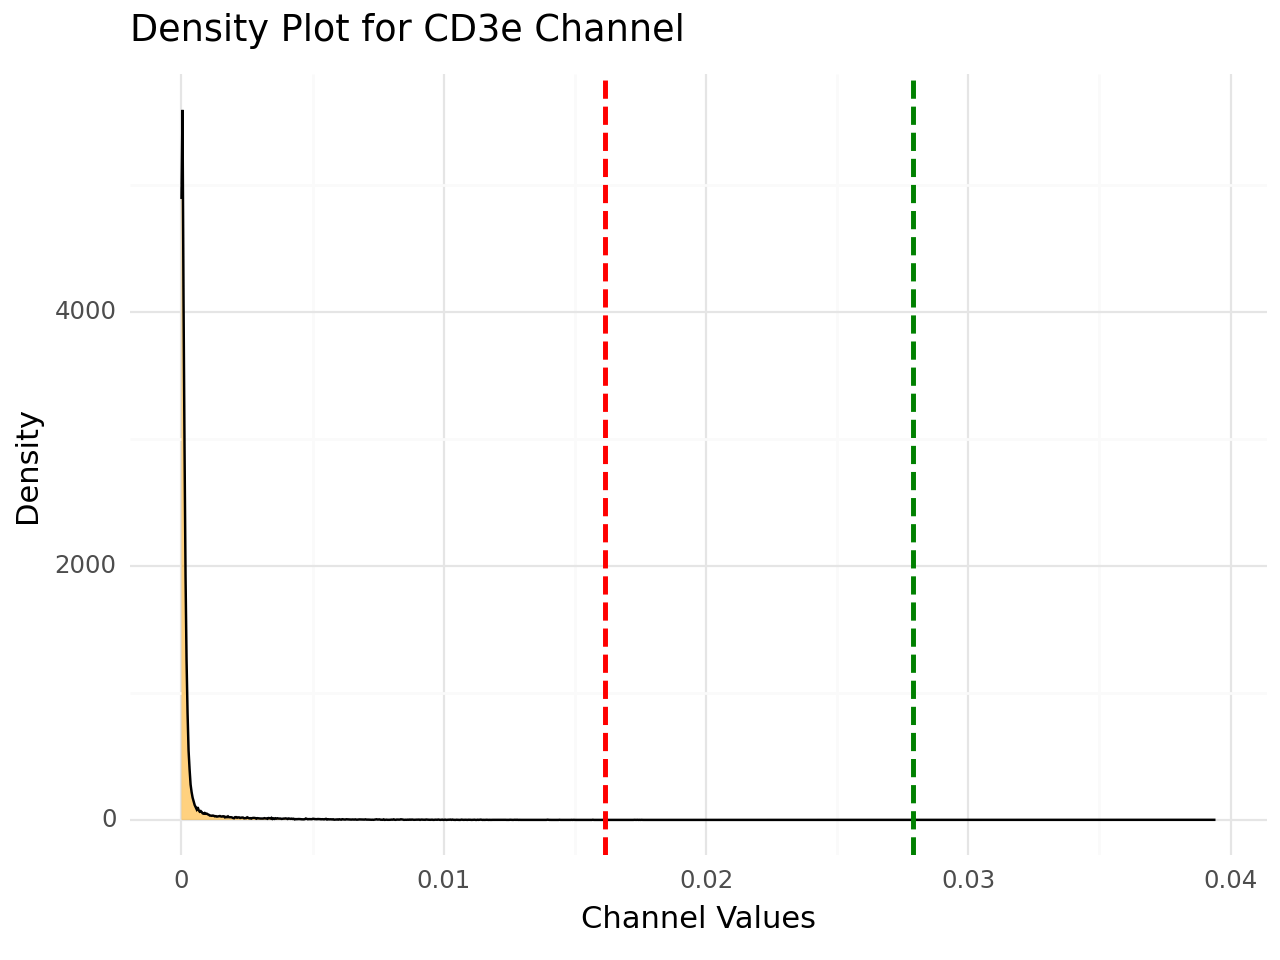

 24%|██▍       | 9/37 [00:15<00:48,  1.72s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD31.png


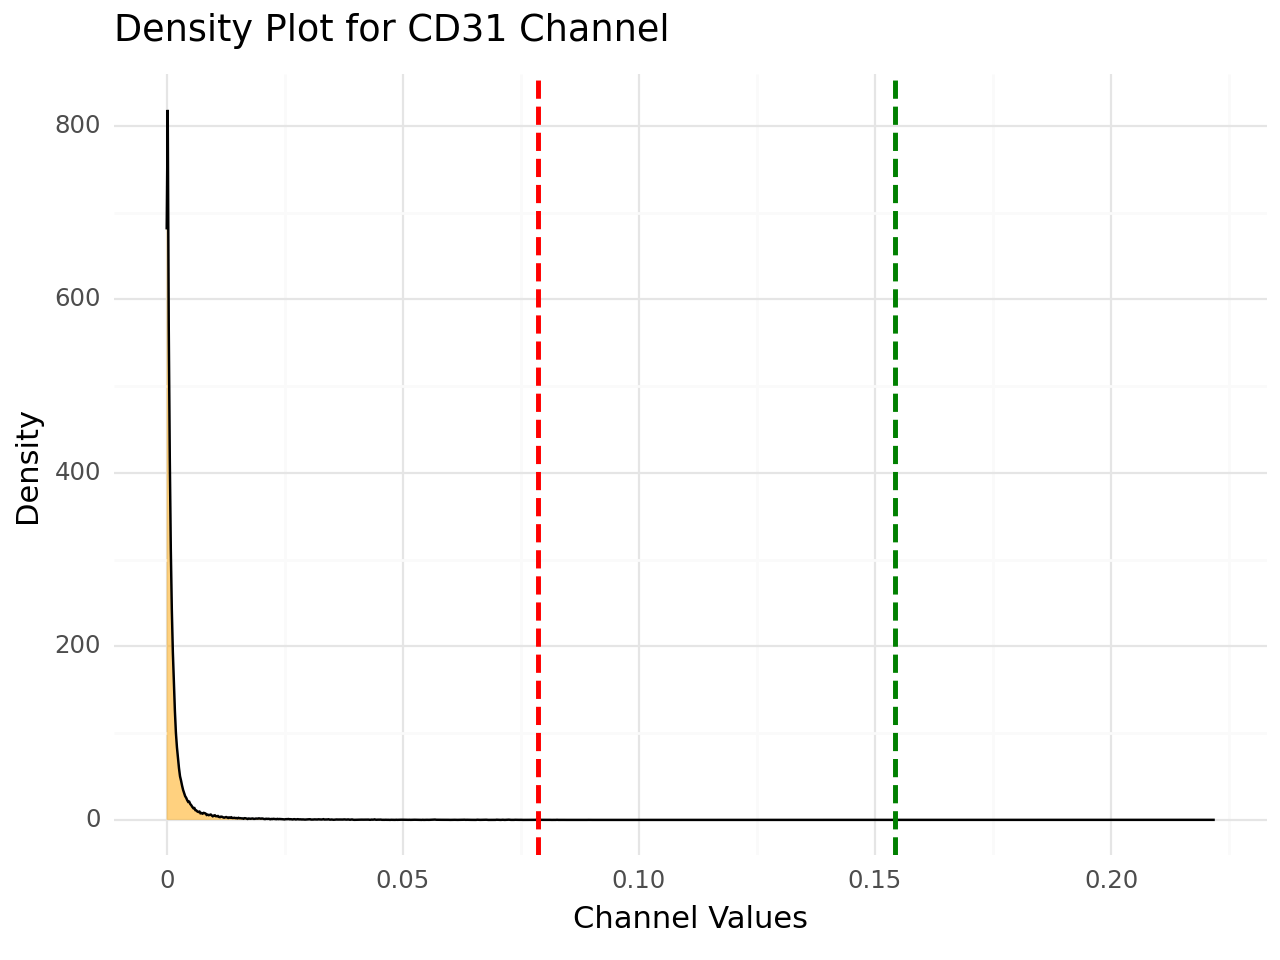

 27%|██▋       | 10/37 [00:17<00:46,  1.72s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD4.png


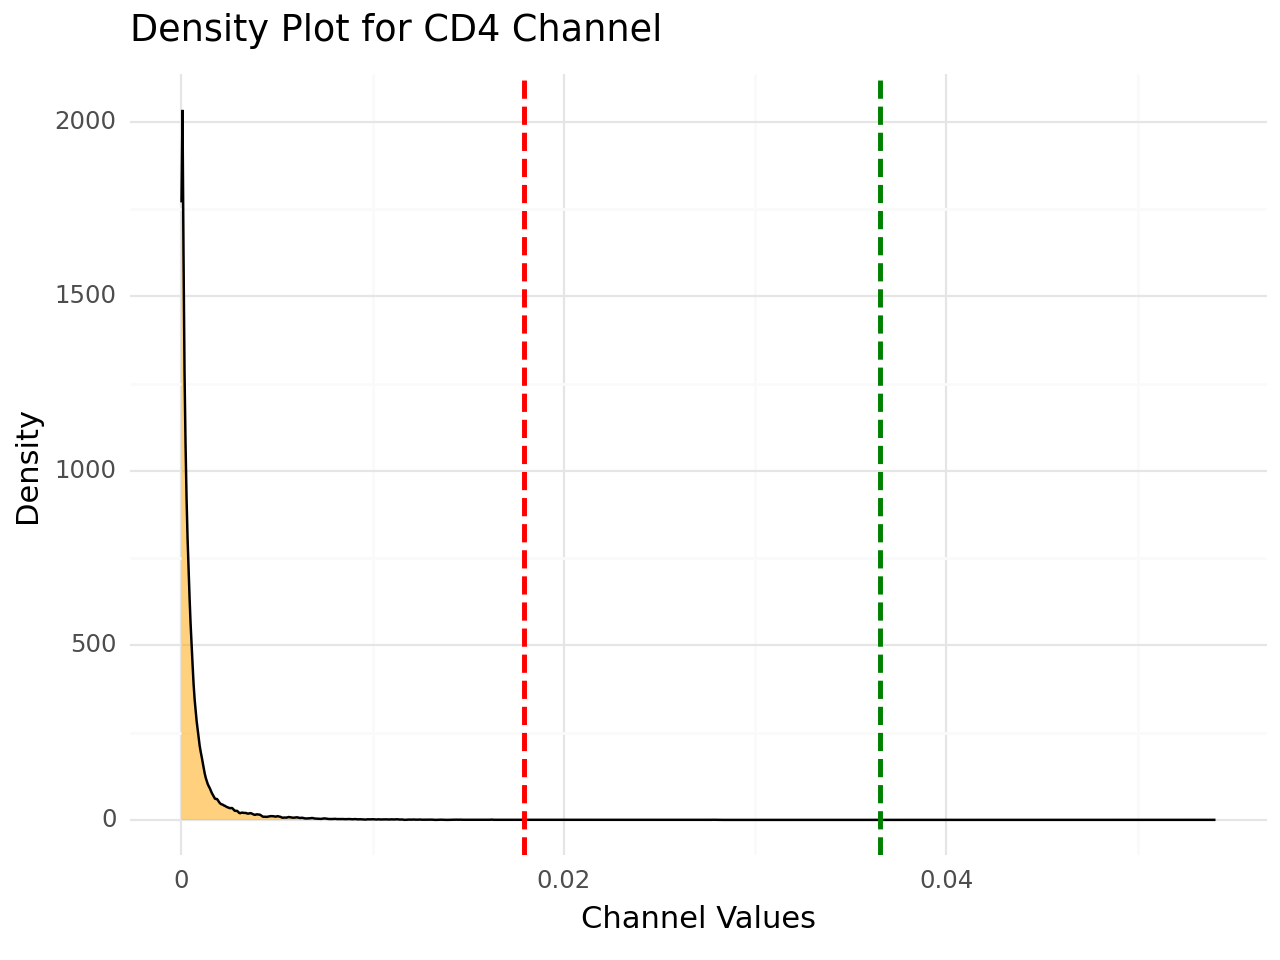

 30%|██▉       | 11/37 [00:19<00:45,  1.73s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD45.png


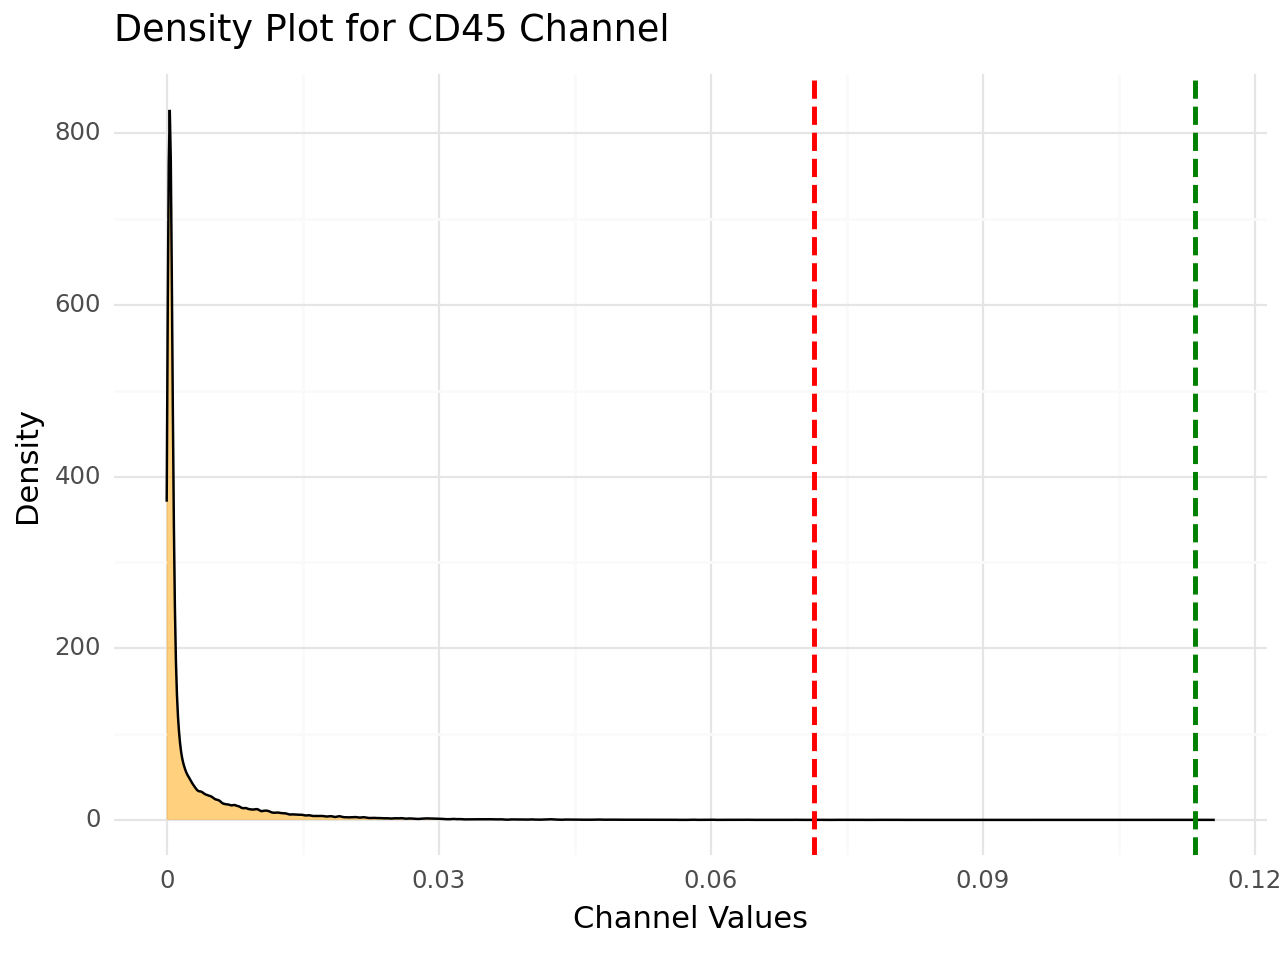

 32%|███▏      | 12/37 [00:21<00:43,  1.73s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD68.png


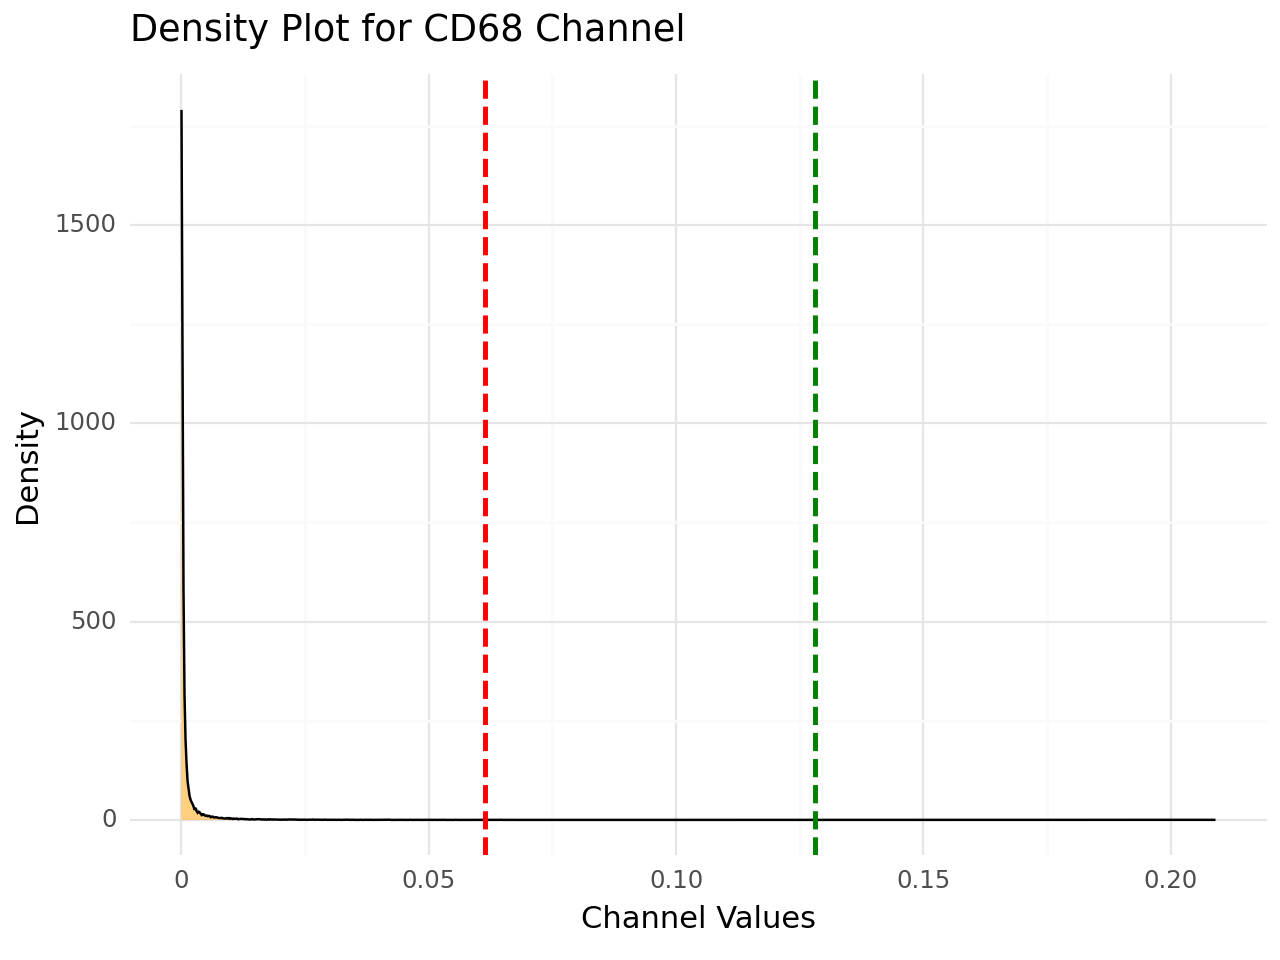

 35%|███▌      | 13/37 [00:22<00:42,  1.76s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD7.png


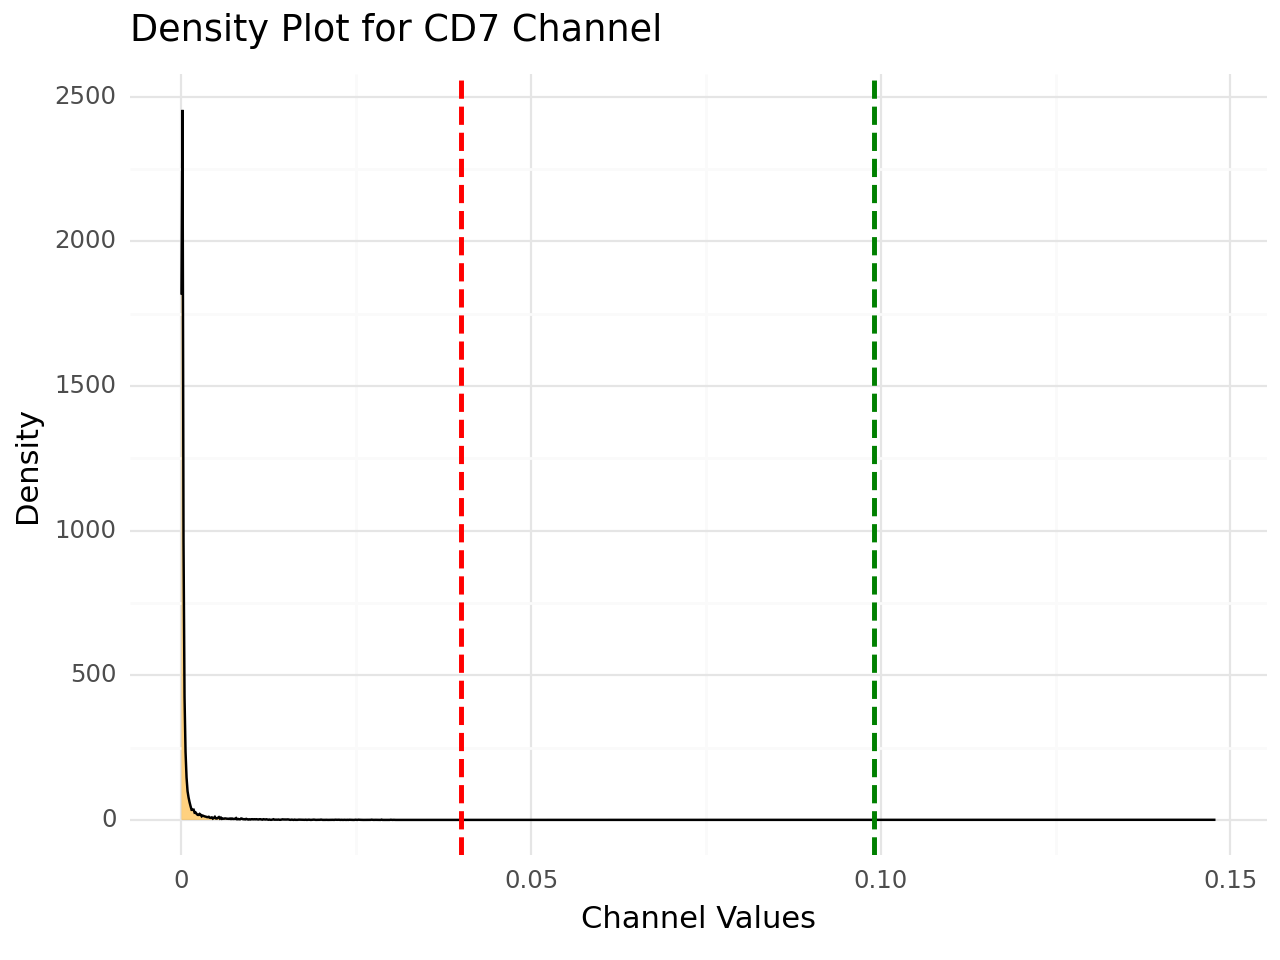

 38%|███▊      | 14/37 [00:24<00:40,  1.78s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD8.png


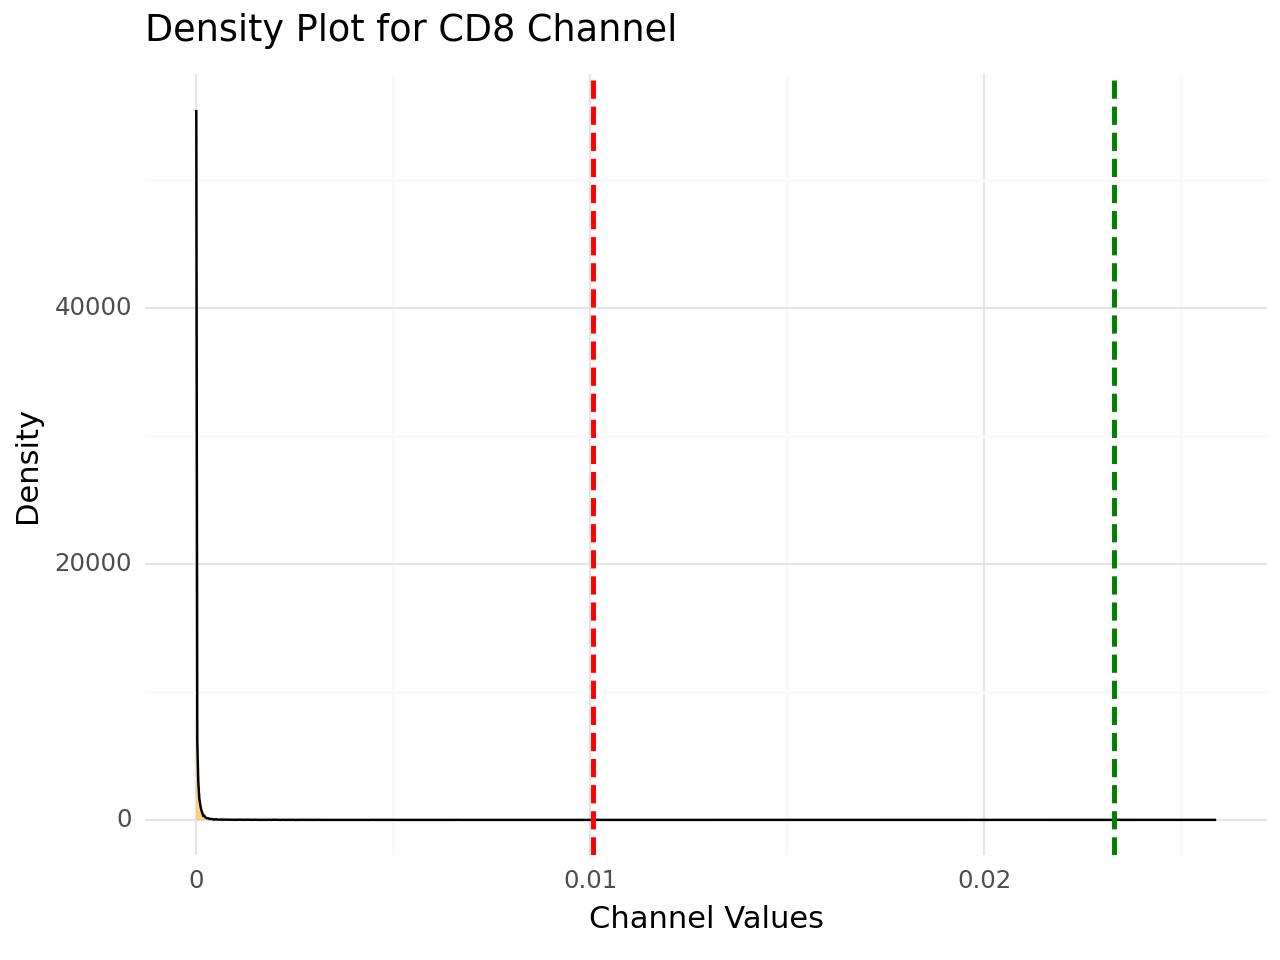

 41%|████      | 15/37 [00:26<00:39,  1.79s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CD98.png


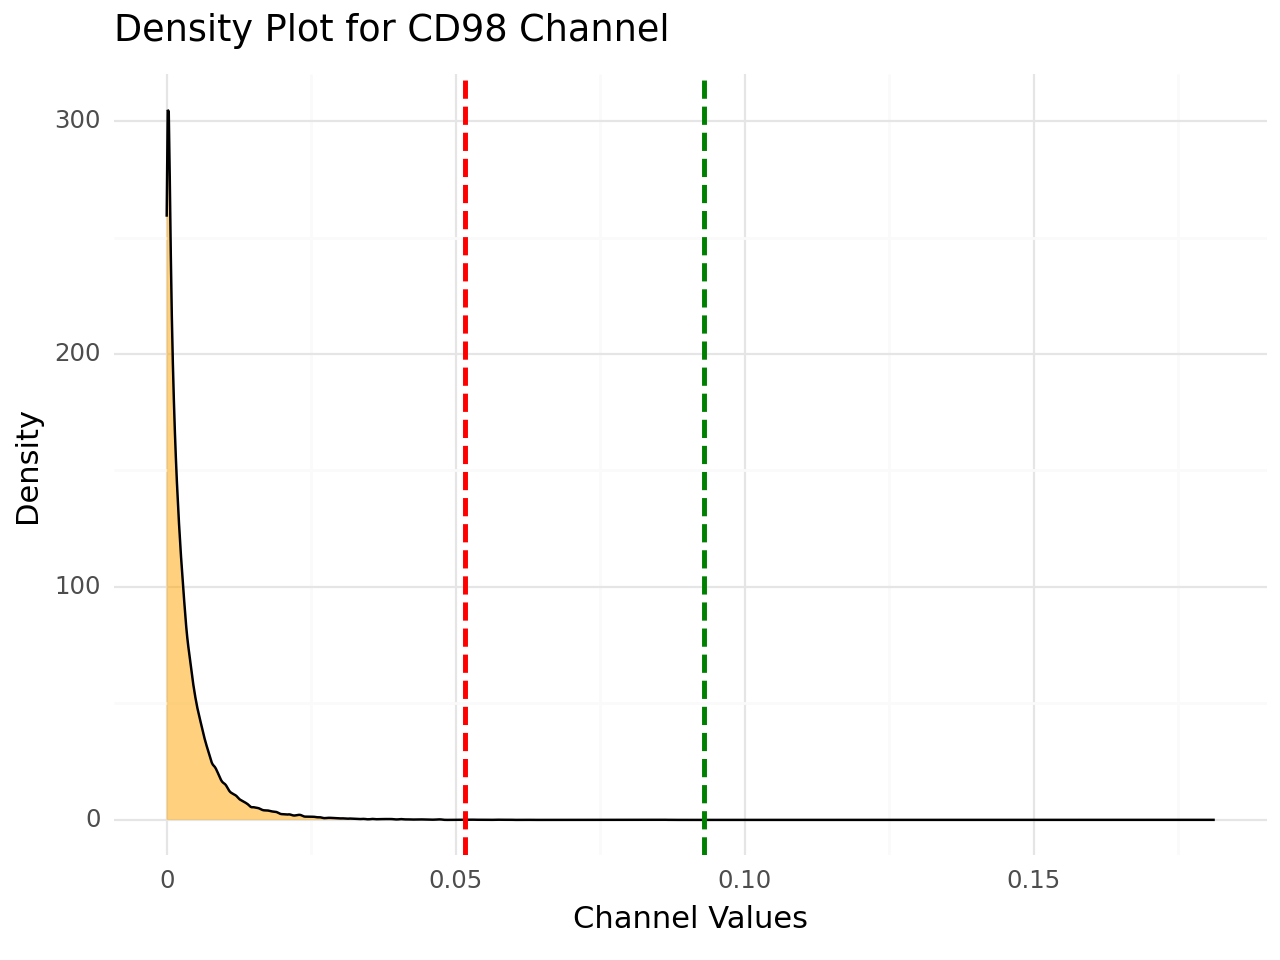

 43%|████▎     | 16/37 [00:28<00:37,  1.78s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CPT1A.png


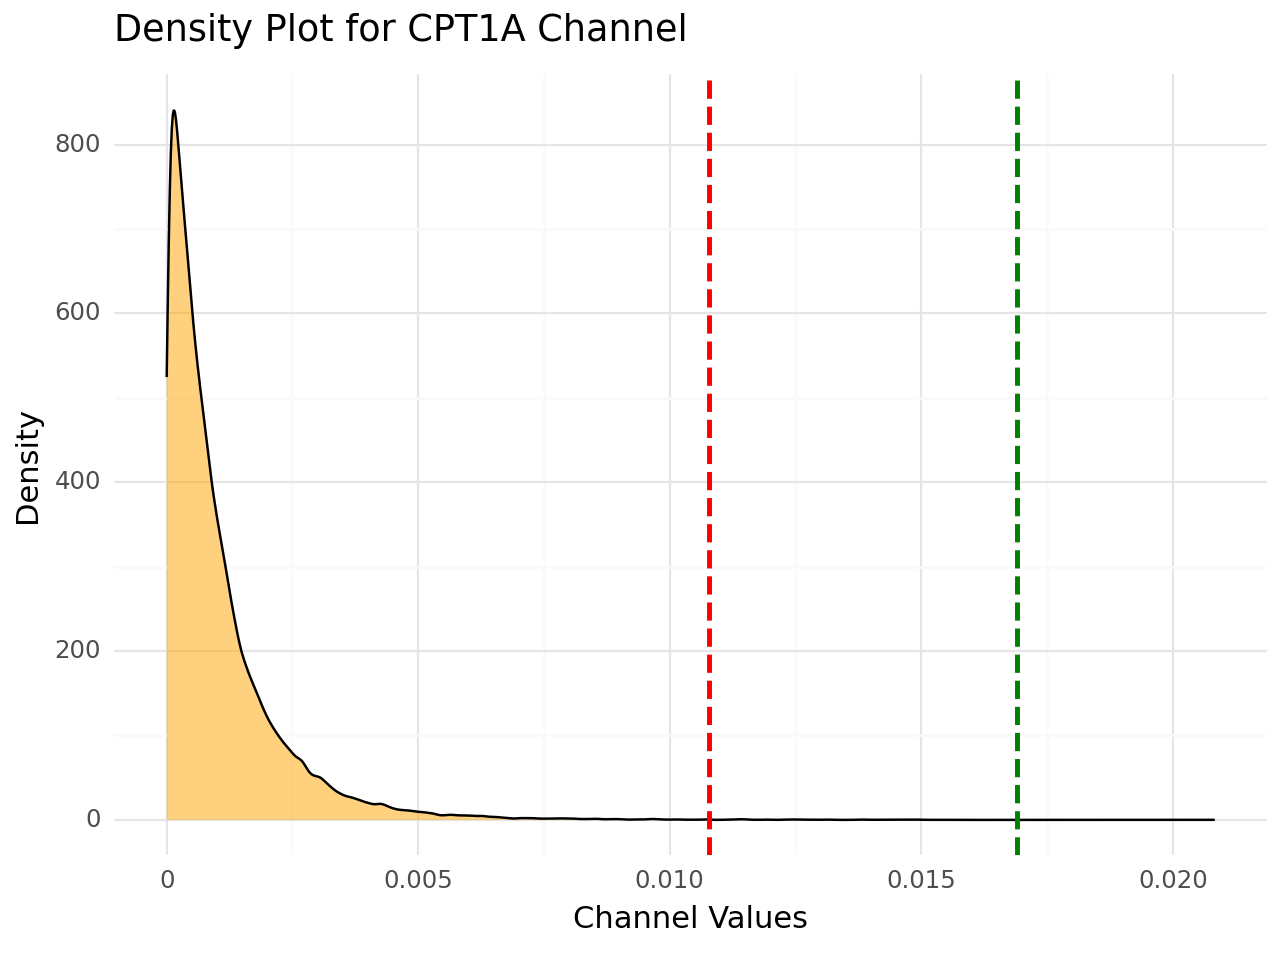

 46%|████▌     | 17/37 [00:30<00:35,  1.79s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CS.png


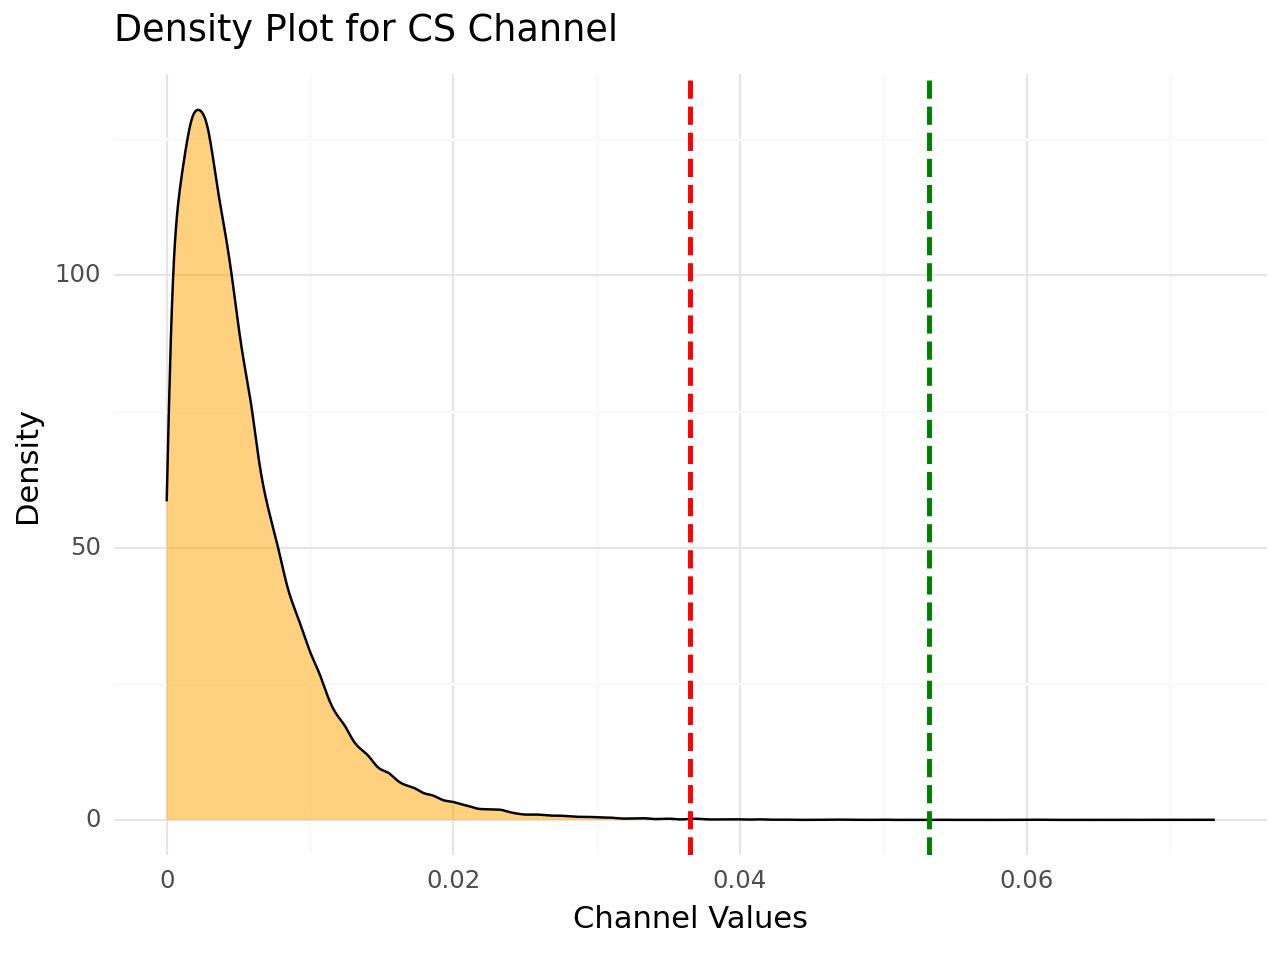

 49%|████▊     | 18/37 [00:31<00:33,  1.78s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_DCN.png


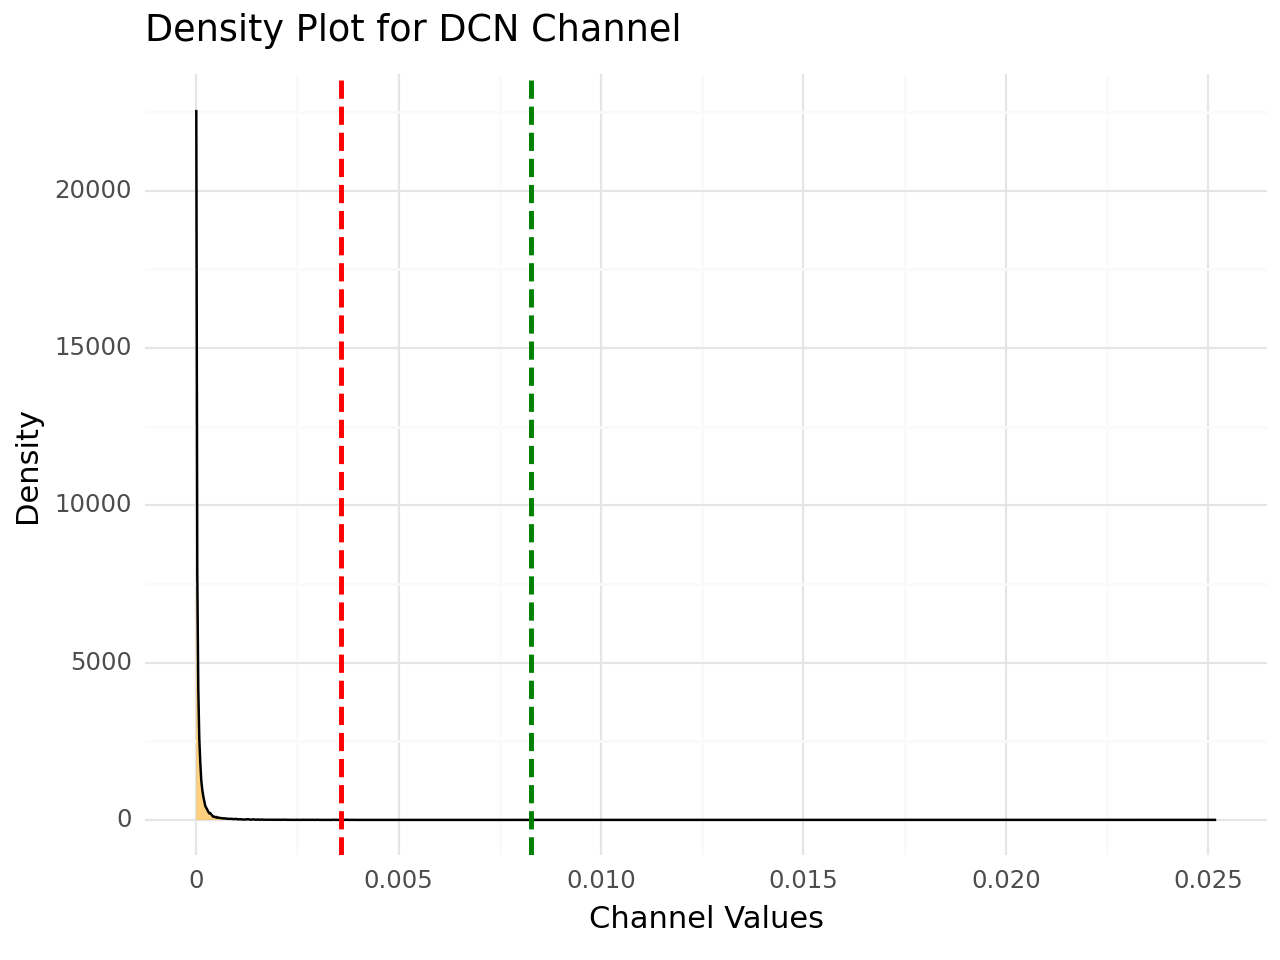

 51%|█████▏    | 19/37 [00:33<00:32,  1.82s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_GS.png


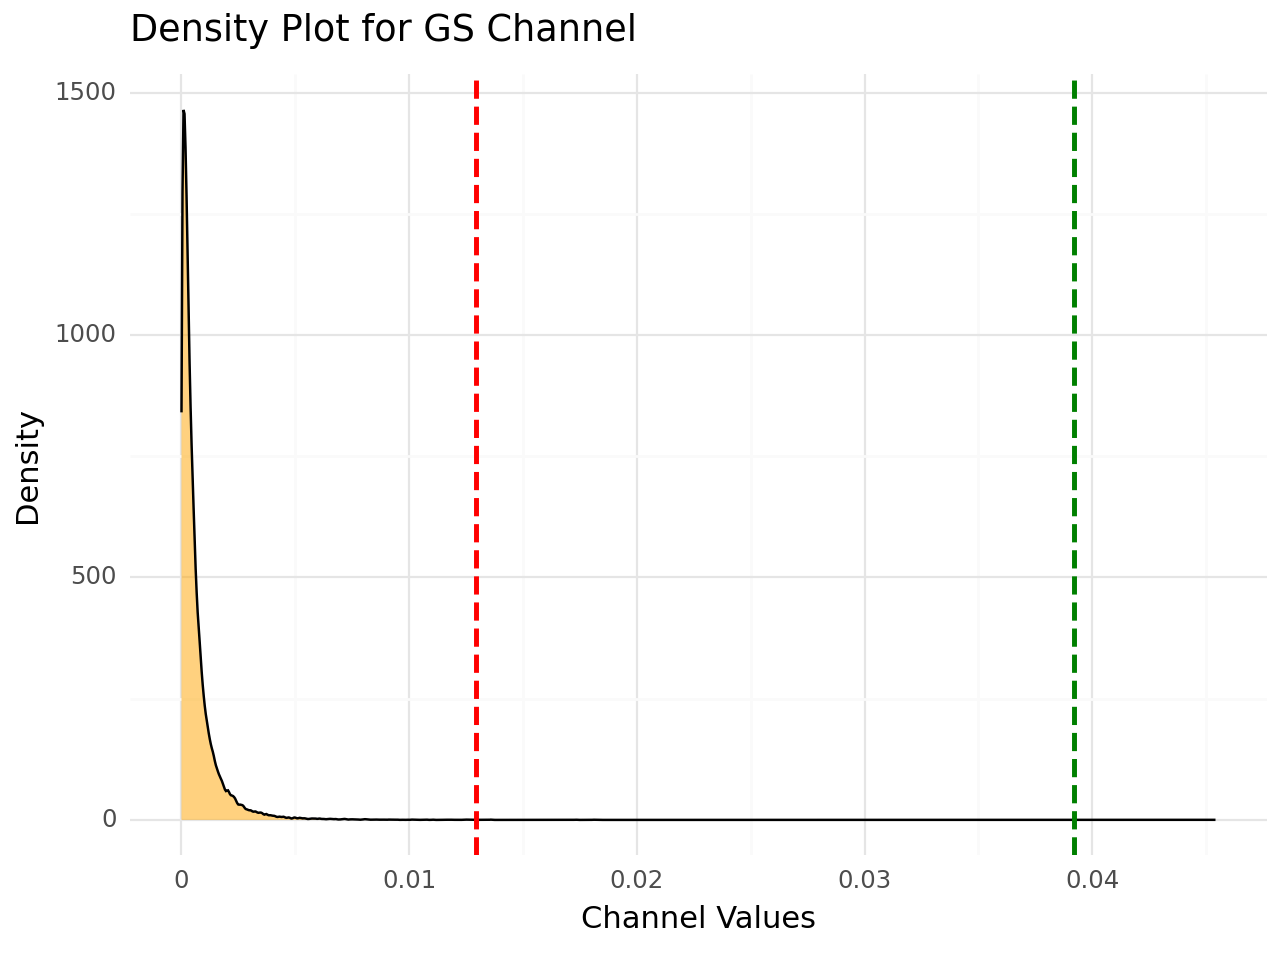

 54%|█████▍    | 20/37 [00:35<00:30,  1.80s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_MPO.png


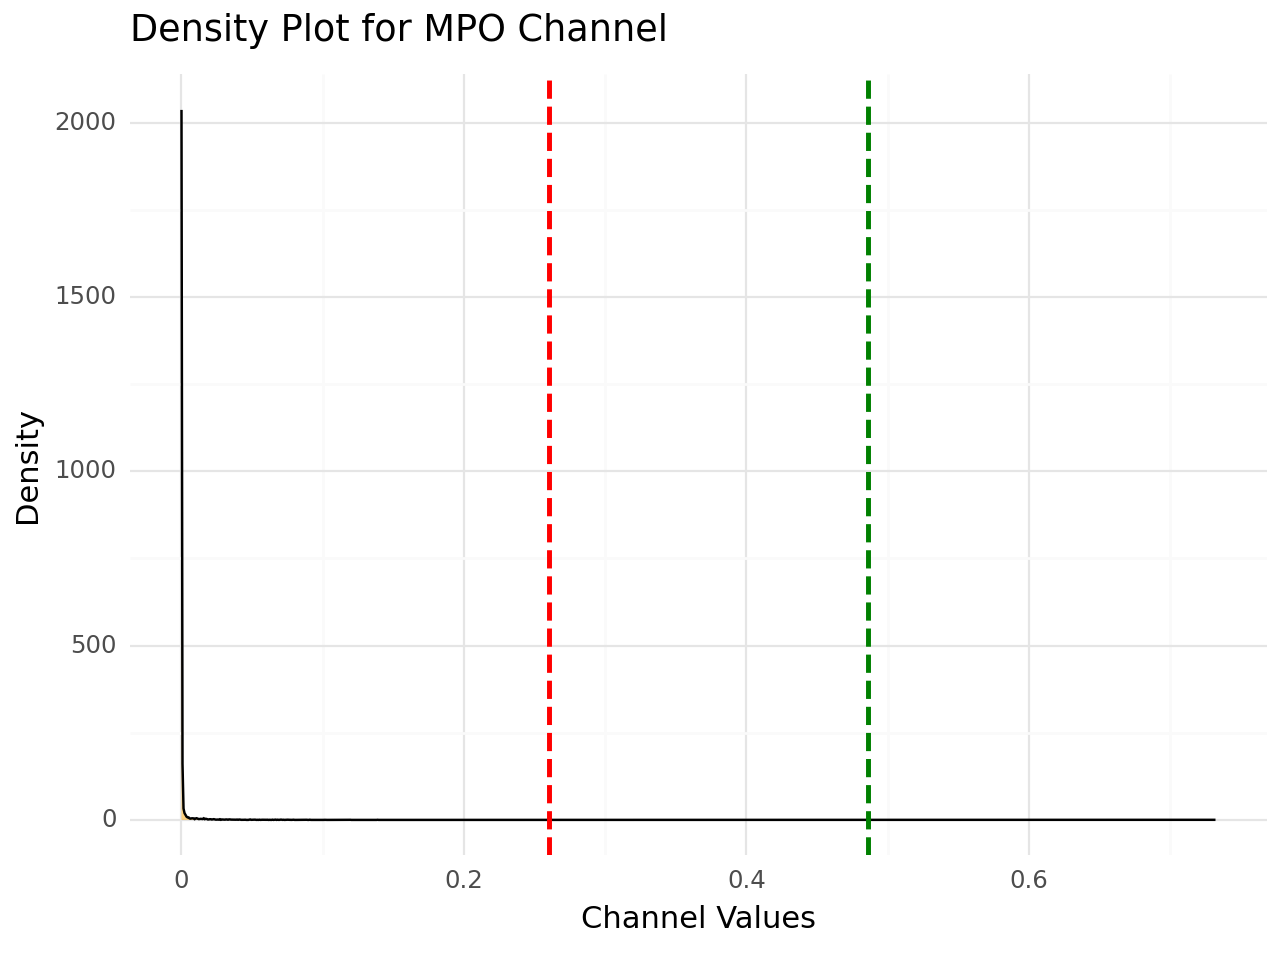

 57%|█████▋    | 21/37 [00:37<00:28,  1.79s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_MSH2.png


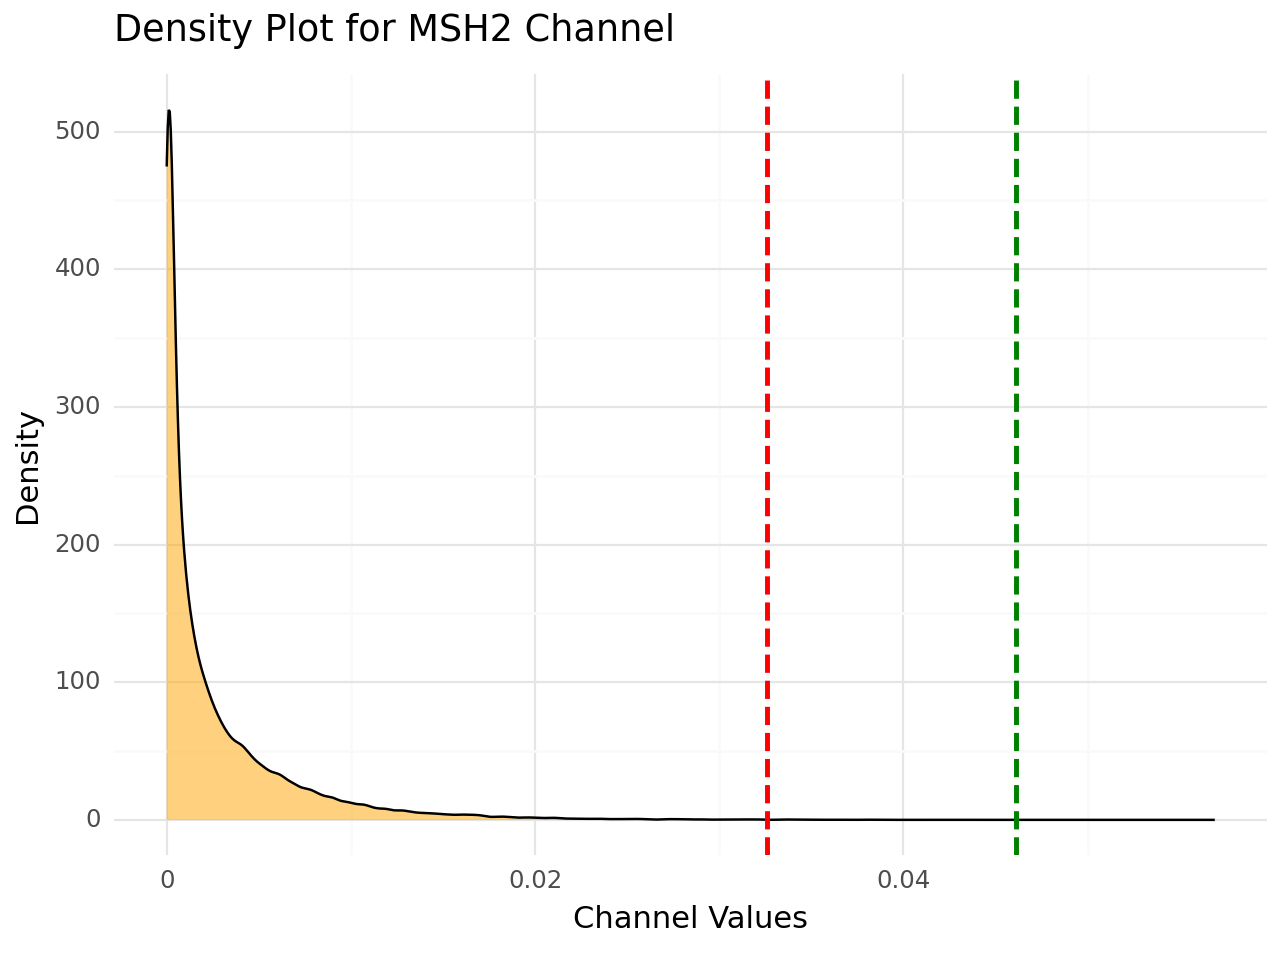

 59%|█████▉    | 22/37 [00:38<00:26,  1.76s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_MSH6.png


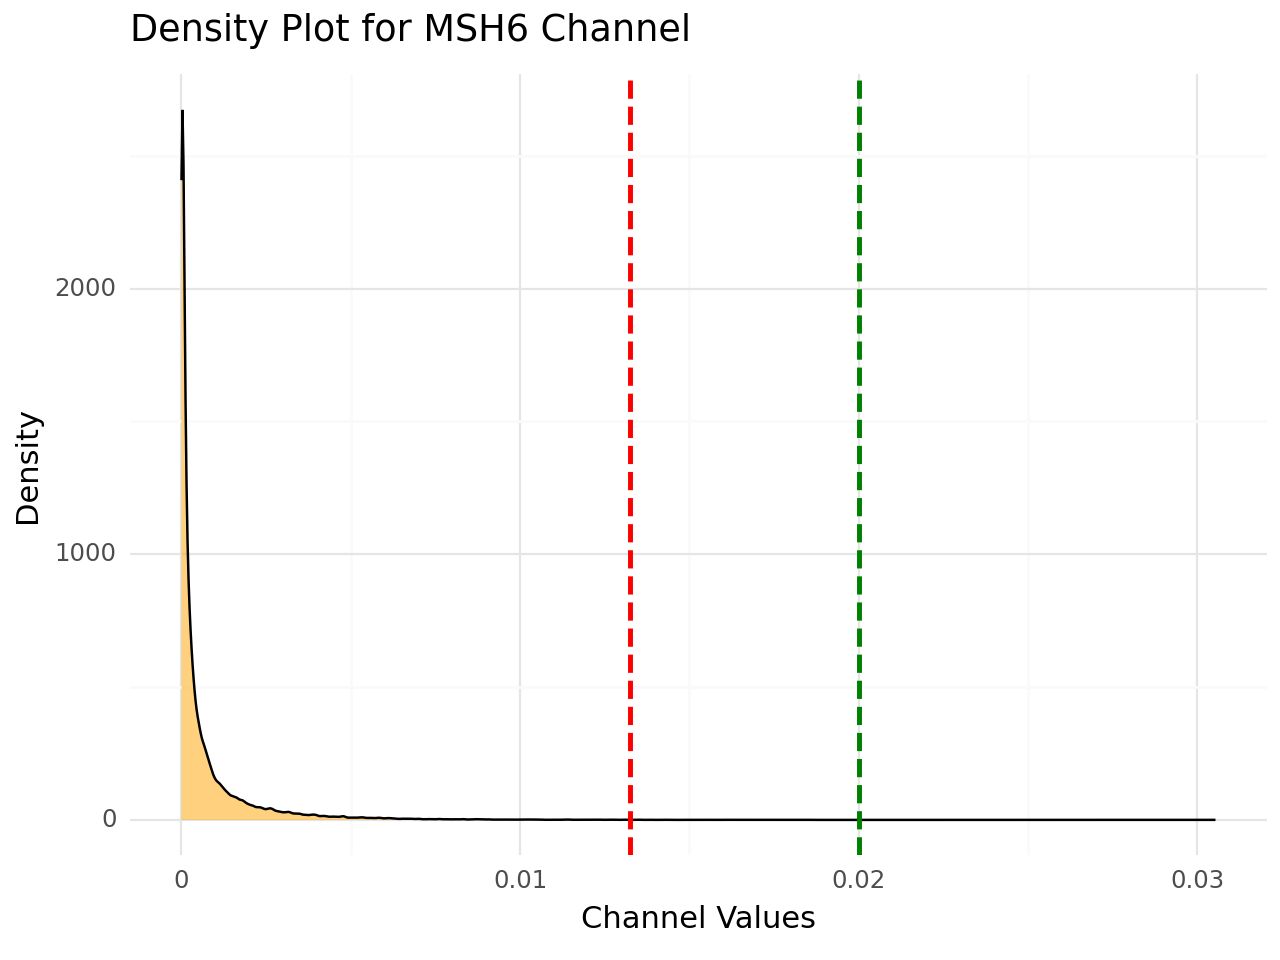

 62%|██████▏   | 23/37 [00:40<00:24,  1.75s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_CytC.png


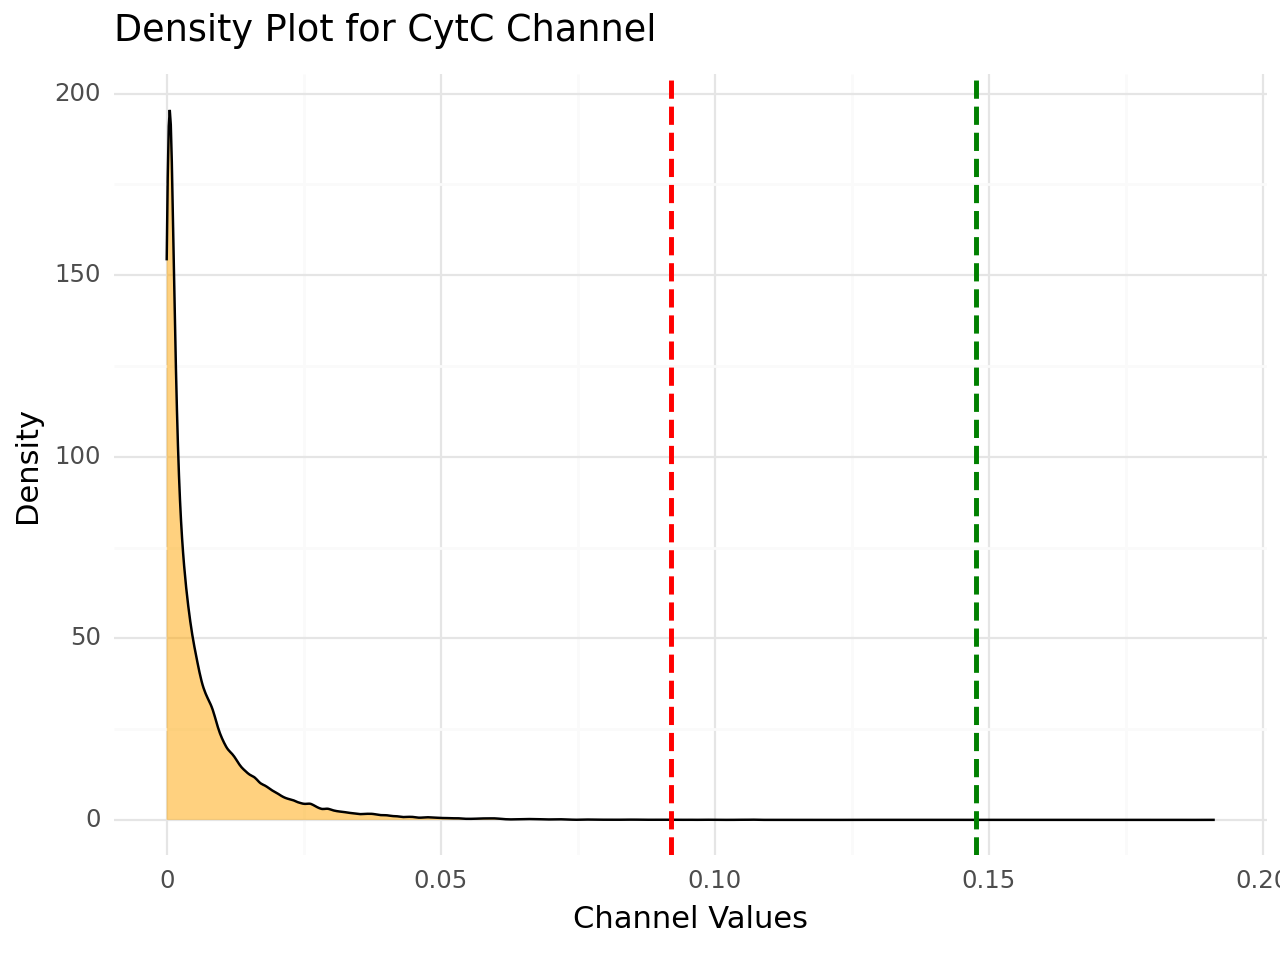

 65%|██████▍   | 24/37 [00:42<00:22,  1.75s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_FoxP3.png


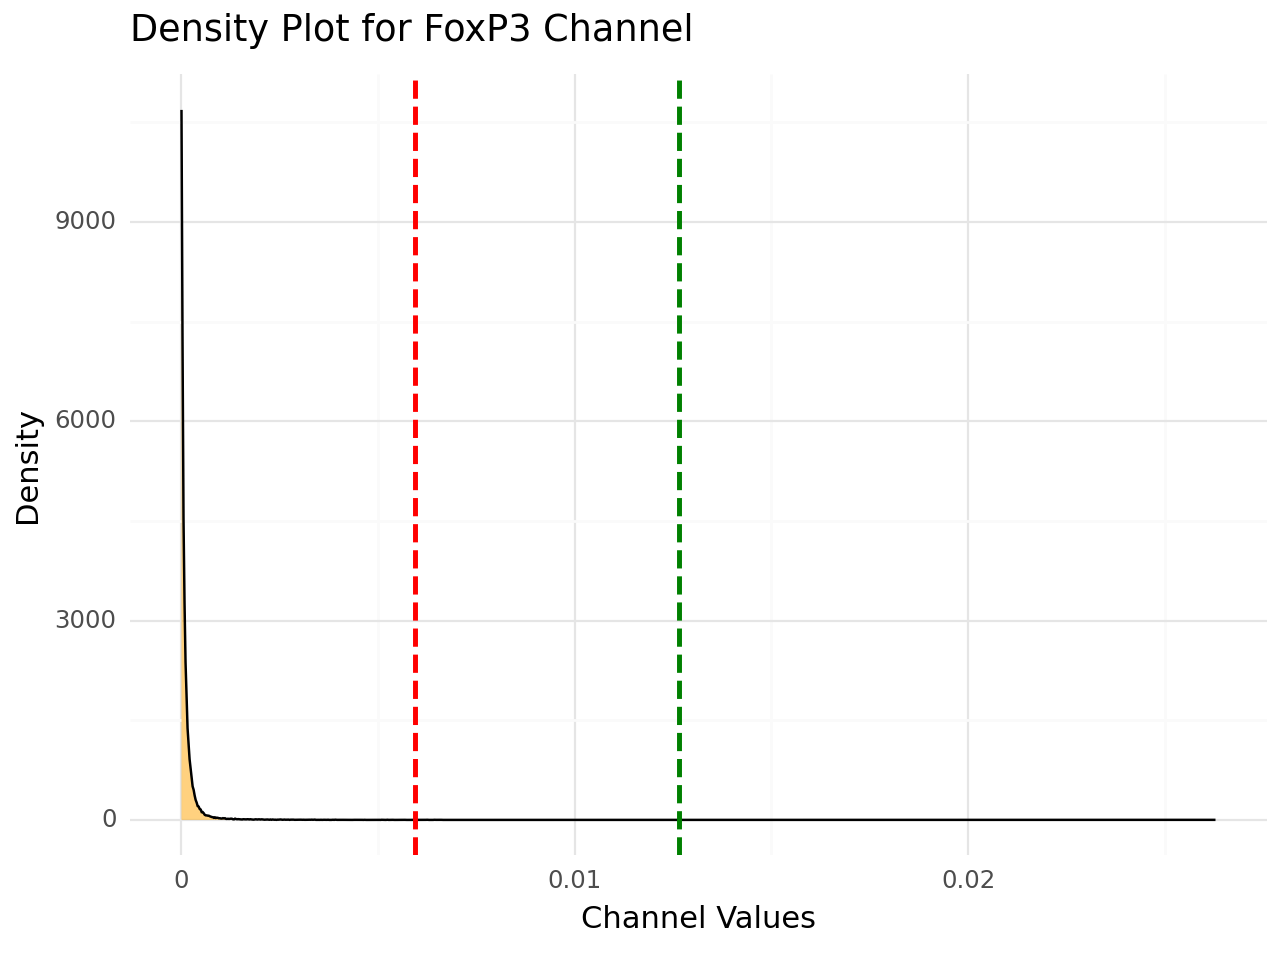

 68%|██████▊   | 25/37 [00:44<00:20,  1.74s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_GLS.png


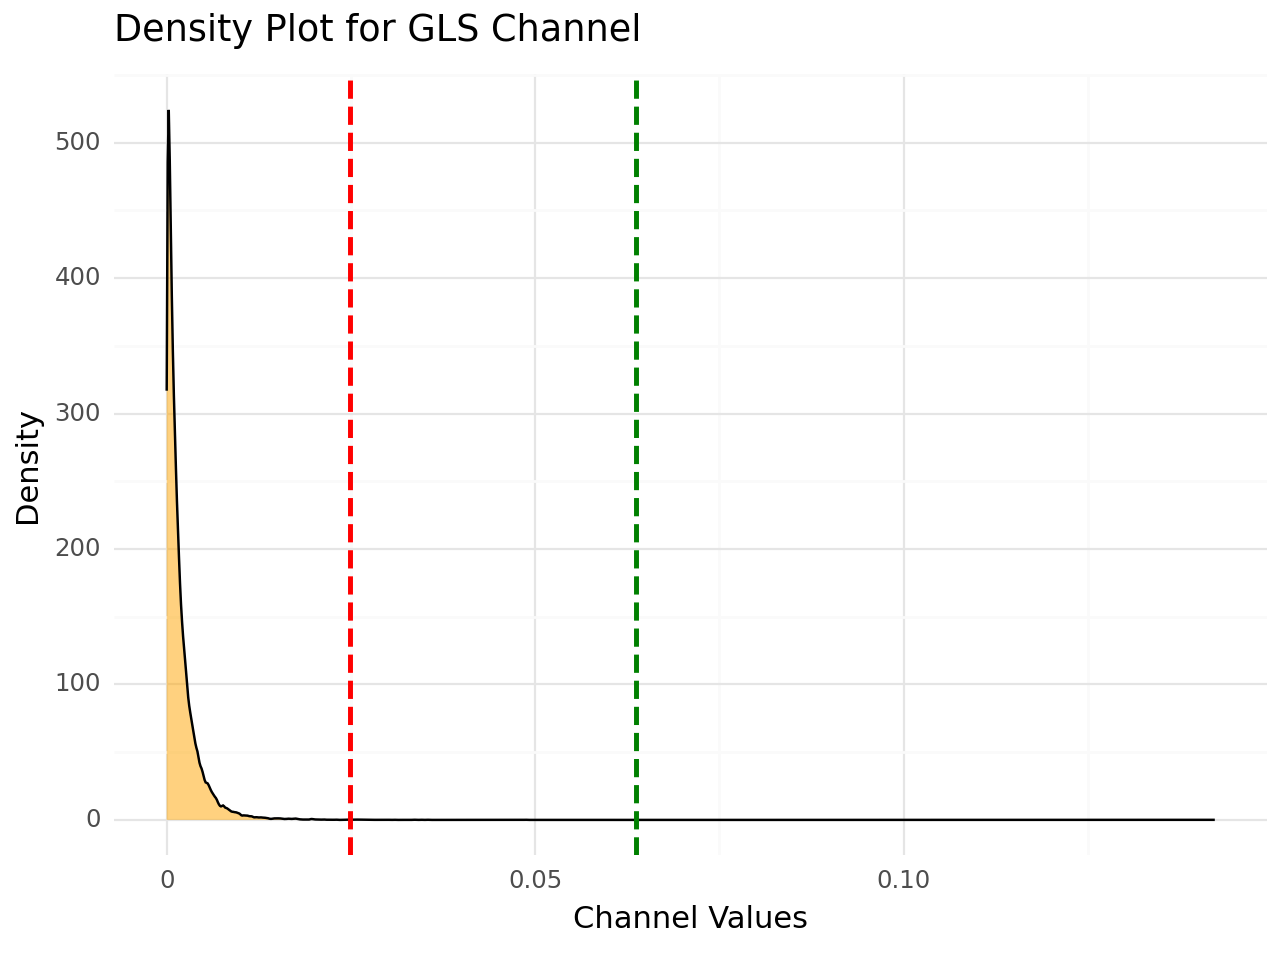

 70%|███████   | 26/37 [00:45<00:19,  1.77s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_GLUT1.png


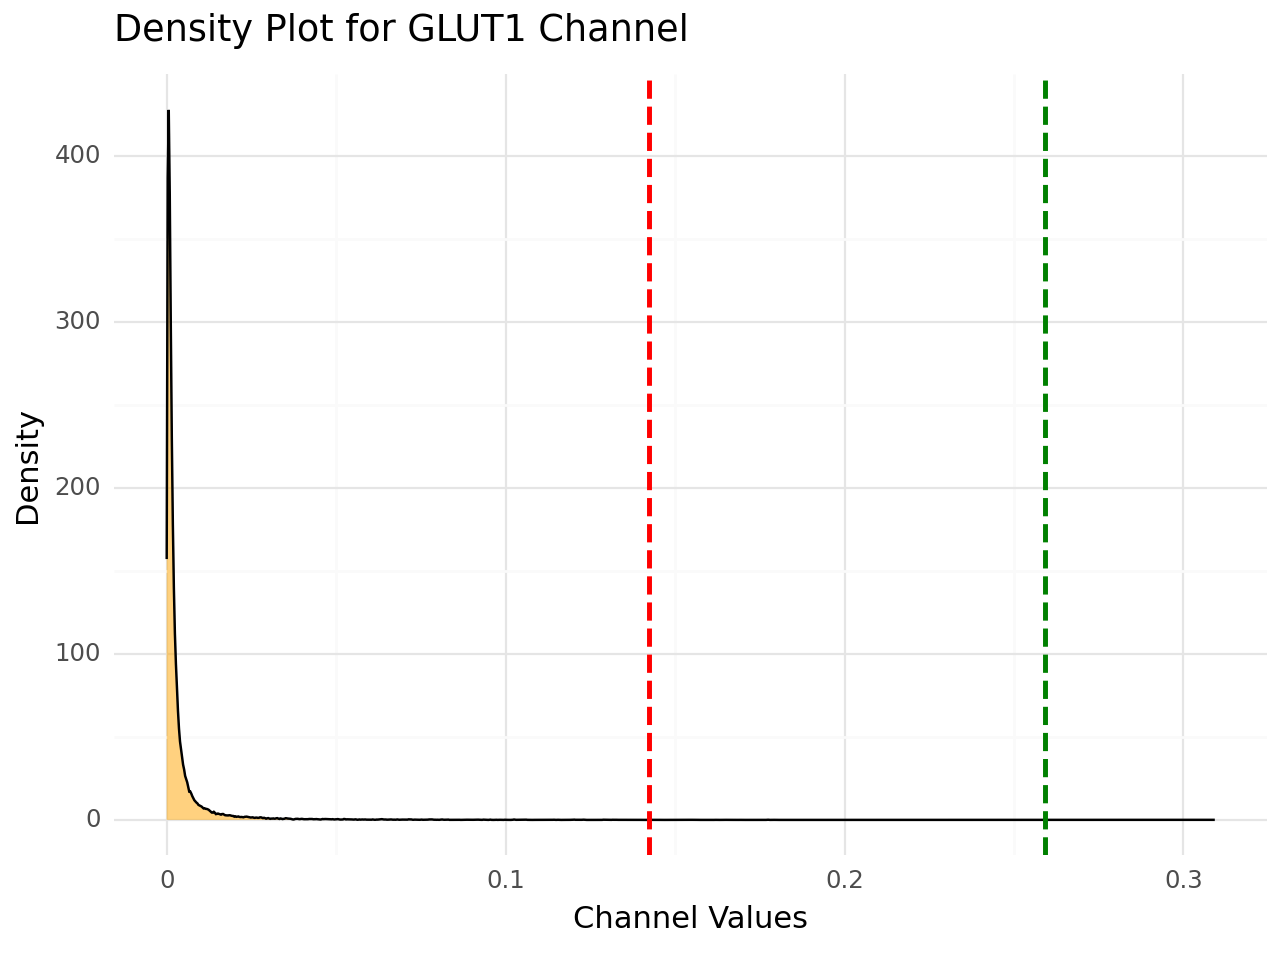

 73%|███████▎  | 27/37 [00:47<00:17,  1.78s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_HLADRa.png


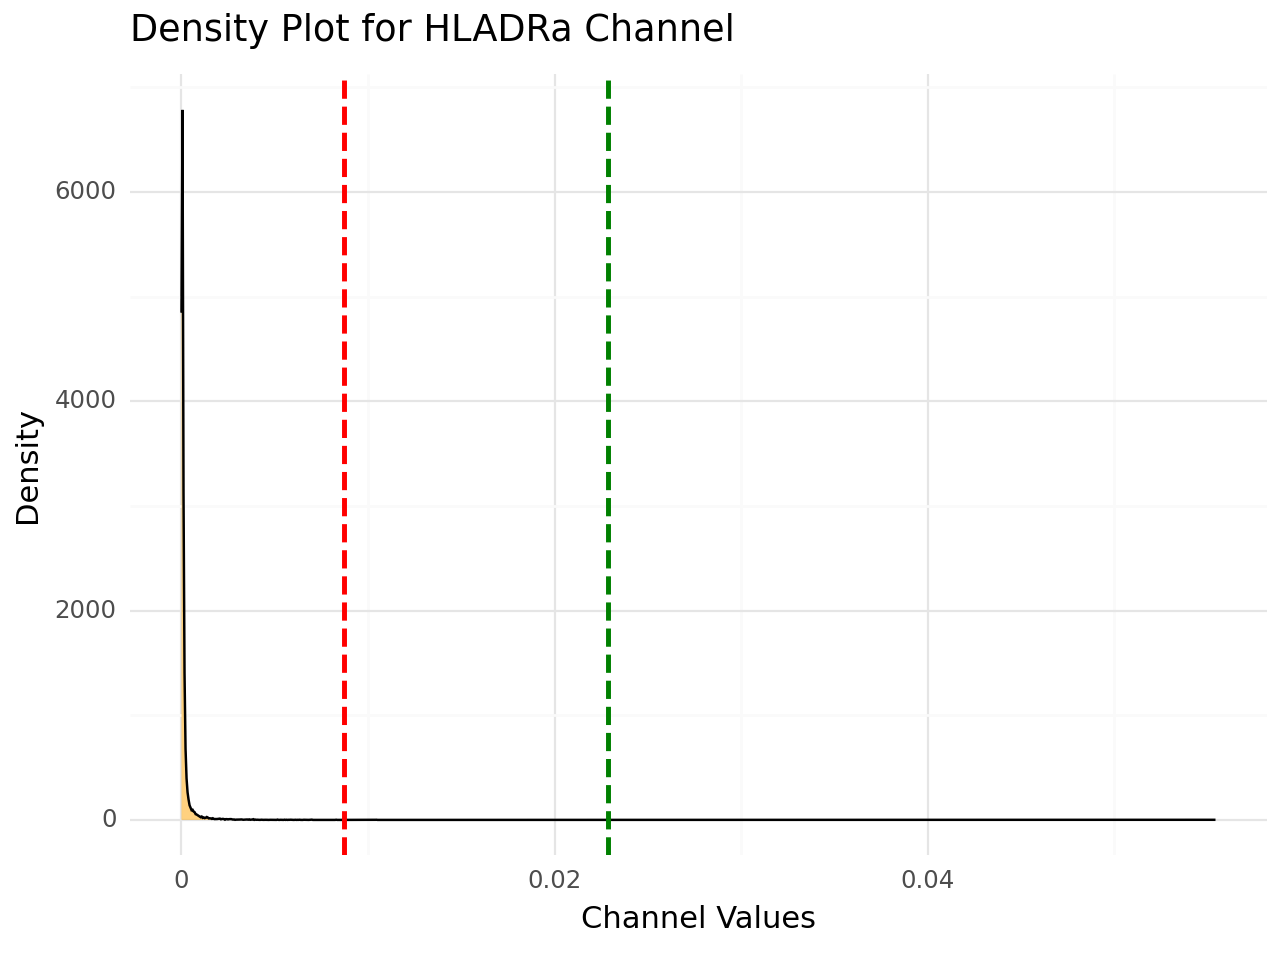

 76%|███████▌  | 28/37 [00:49<00:16,  1.81s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_Ki67.png


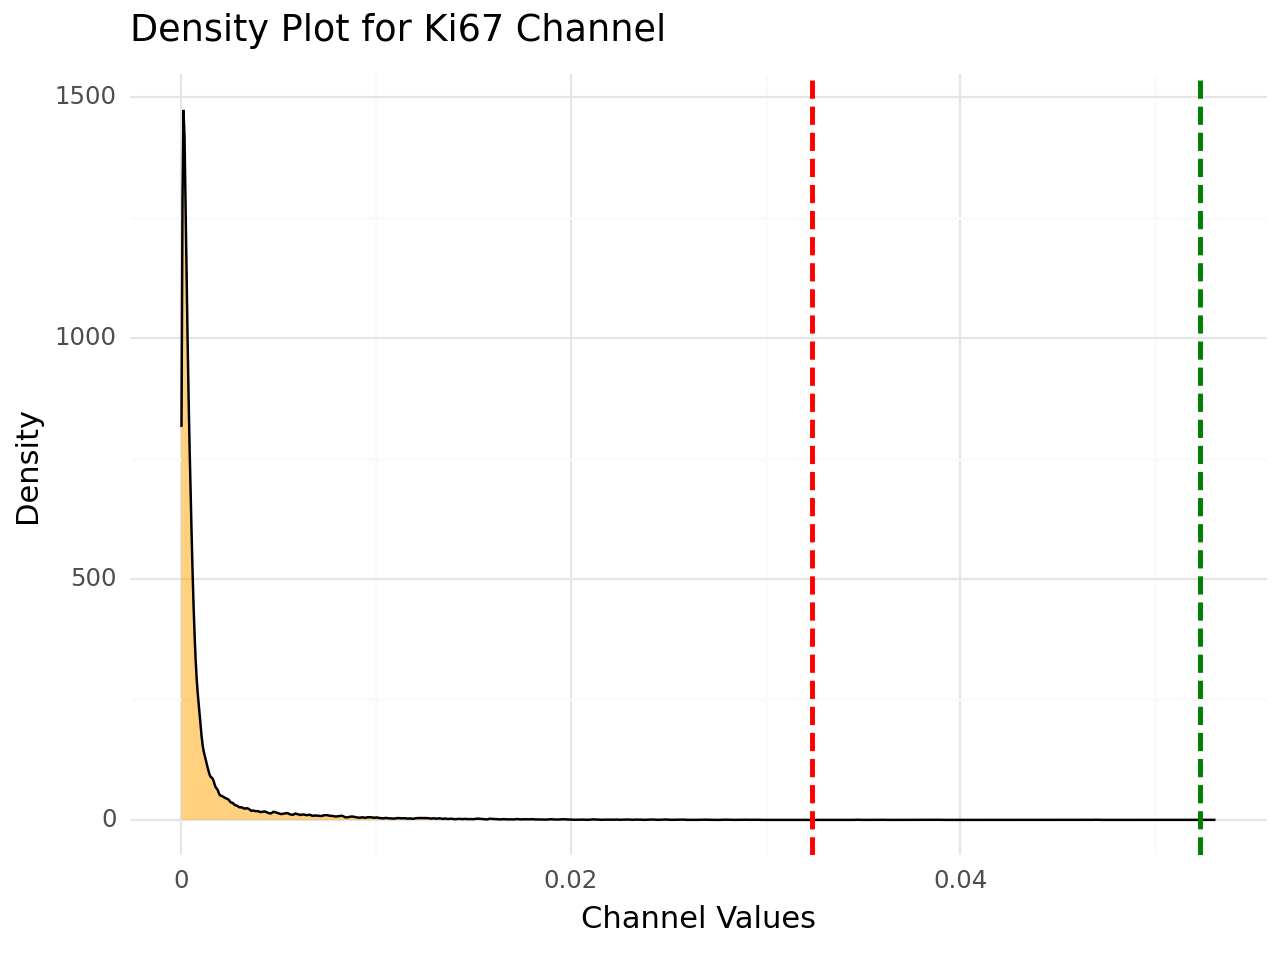

 78%|███████▊  | 29/37 [00:51<00:14,  1.80s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_LDH.png


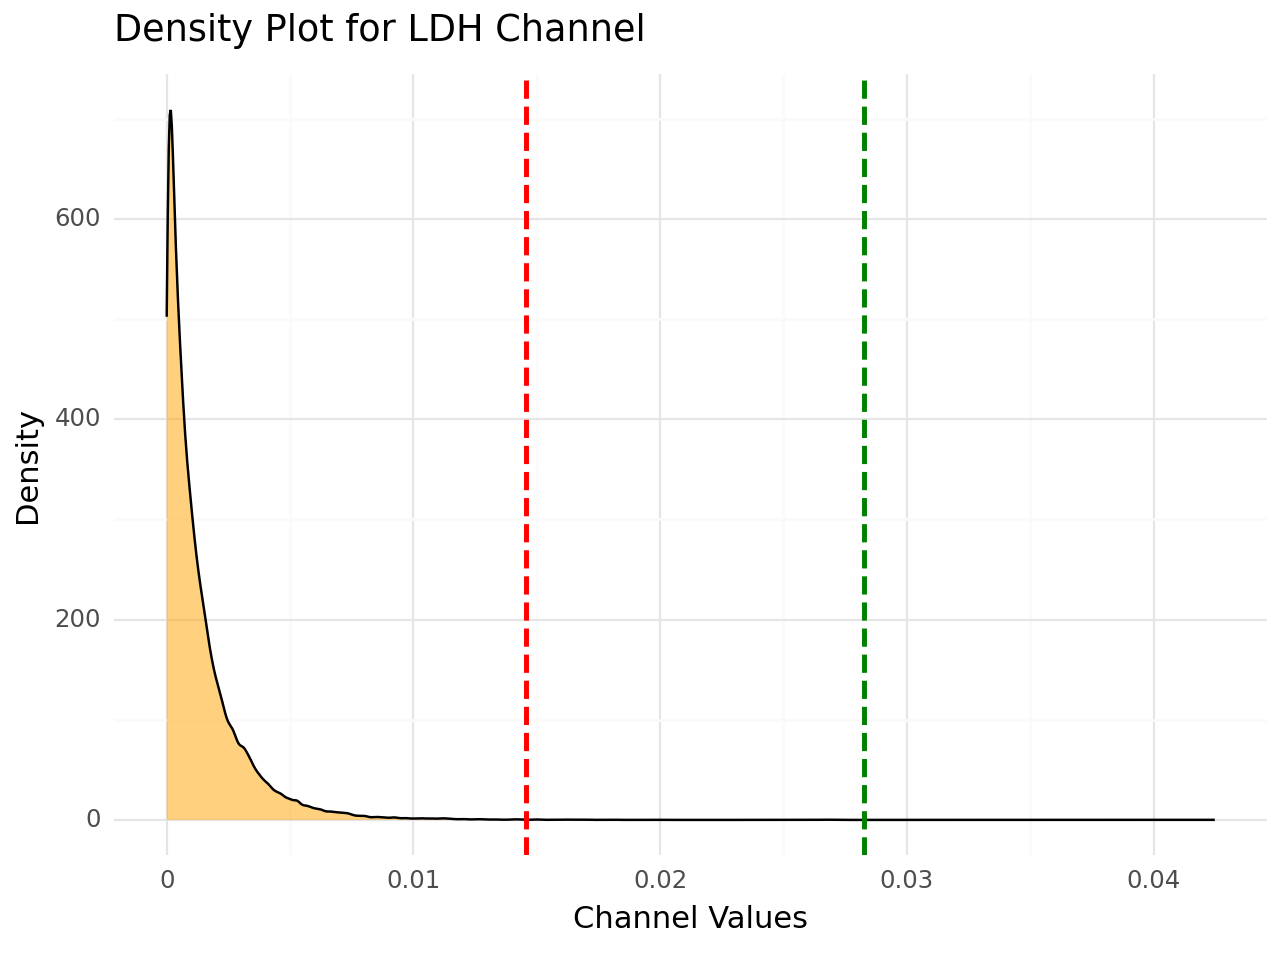

 81%|████████  | 30/37 [00:53<00:12,  1.81s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_MCT1.png


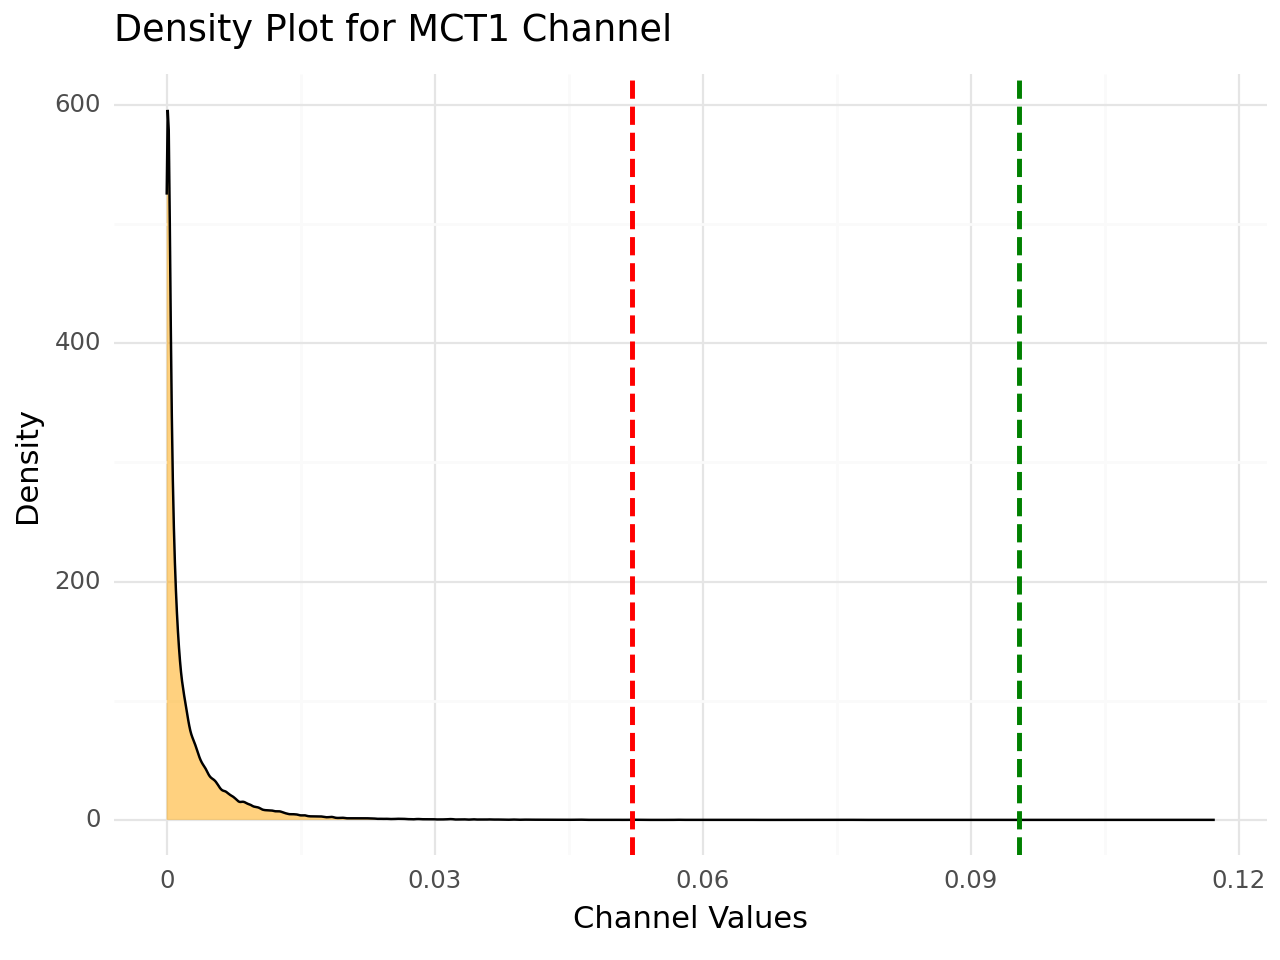

 84%|████████▍ | 31/37 [00:55<00:10,  1.83s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_PDL1.png


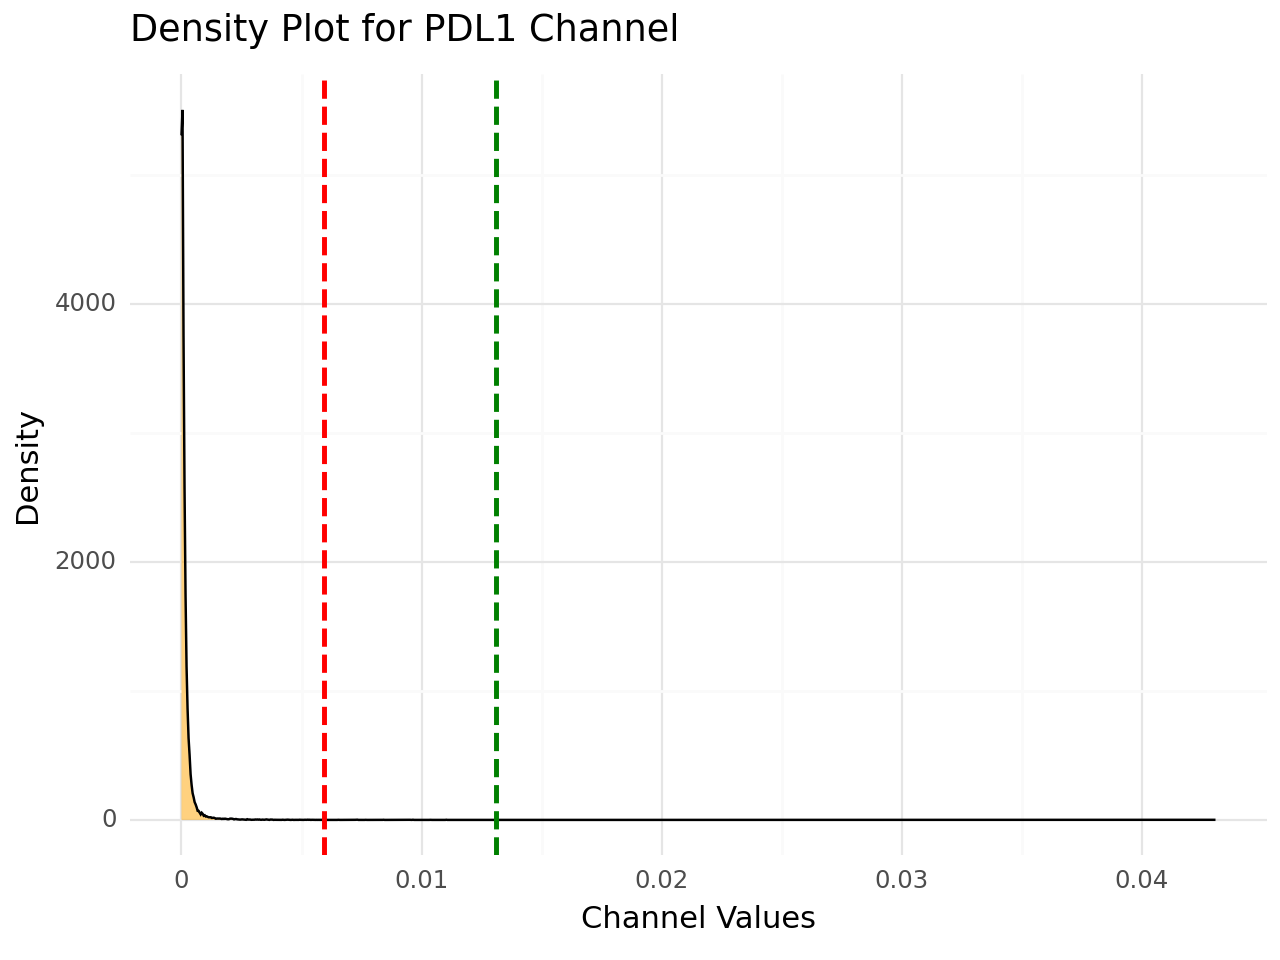

 86%|████████▋ | 32/37 [00:56<00:08,  1.80s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_PD1.png


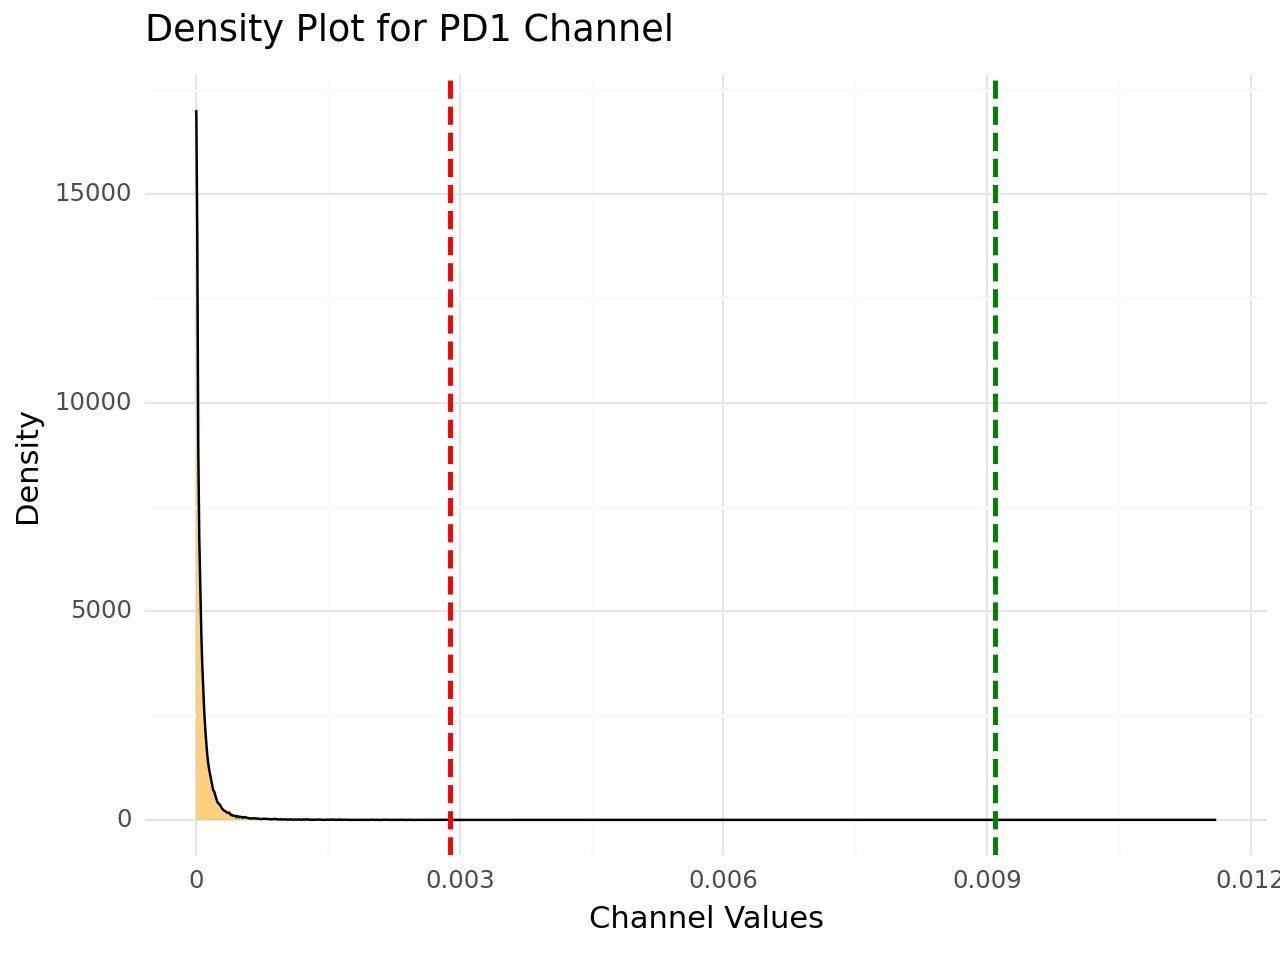

 89%|████████▉ | 33/37 [00:58<00:07,  1.77s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_PKM2.png


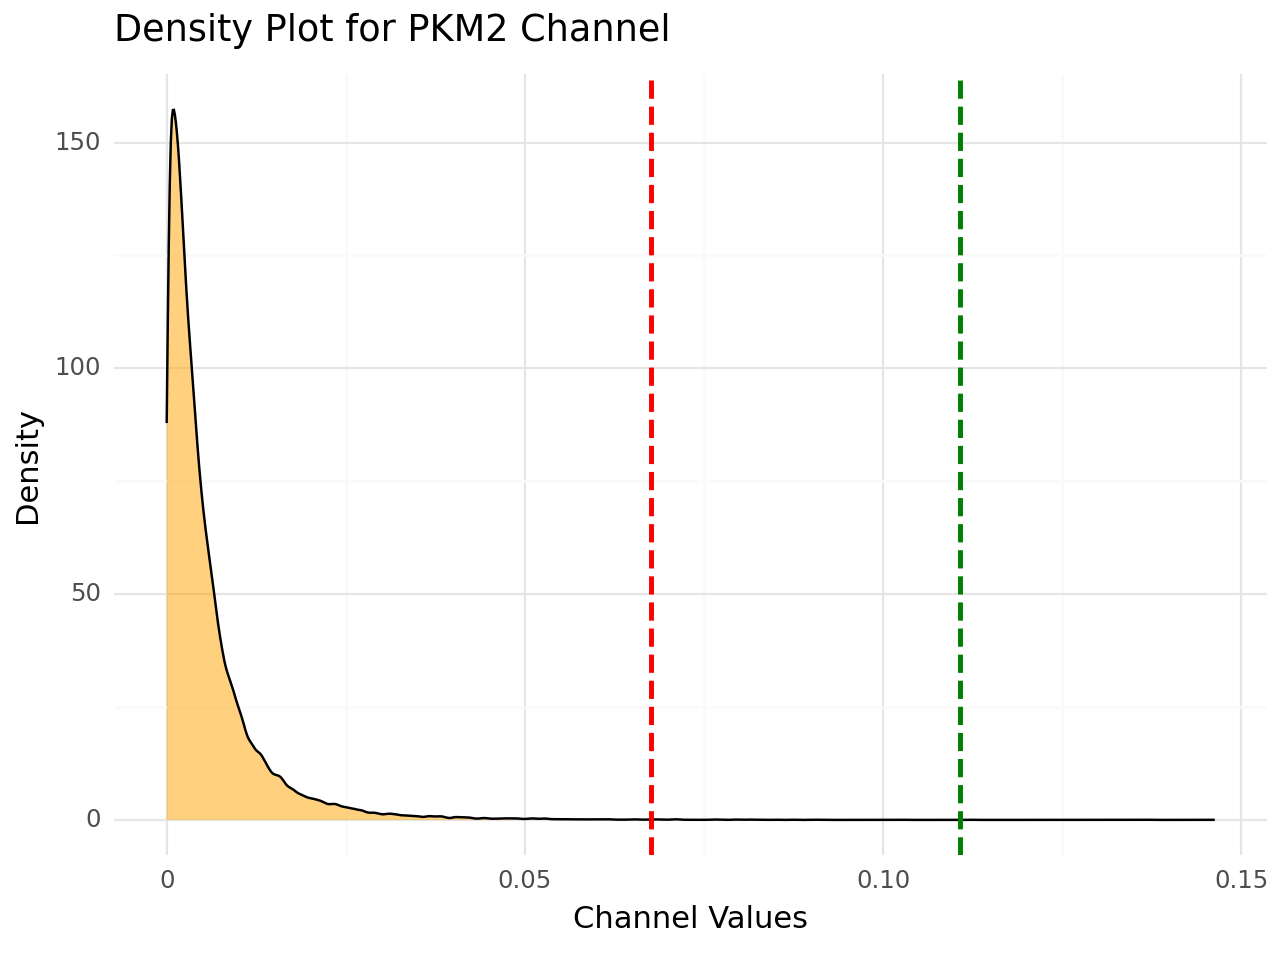

 92%|█████████▏| 34/37 [01:00<00:05,  1.77s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_PanCK.png


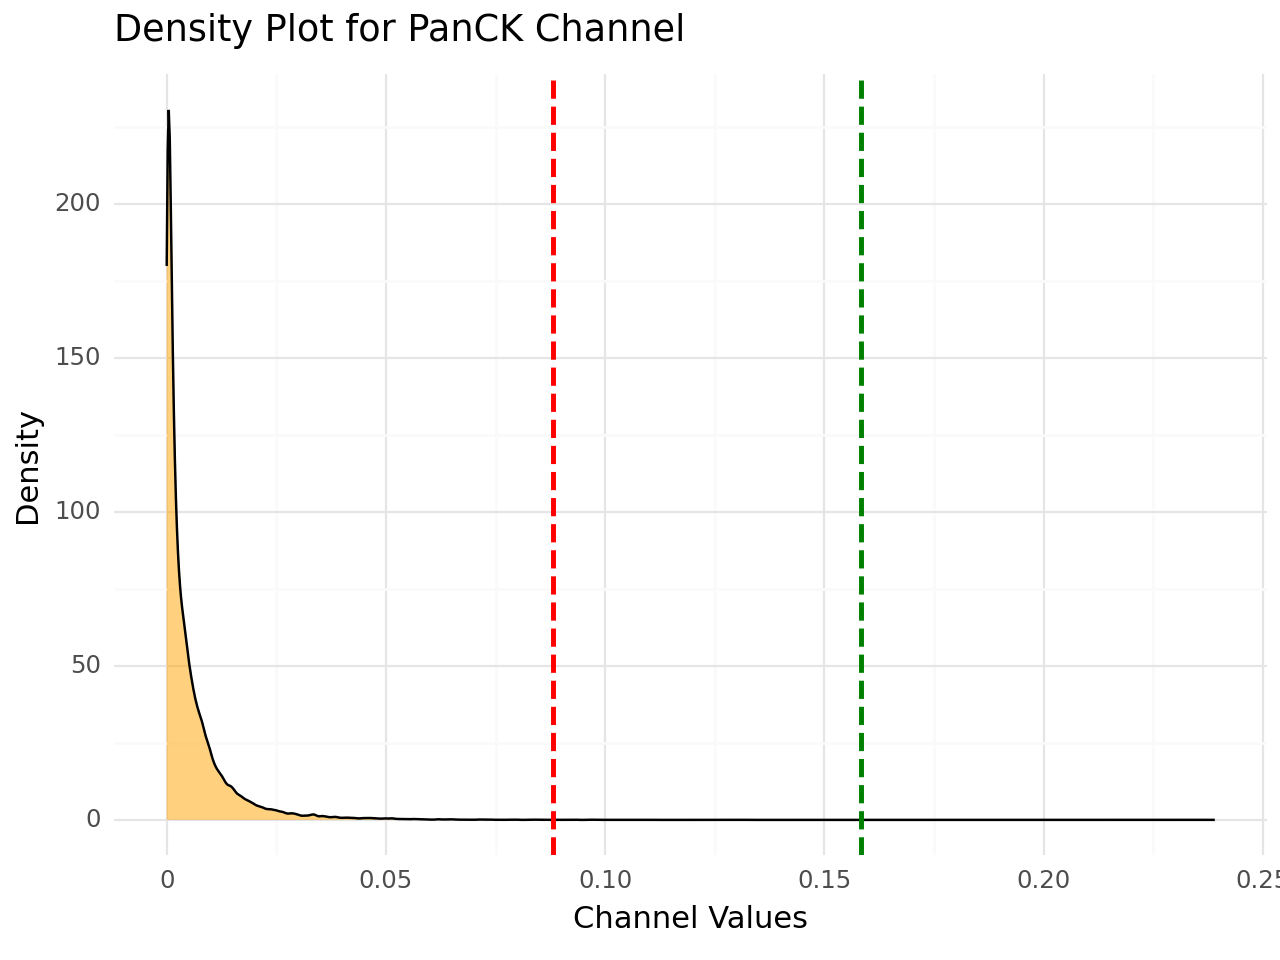

 95%|█████████▍| 35/37 [01:02<00:03,  1.77s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_SMA.png


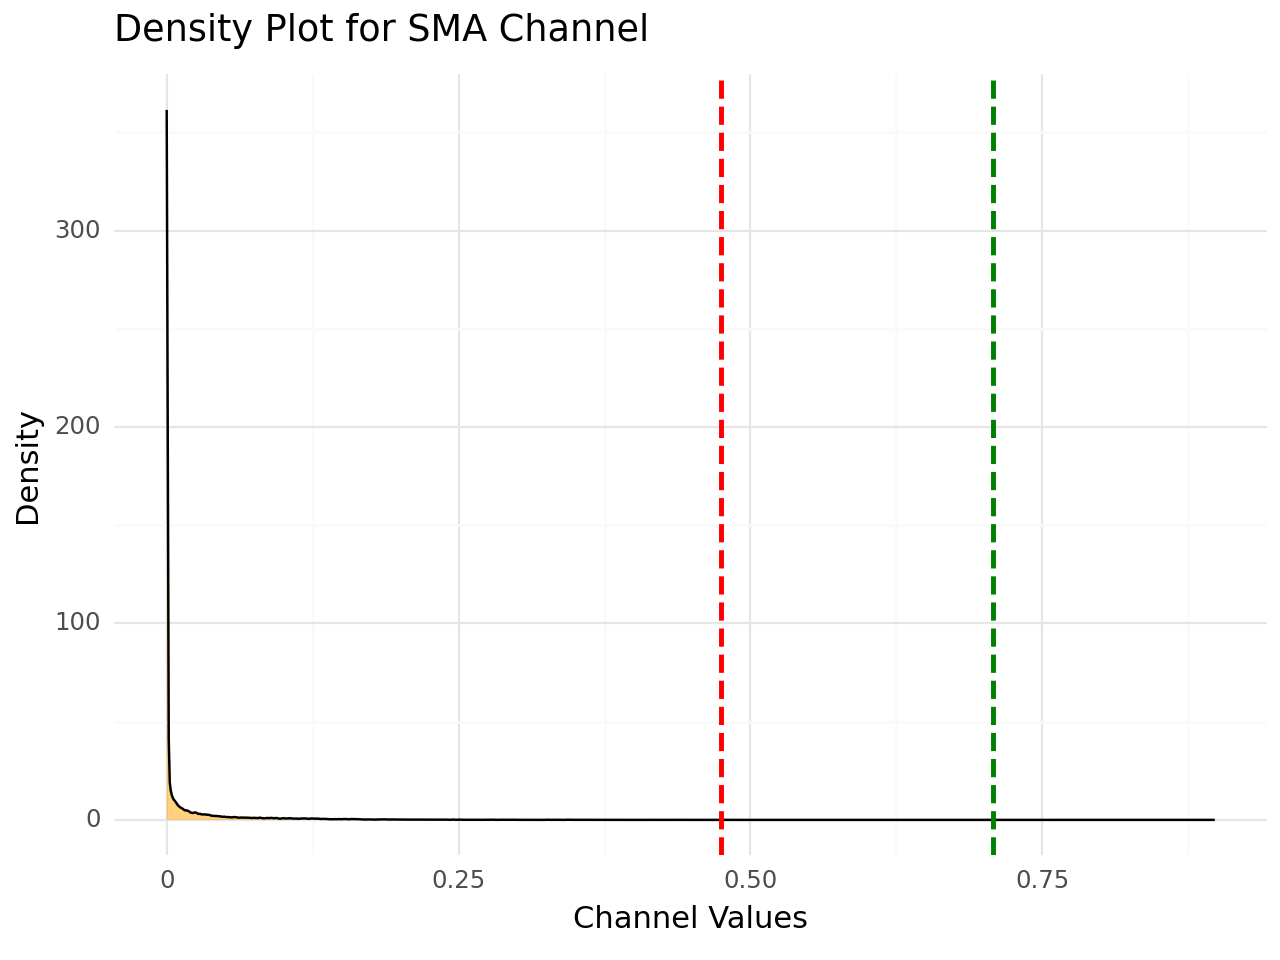

 97%|█████████▋| 36/37 [01:03<00:01,  1.75s/it]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/raw/density_plot_Vimentin.png


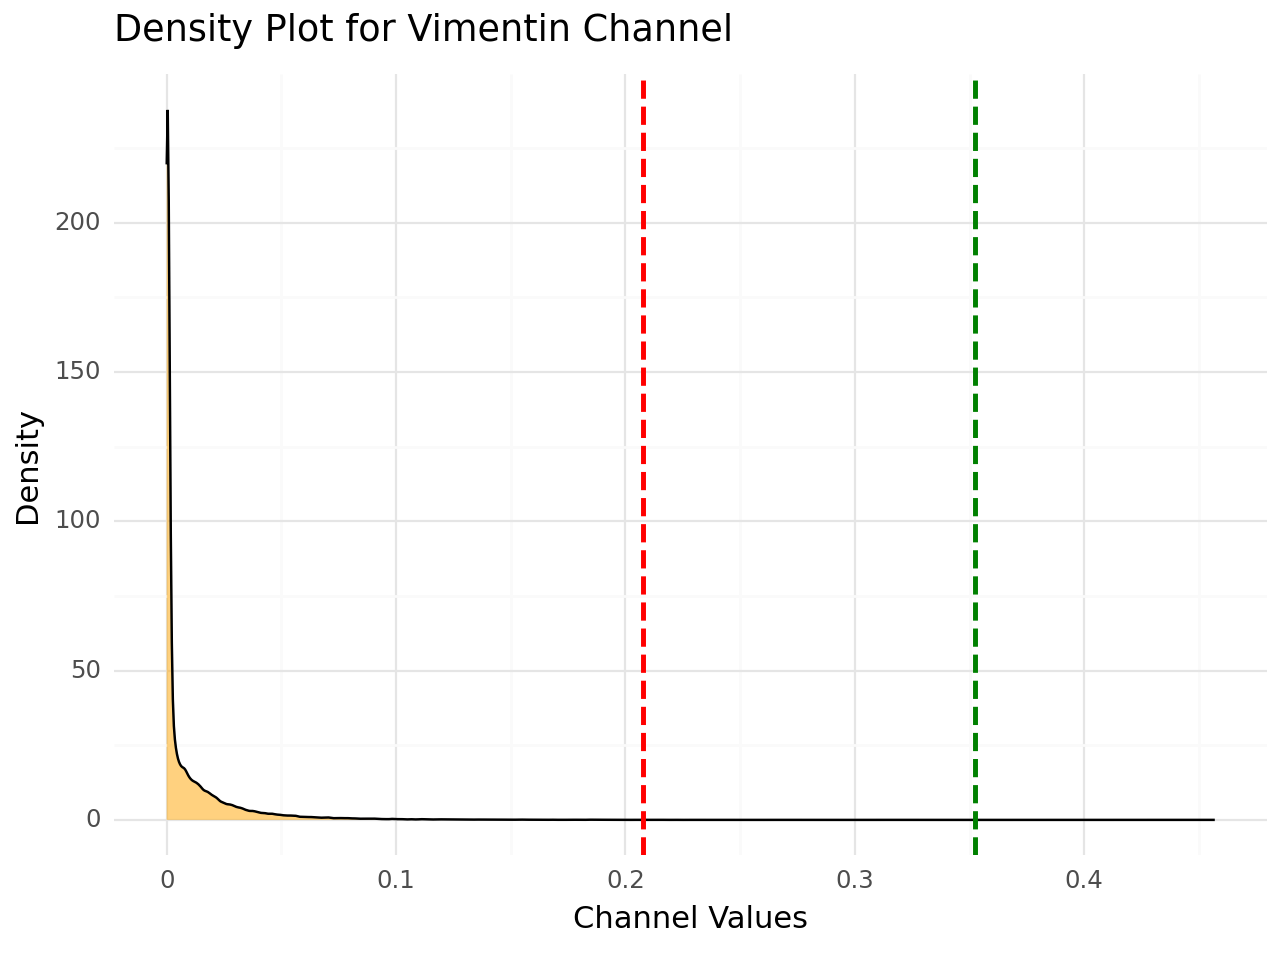

100%|██████████| 37/37 [01:05<00:00,  1.77s/it]

In [9]:
# We represent up to 50000 cells on the density plot
cell_subtable = cell_table.sample(min(cell_table.shape[0], 50000))

# Iterate over each channel and create a density plot
for channel in tqdm(channels):
    cytof_99_9 = np.percentile(cell_table[channel], 99.9)
    cytof_99_99 = np.percentile(cell_table[channel], 99.99)
    
    plot = (
        ggplot(cell_subtable, aes(x=channel)) 
        + geom_density(fill='orange', alpha=0.5)
        + geom_vline(aes(xintercept=cytof_99_9), color='red', linetype='--', size=1)
        + geom_vline(aes(xintercept=cytof_99_99), color='green', linetype='--', size=1)
        + labs(x='Channel Values', y='Density', title=f'Density Plot for {channel} Channel')
        + theme_minimal()
    )
    
    # Save the image
    save_path = os.path.join(raw_dir, f'density_plot_{channel}.png')
    ggsave(plot, save_path)

    # Print the plot
    print(plot)

In [10]:
# Then, you can calculate the 99.9% percentale for all channels to ensure that you do not consider any outliers
cytof = cell_table[channels].quantile(.999)
print(cytof)

# Save the file as CSV to have them for later
save_path = os.path.join(preprocess_dir, 'percentile_markers.csv')
cytof.to_csv(save_path, index=False)

ARG1        0.007241
ASCT2       0.050183
ATP5A       0.083934
CA9         0.120074
CD14        0.022515
CD163       0.010762
STING1      0.044086
CD20        0.065774
CD3e        0.016164
CD31        0.078689
CD4         0.017891
CD45        0.071443
CD68        0.061416
CD7         0.039947
CD8         0.010077
CD98        0.051676
CPT1A       0.010777
CS          0.036535
DCN         0.003587
GS          0.012949
MPO         0.260409
MSH2        0.032610
MSH6        0.013259
CytC        0.092091
FoxP3       0.005936
GLS         0.024882
GLUT1       0.142405
HLADRa      0.008736
Ki67        0.032393
LDH         0.014548
MCT1        0.052081
PDL1        0.005928
PD1         0.002889
PKM2        0.067667
PanCK       0.088101
SMA         0.474442
Vimentin    0.207841
Name: 0.999, dtype: float64


In [11]:
# Now we want to bring this 99.9% percentale of each channel to CYTOF level.
desired_percentile_value = 10

# Calculate the multiplying factor for each channel 
multiplying_factors = (desired_percentile_value / cytof)

# Print the multiplying factors for each channel
for channel, factor in multiplying_factors.items():
    print(f"Channel: {channel}, Multiplying Factor: {factor:.2f}")


Channel: ARG1, Multiplying Factor: 1380.98
Channel: ASCT2, Multiplying Factor: 199.27
Channel: ATP5A, Multiplying Factor: 119.14
Channel: CA9, Multiplying Factor: 83.28
Channel: CD14, Multiplying Factor: 444.15
Channel: CD163, Multiplying Factor: 929.21
Channel: STING1, Multiplying Factor: 226.83
Channel: CD20, Multiplying Factor: 152.04
Channel: CD3e, Multiplying Factor: 618.67
Channel: CD31, Multiplying Factor: 127.08
Channel: CD4, Multiplying Factor: 558.94
Channel: CD45, Multiplying Factor: 139.97
Channel: CD68, Multiplying Factor: 162.83
Channel: CD7, Multiplying Factor: 250.33
Channel: CD8, Multiplying Factor: 992.37
Channel: CD98, Multiplying Factor: 193.51
Channel: CPT1A, Multiplying Factor: 927.93
Channel: CS, Multiplying Factor: 273.71
Channel: DCN, Multiplying Factor: 2787.66
Channel: GS, Multiplying Factor: 772.23
Channel: MPO, Multiplying Factor: 38.40
Channel: MSH2, Multiplying Factor: 306.66
Channel: MSH6, Multiplying Factor: 754.20
Channel: CytC, Multiplying Factor: 108

In [12]:
# Apply the multiplying factors to all values of each channel
for channel, factor in multiplying_factors.items():
    cell_table[channel] = cell_table[channel] * factor

In [13]:
# Check the corrected 99.9% percentile for all channels
print(cell_table[channels].quantile(.999))


ARG1        10.0
ASCT2       10.0
ATP5A       10.0
CA9         10.0
CD14        10.0
CD163       10.0
STING1      10.0
CD20        10.0
CD3e        10.0
CD31        10.0
CD4         10.0
CD45        10.0
CD68        10.0
CD7         10.0
CD8         10.0
CD98        10.0
CPT1A       10.0
CS          10.0
DCN         10.0
GS          10.0
MPO         10.0
MSH2        10.0
MSH6        10.0
CytC        10.0
FoxP3       10.0
GLS         10.0
GLUT1       10.0
HLADRa      10.0
Ki67        10.0
LDH         10.0
MCT1        10.0
PDL1        10.0
PD1         10.0
PKM2        10.0
PanCK       10.0
SMA         10.0
Vimentin    10.0
Name: 0.999, dtype: float64


## Arcsinh transform

In [14]:
# Now, we need to apply arcsin transformation with cofactor of 5 to the channels 
cell_table[channels] = np.arcsinh(cell_table[channels])

In [15]:
# Display the statistics of the  channels
cell_table[channels].describe()

ARG1          ASCT2          ATP5A            CA9  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.523247       0.496878       0.693847       0.426480   
std         0.494991       0.516533       0.588995       0.430531   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.169617       0.103226       0.215570       0.136547   
50%         0.370791       0.319682       0.552511       0.290977   
75%         0.715911       0.731631       1.039135       0.558759   
max         4.574555       4.446409       3.949840       4.754105   

                CD14          CD163         STING1           CD20  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.355538       0.113577       0.677954       0.054135   
std         0.460965       0.322821       0.574404       0.227178   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.088651       0.002010       0.219698       0.002204   
50%         0.171269       0.017385       0.526621       0.012381   
75%         0.400939       0.064978       1.002588       0.036450   
max         4.778568       5.186747       4.464197       4.400764   

                CD3e           CD31  ...         HLADRa           Ki67  \
count  602543.000000  602543.000000  ...  602543.000000  602543.000000   
mean        0.177458       0.211165  ...       0.163988       0.301929   
std         0.405044       0.381670  ...       0.314368       0.476233   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.019604       0.025414  ...       0.034714       0.047672   
50%         0.051019       0.079037  ...       0.074820       0.116815   
75%         0.112694       0.206456  ...       0.146709       0.293208   
max         4.788337       4.273150  ...       5.706884       4.267632   

                 LDH           MCT1           PDL1            PD1  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.691582       0.398430       0.241333       0.236339   
std         0.599473       0.522664       0.337933       0.355244   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.196378       0.032651       0.049010       0.021678   
50%         0.537080       0.168796       0.134873       0.108617   
75%         1.051933       0.577062       0.296273       0.302072   
max         4.702145       4.728281       4.979060       5.253512   

                PKM2          PanCK            SMA       Vimentin  
count  602543.000000  602543.000000  602543.000000  602543.000000  
mean        0.645059       0.485743       0.255995       0.352326  
std         0.550374       0.535934       0.533574       0.541865  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.217952       0.078943       0.000000       0.012443  
50%         0.494135       0.285987       0.000782       0.046668  
75%         0.934097       0.729794       0.191344       0.523630  
max         4.046215       4.455870       3.845424       4.694489  

[8 rows x 37 columns]

## 99.9-percentile scaling to 1

In [16]:
# Sanity check
np.isclose(cell_table[channels].quantile(.999), np.arcsinh(desired_percentile_value), atol=1e-3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [17]:
cell_table[channels] = cell_table[channels]/np.arcsinh(desired_percentile_value)

In [18]:
# Display the statistics of the scaled channels
cell_table[channels].describe()

ARG1          ASCT2          ATP5A            CA9  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.174519       0.165724       0.231419       0.142244   
std         0.165095       0.172280       0.196448       0.143595   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.056573       0.034429       0.071899       0.045543   
50%         0.123670       0.106624       0.184280       0.097050   
75%         0.238778       0.244022       0.346584       0.186363   
max         1.525755       1.483015       1.317394       1.585641   

                CD14          CD163         STING1           CD20  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.118583       0.037882       0.226118       0.018056   
std         0.153746       0.107671       0.191581       0.075771   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.029568       0.000670       0.073276       0.000735   
50%         0.057124       0.005798       0.175644       0.004129   
75%         0.133726       0.021672       0.334394       0.012157   
max         1.593800       1.729941       1.488948       1.467791   

                CD3e           CD31  ...         HLADRa           Ki67  \
count  602543.000000  602543.000000  ...  602543.000000  602543.000000   
mean        0.059188       0.070430  ...       0.054695       0.100703   
std         0.135095       0.127299  ...       0.104852       0.158839   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.006539       0.008476  ...       0.011578       0.015900   
50%         0.017016       0.026361  ...       0.024955       0.038961   
75%         0.037587       0.068859  ...       0.048932       0.097794   
max         1.597058       1.425227  ...       1.903422       1.423387   

                 LDH           MCT1           PDL1            PD1  \
count  602543.000000  602543.000000  602543.000000  602543.000000   
mean        0.230664       0.132889       0.080492       0.078826   
std         0.199943       0.174324       0.112711       0.118485   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.065498       0.010890       0.016346       0.007230   
50%         0.179133       0.056299       0.044984       0.036227   
75%         0.350852       0.192468       0.098816       0.100750   
max         1.568311       1.577028       1.660671       1.752209   

                PKM2          PanCK            SMA       Vimentin  
count  602543.000000  602543.000000  602543.000000  602543.000000  
mean        0.215147       0.162010       0.085382       0.117512  
std         0.183567       0.178751       0.177964       0.180729  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.072694       0.026330       0.000000       0.004150  
50%         0.164809       0.095386       0.000261       0.015565  
75%         0.311550       0.243409       0.063819       0.174647  
max         1.349538       1.486170       1.282568       1.565757  

[8 rows x 37 columns]

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_ARG1.png


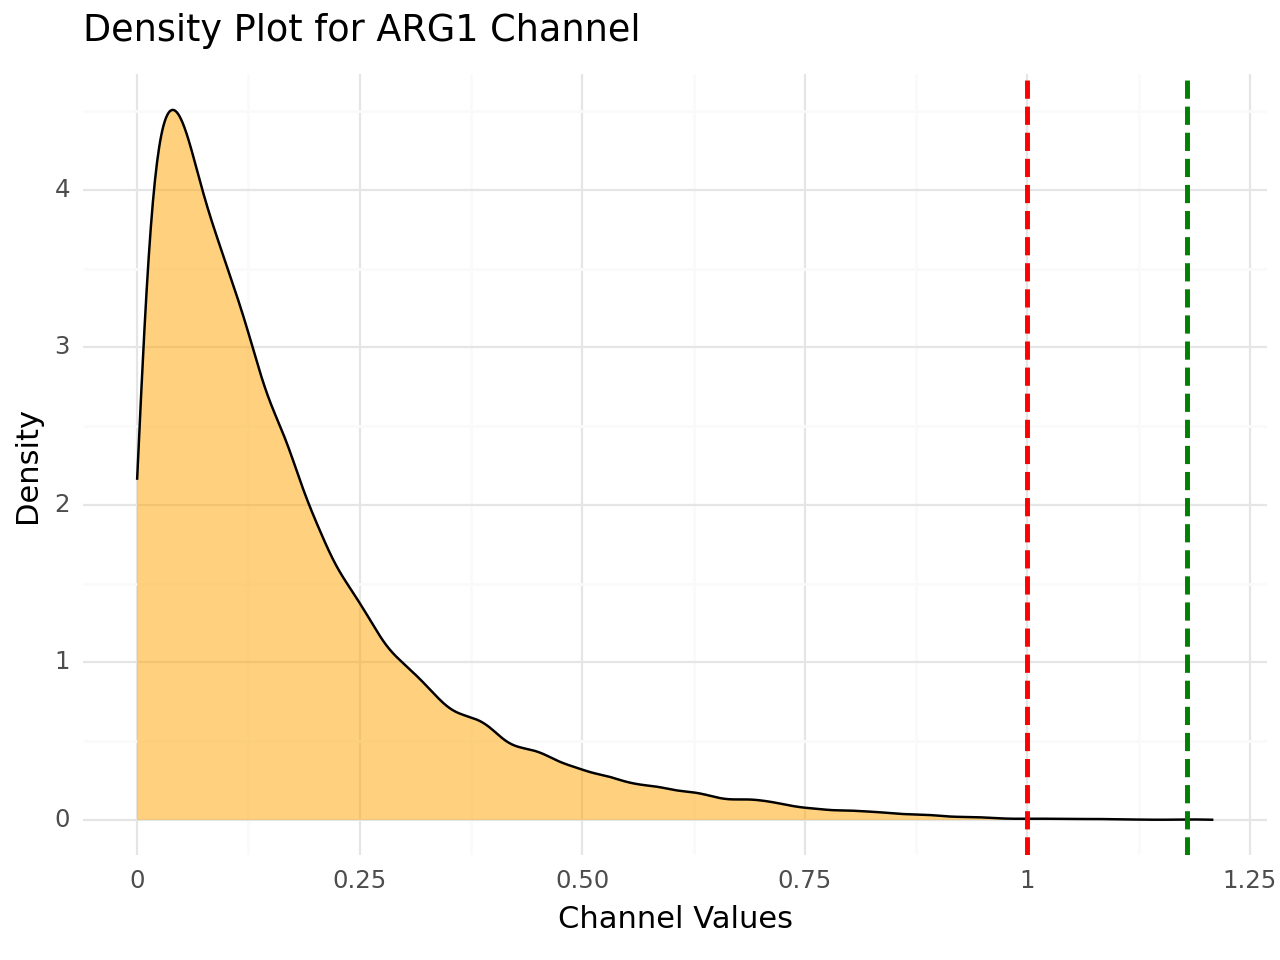

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_ASCT2.png


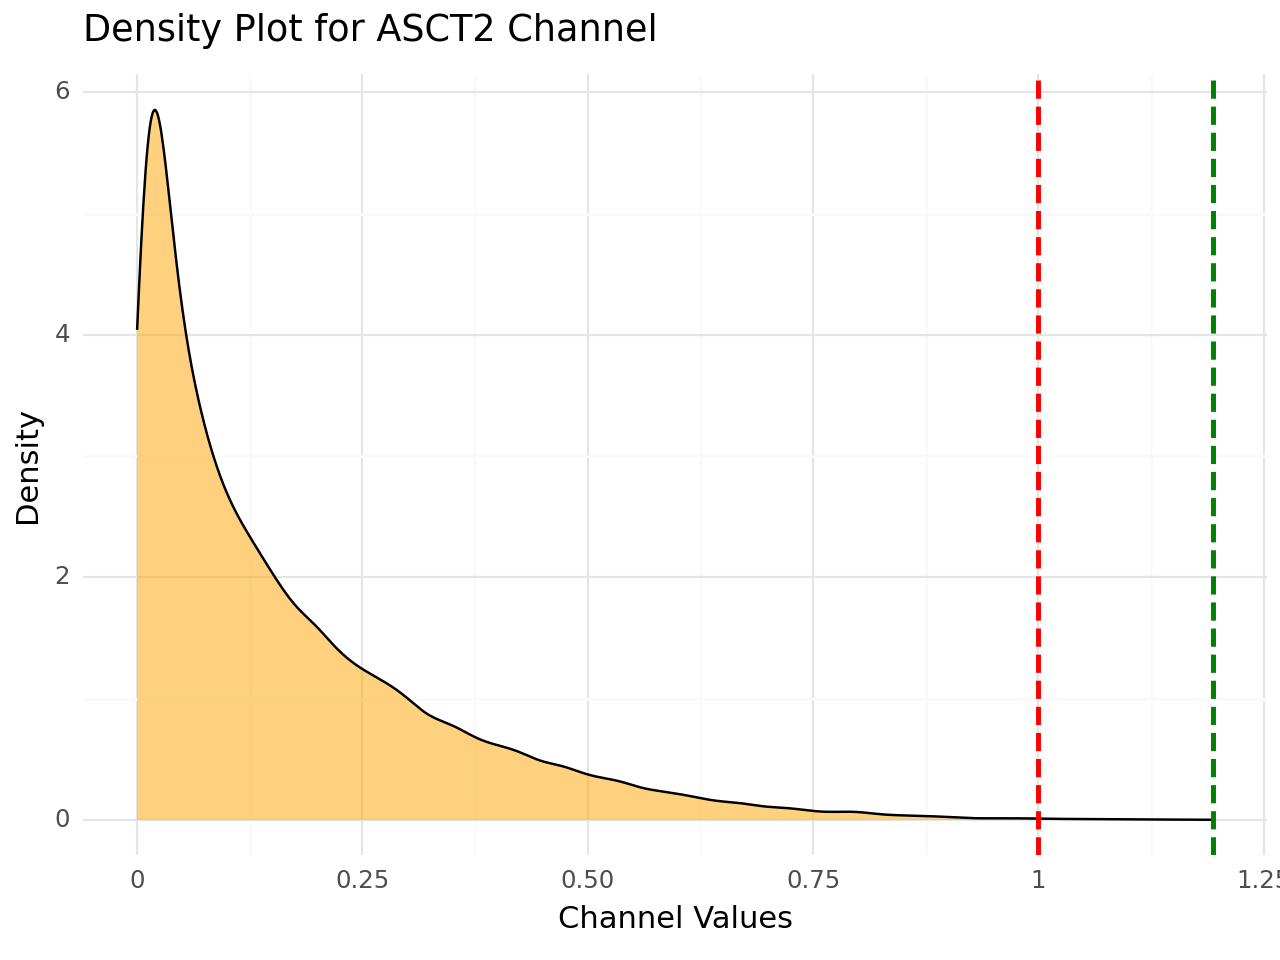

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_ATP5A.png


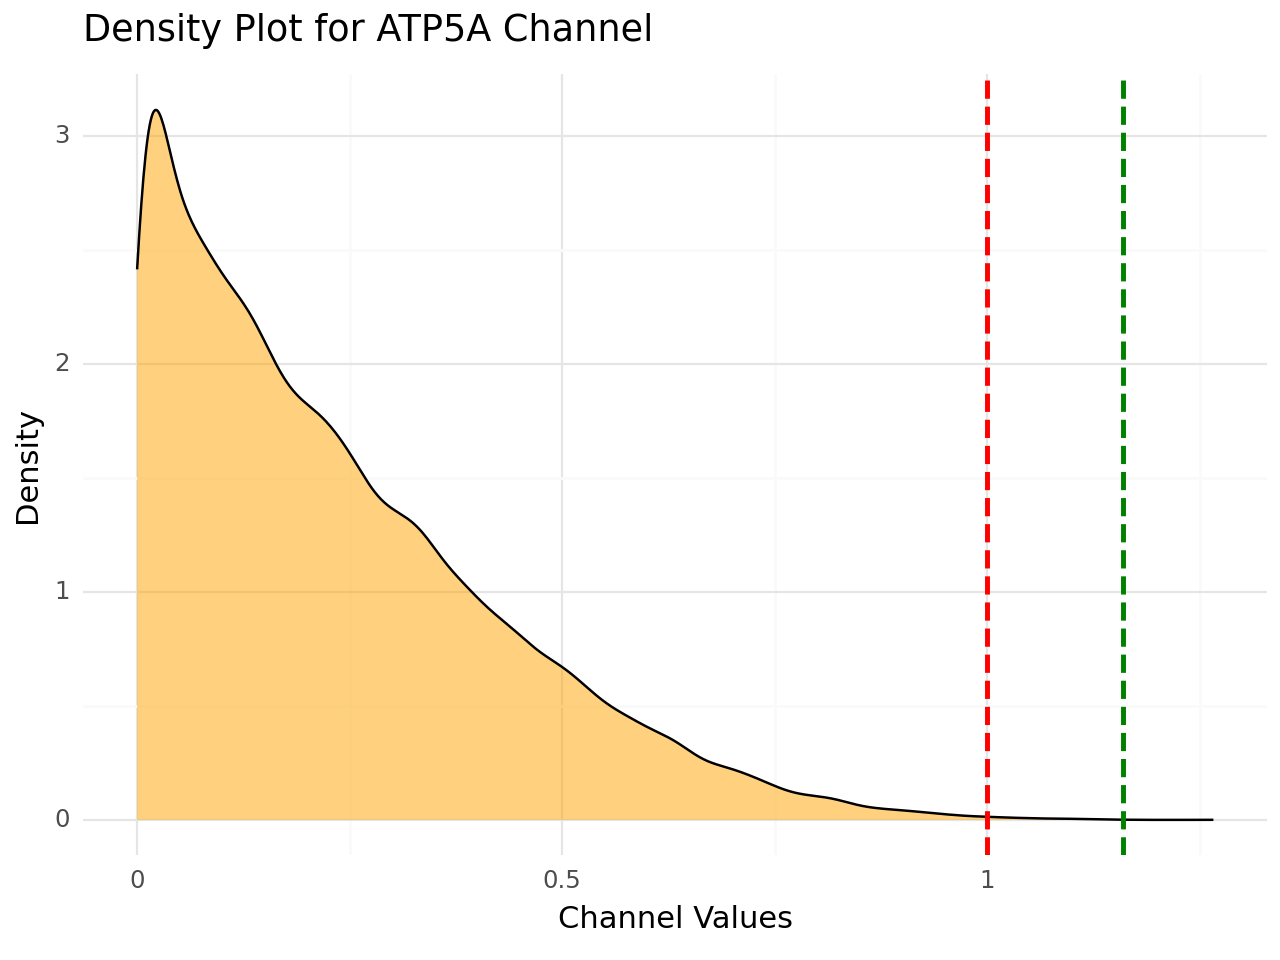

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CA9.png


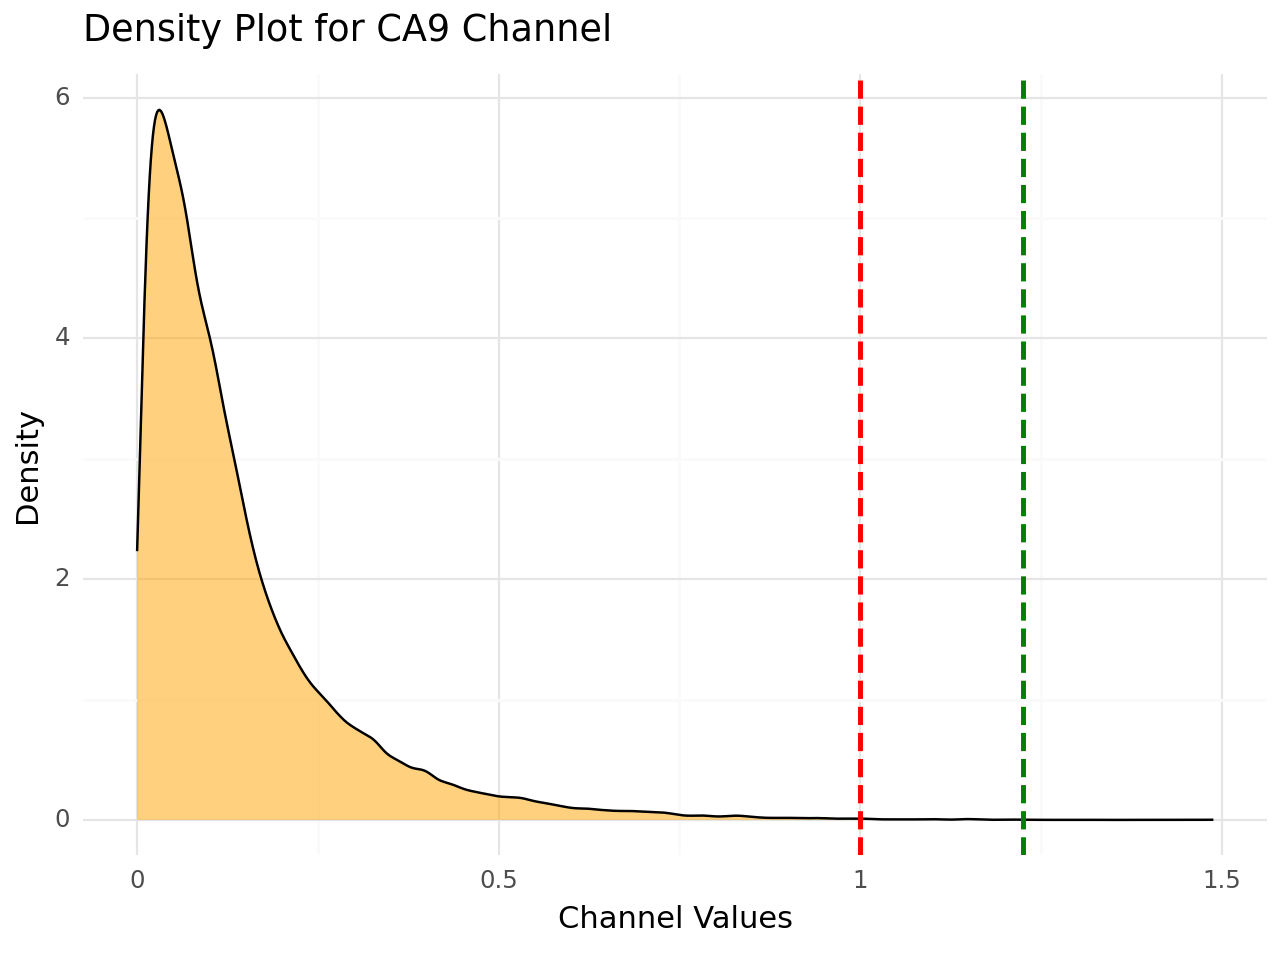

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD14.png


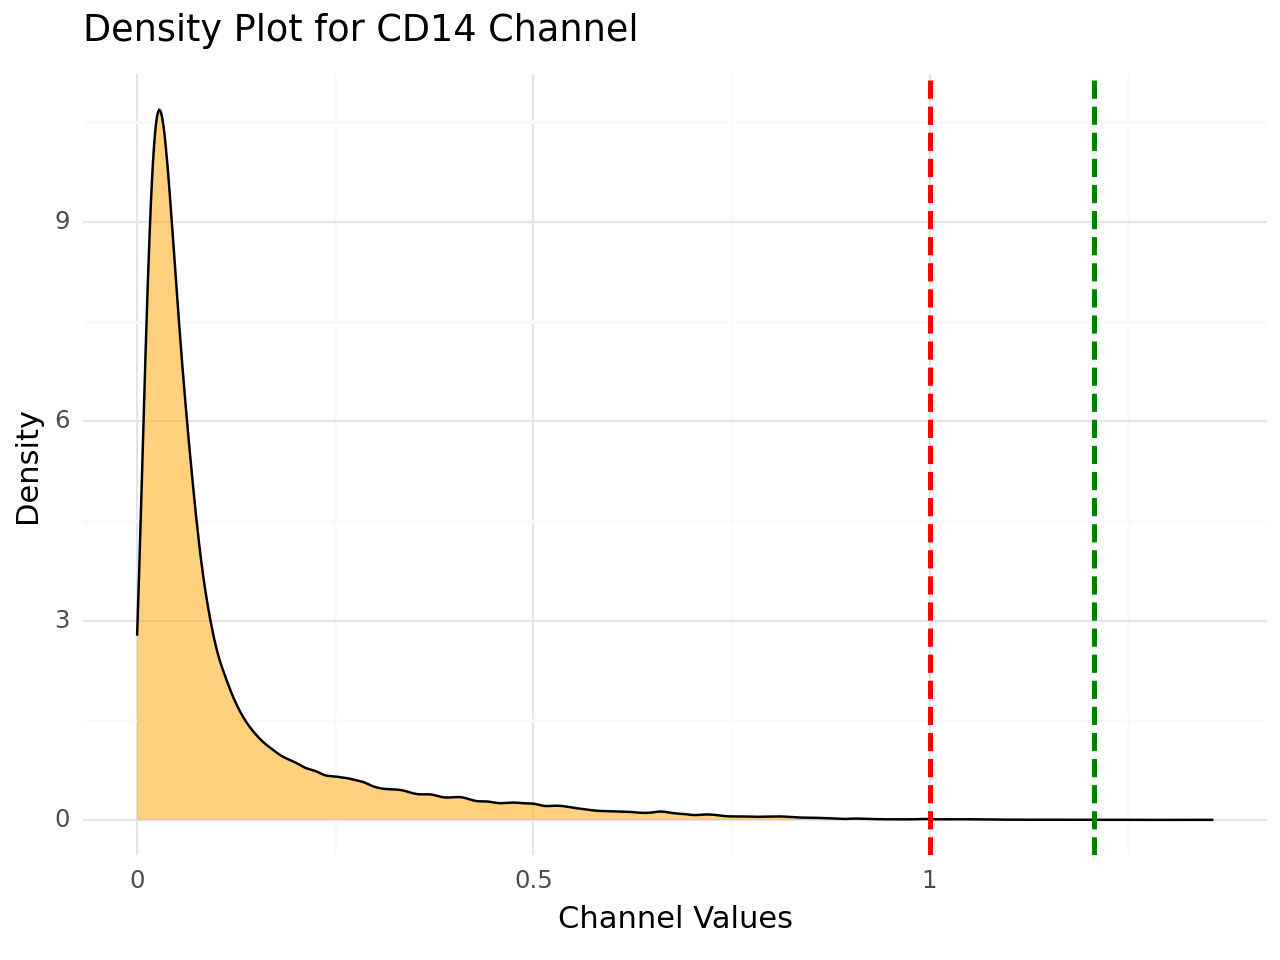

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD163.png


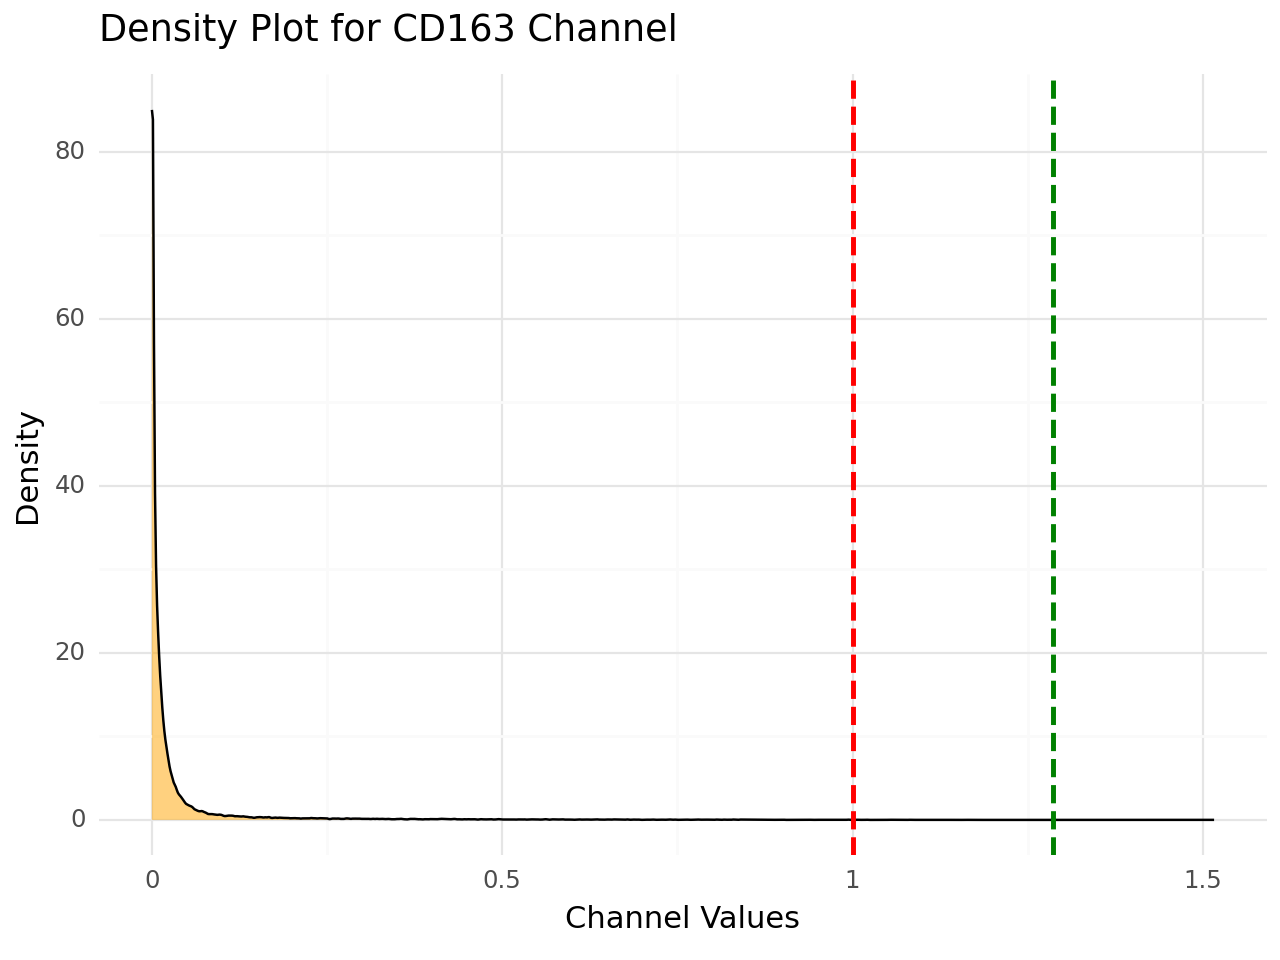

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_STING1.png


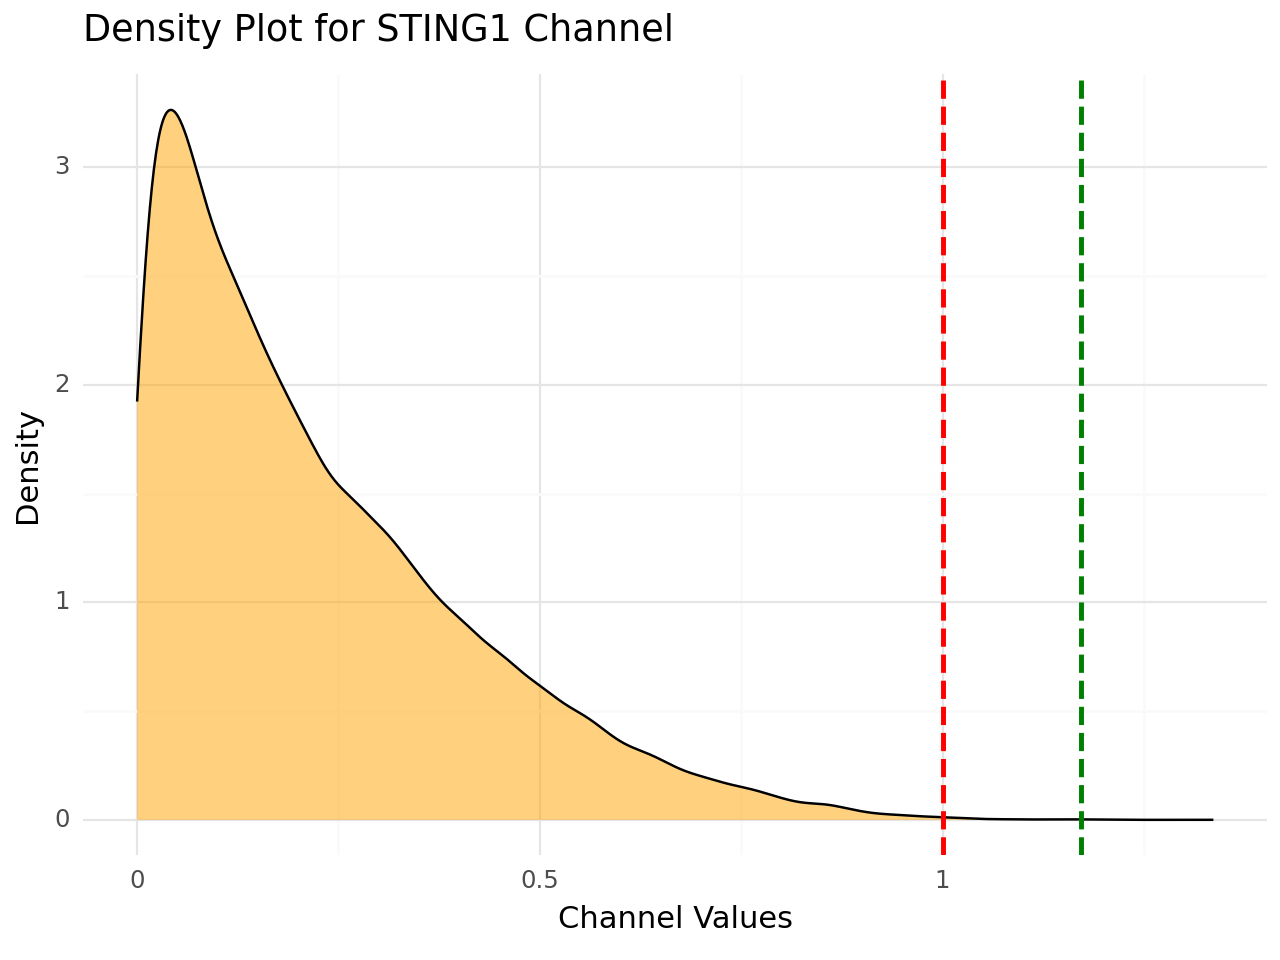

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD20.png


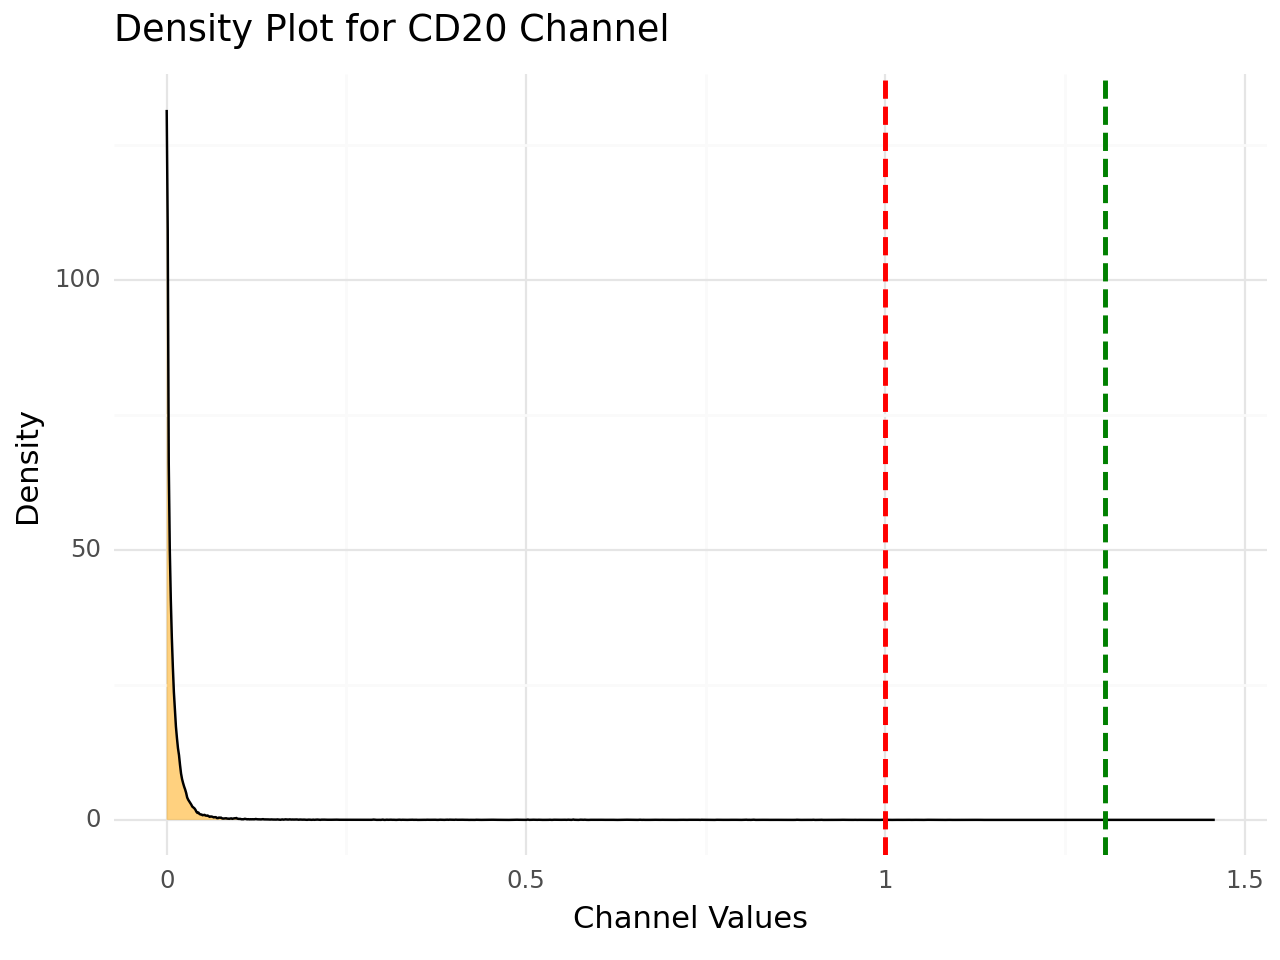

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD3e.png


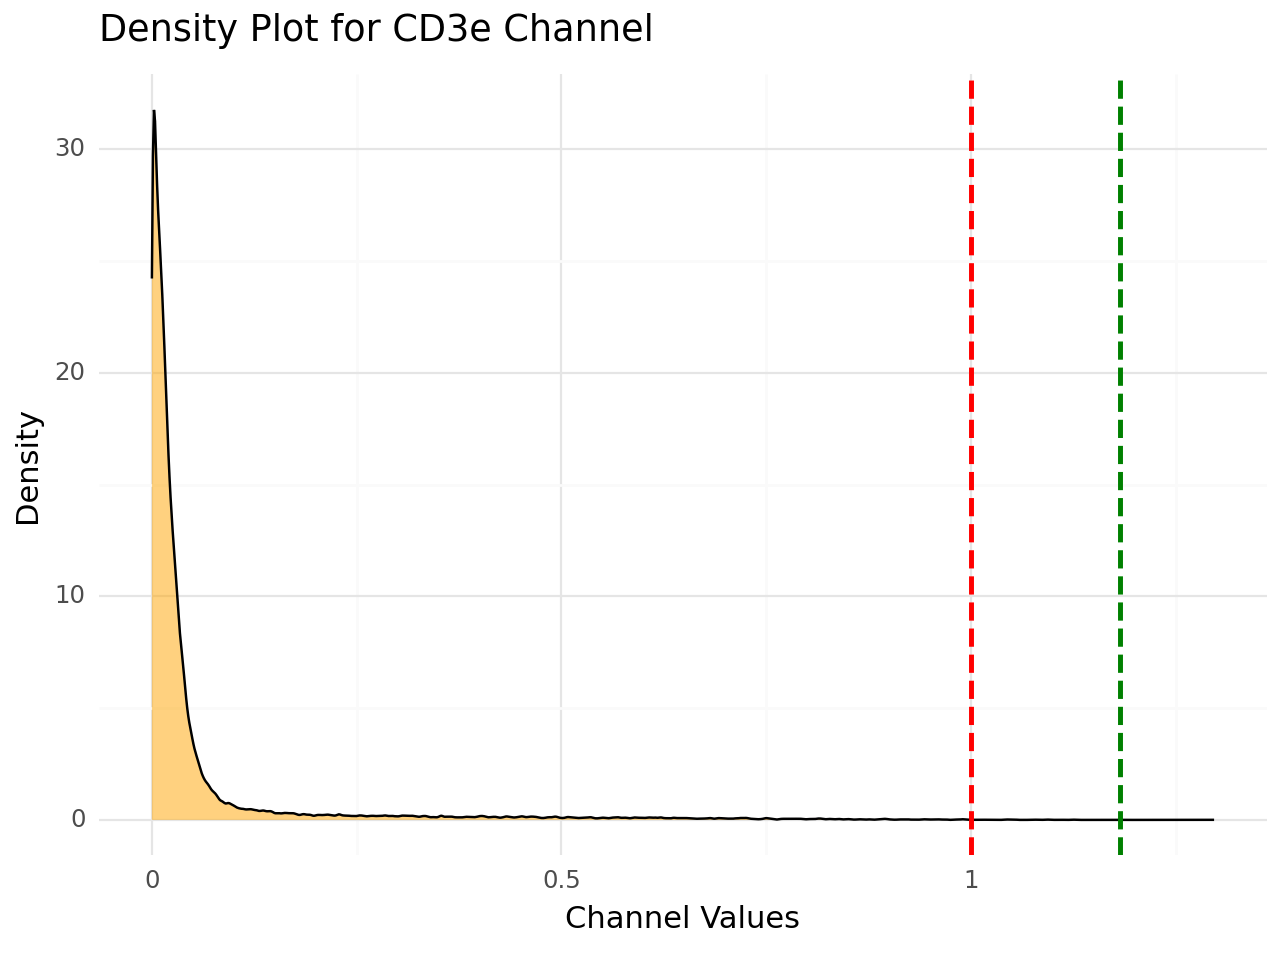

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD31.png


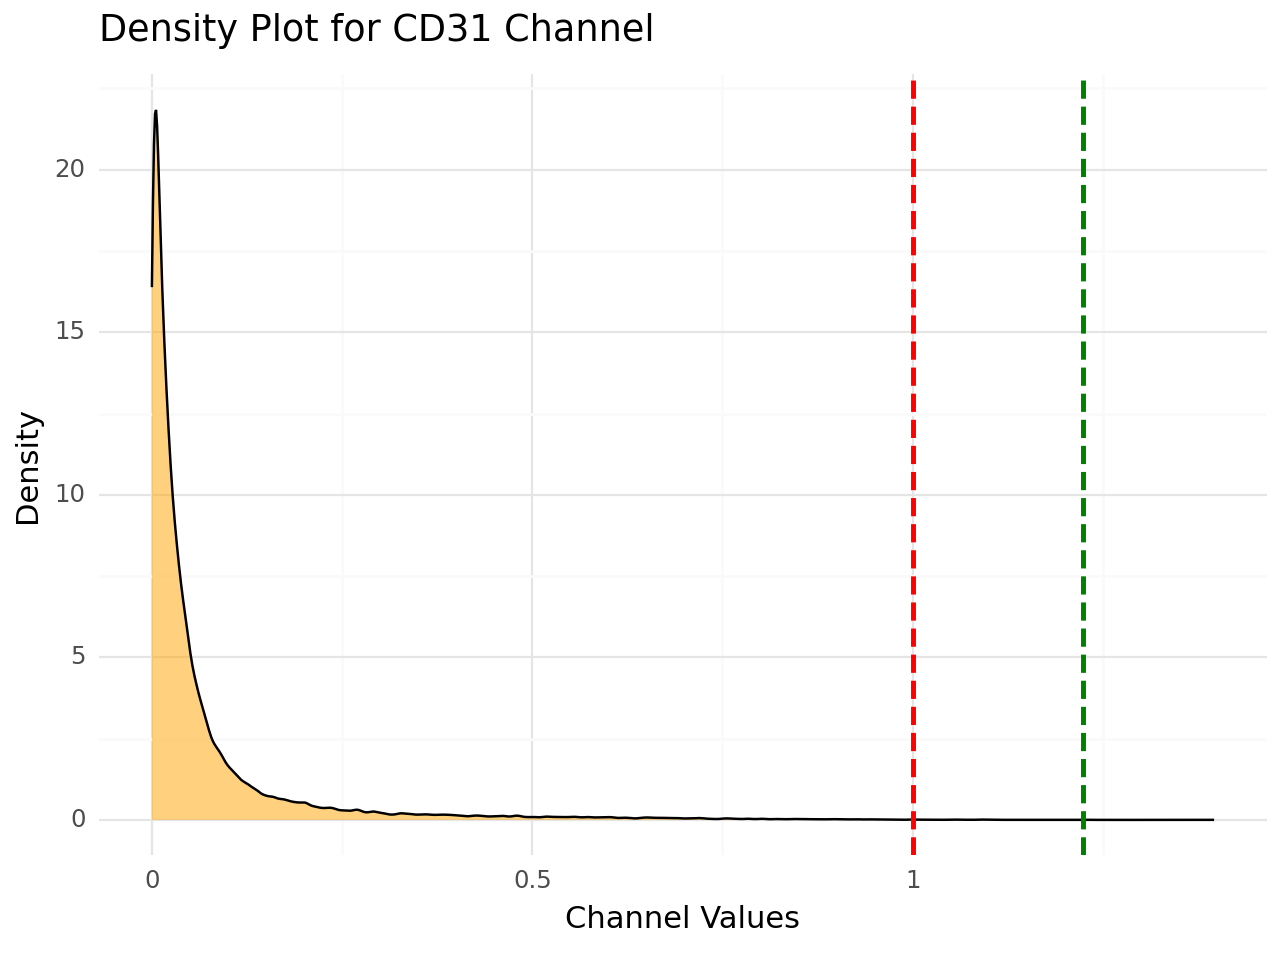

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD4.png


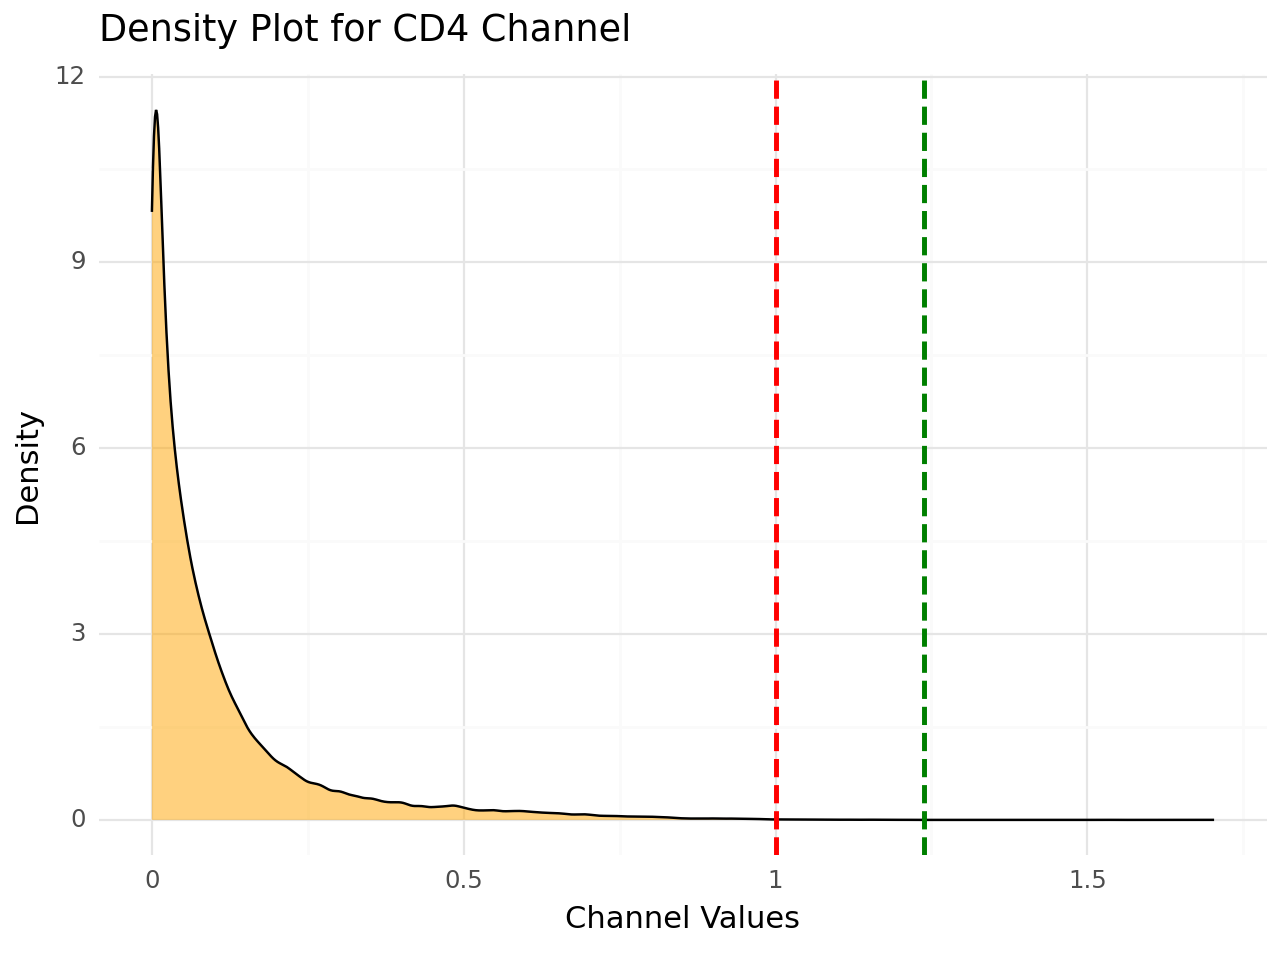

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD45.png


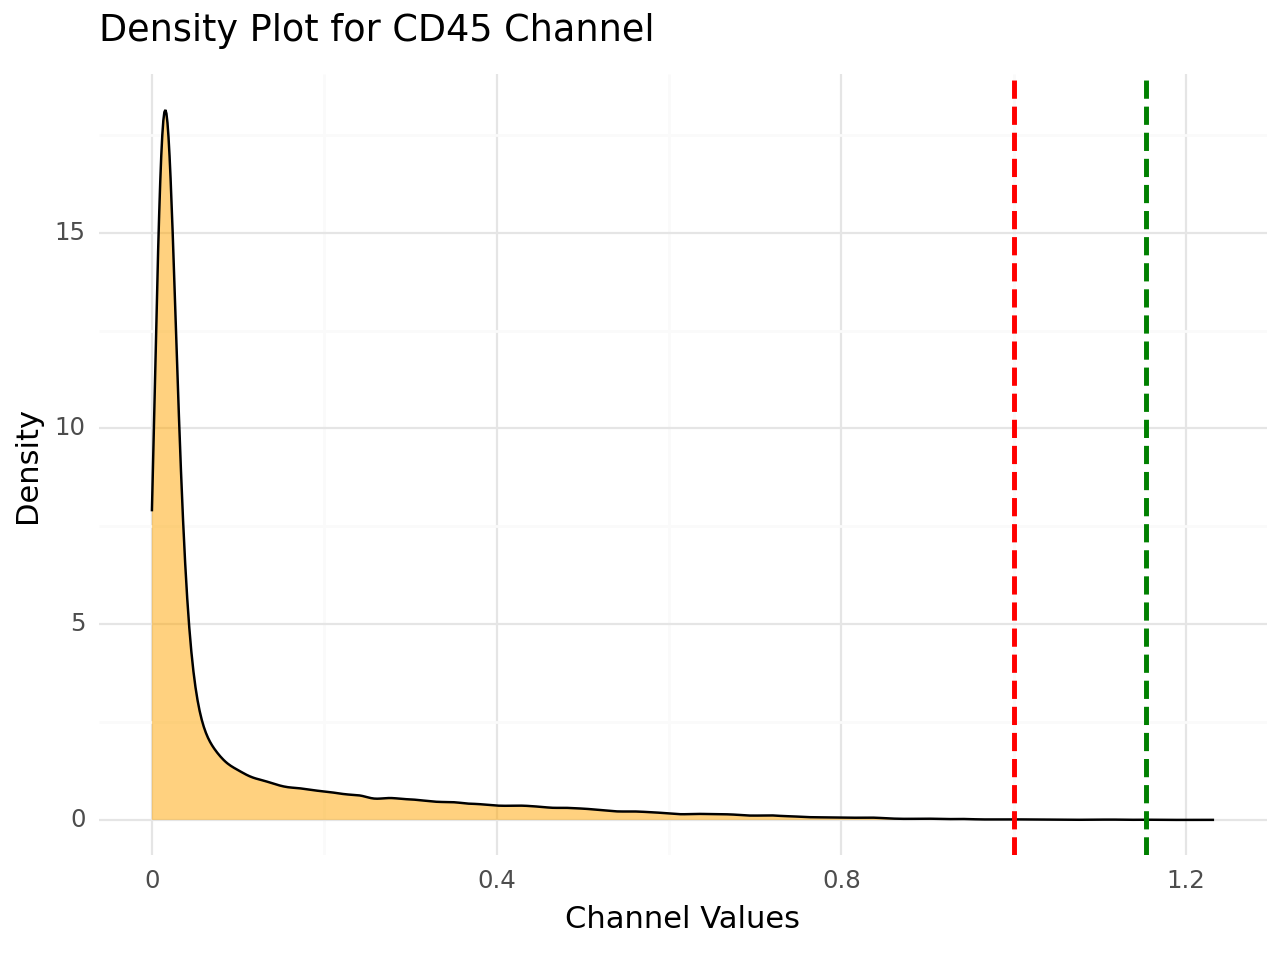

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD68.png


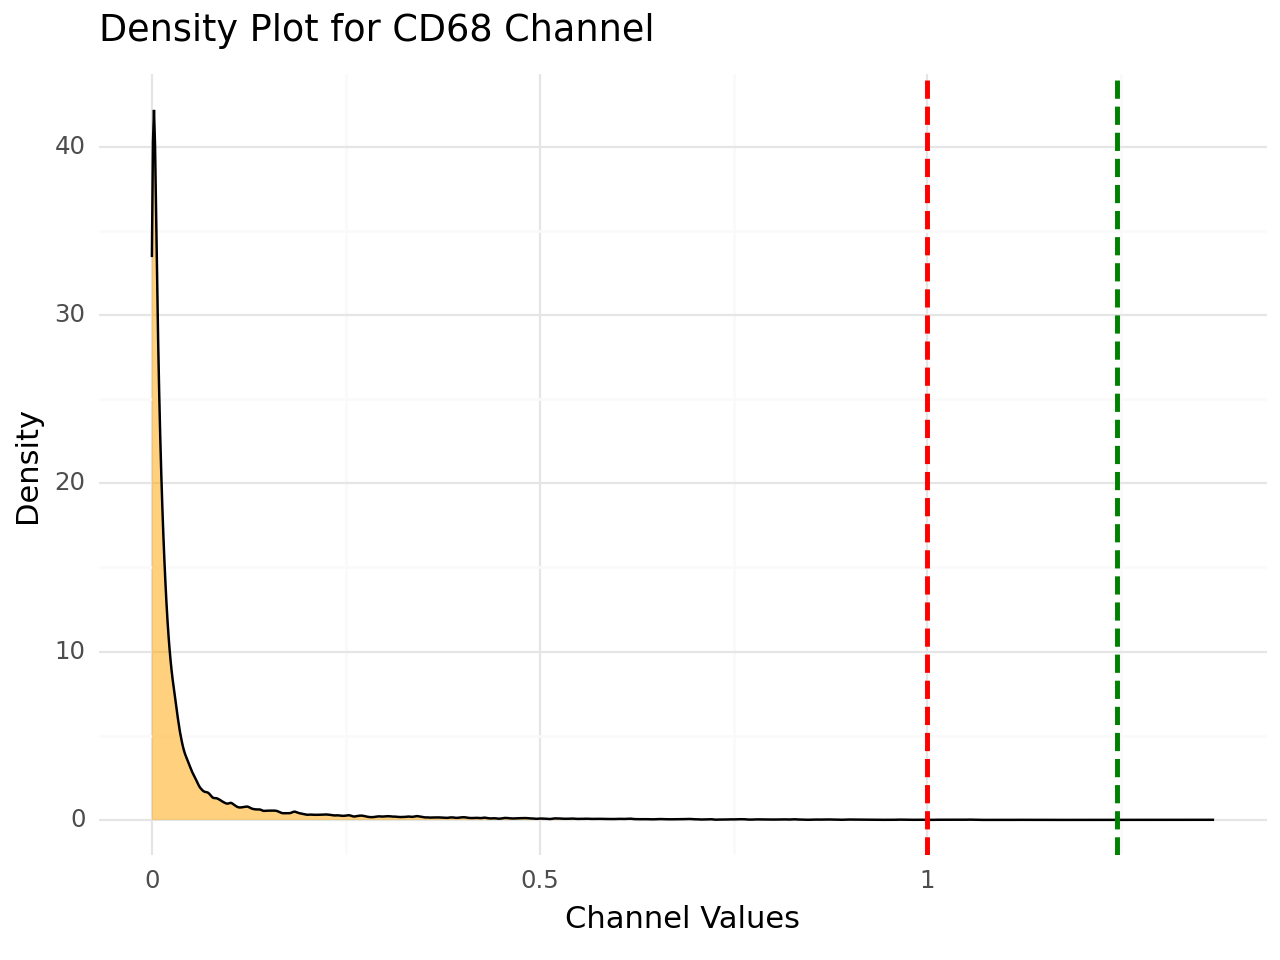

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD7.png


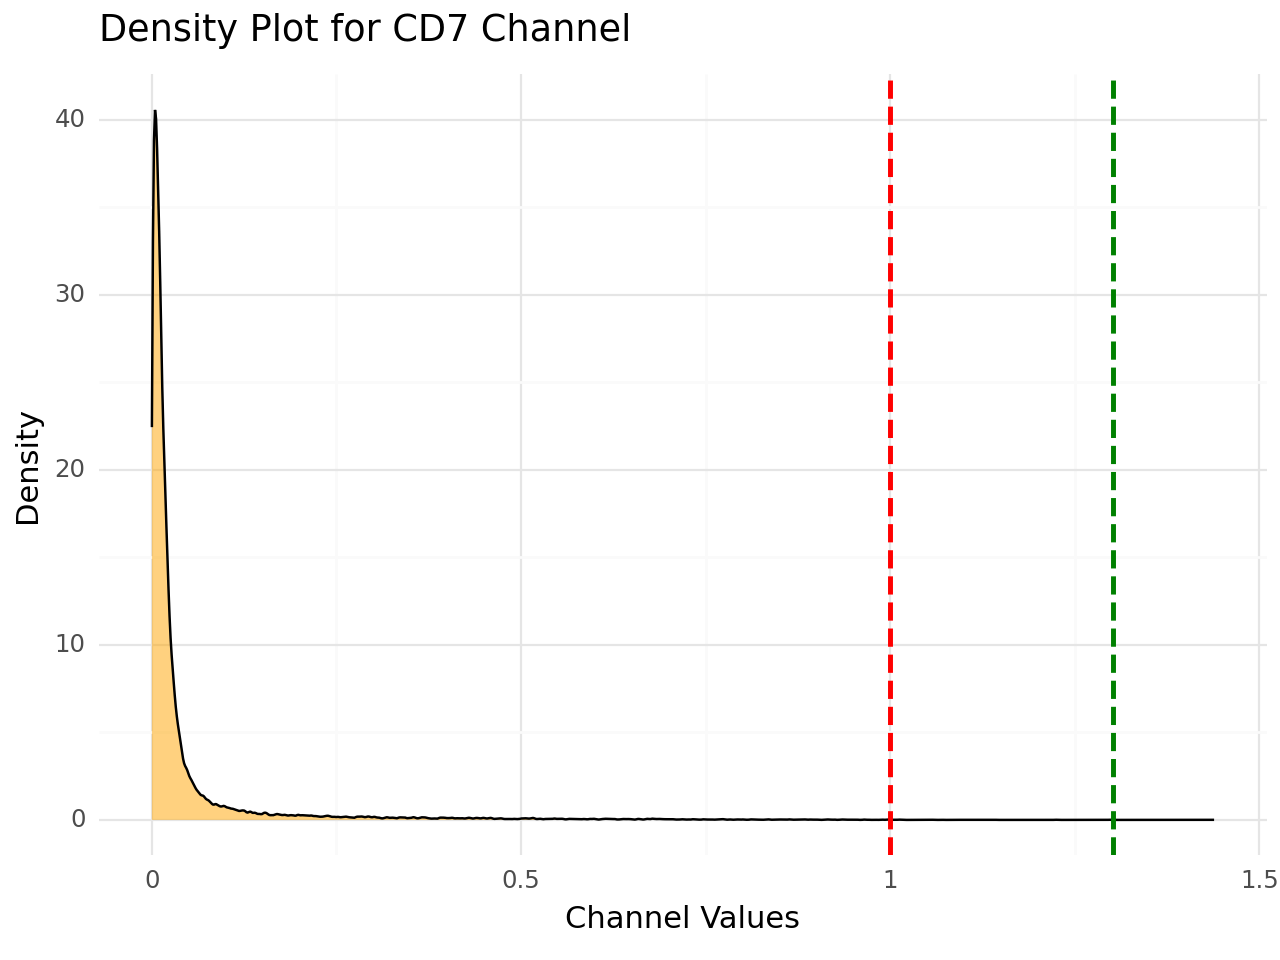

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD8.png


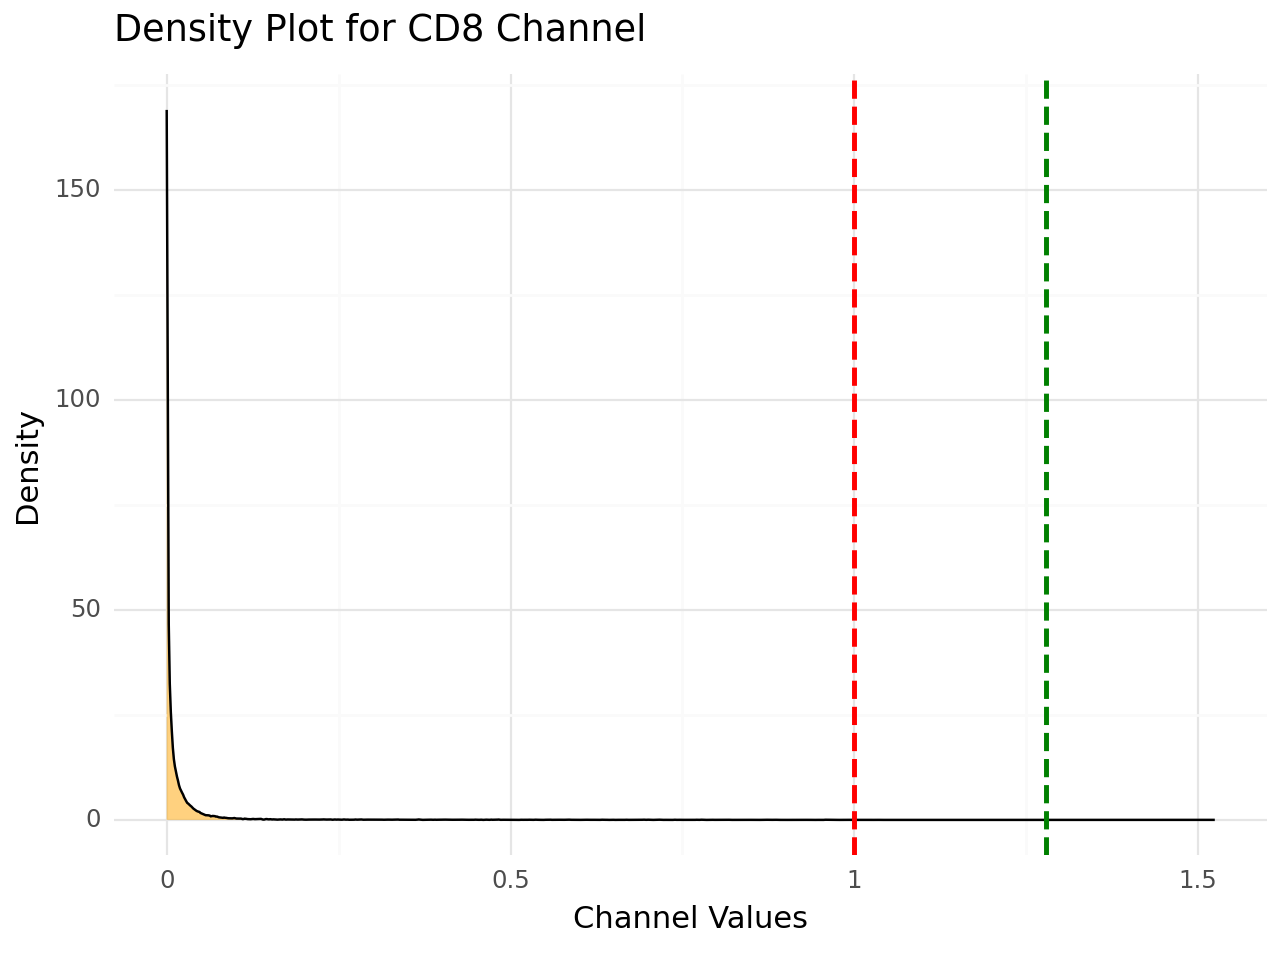

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CD98.png


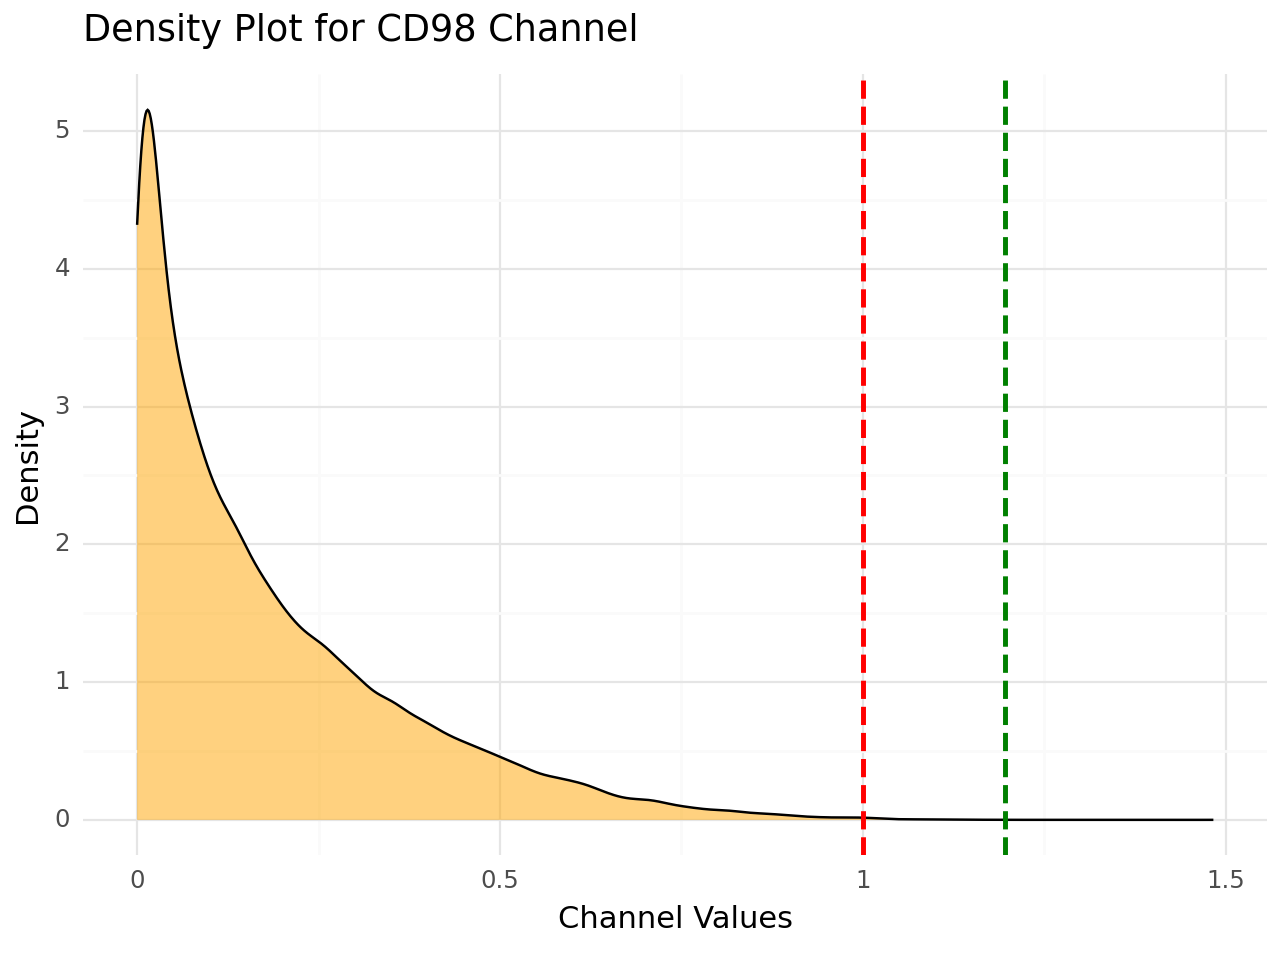

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CPT1A.png


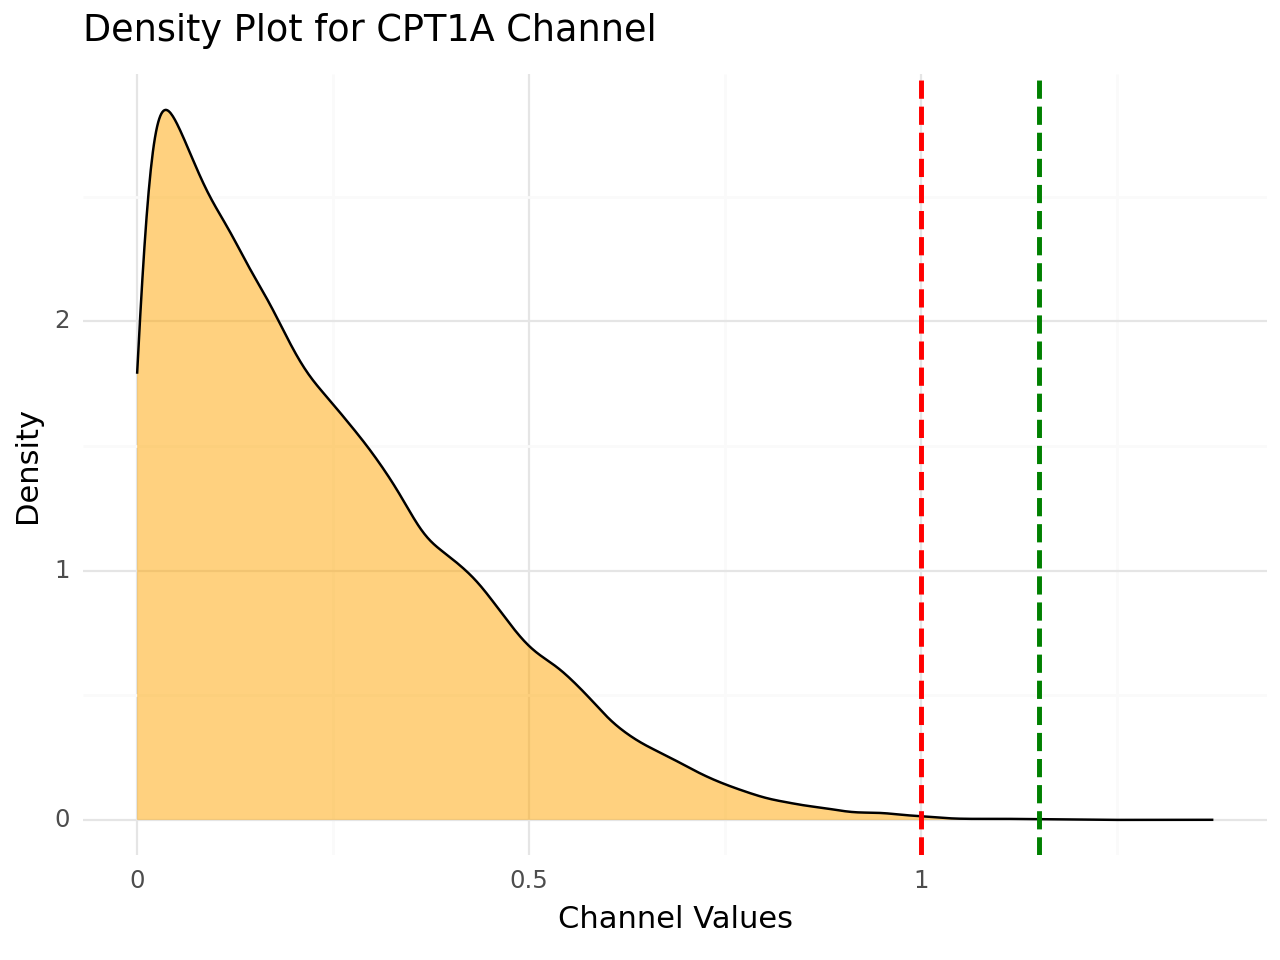

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CS.png


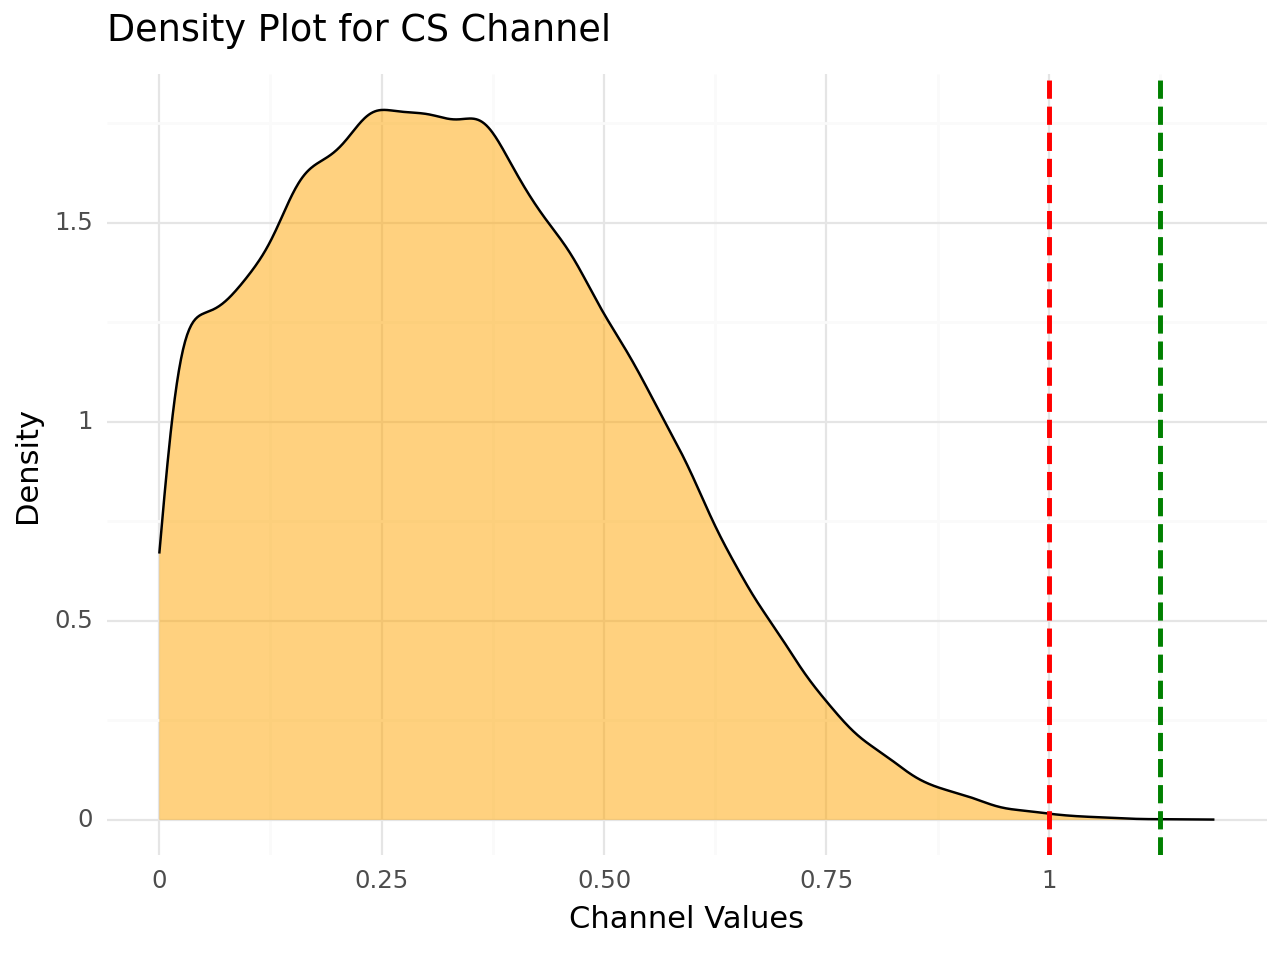

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_DCN.png


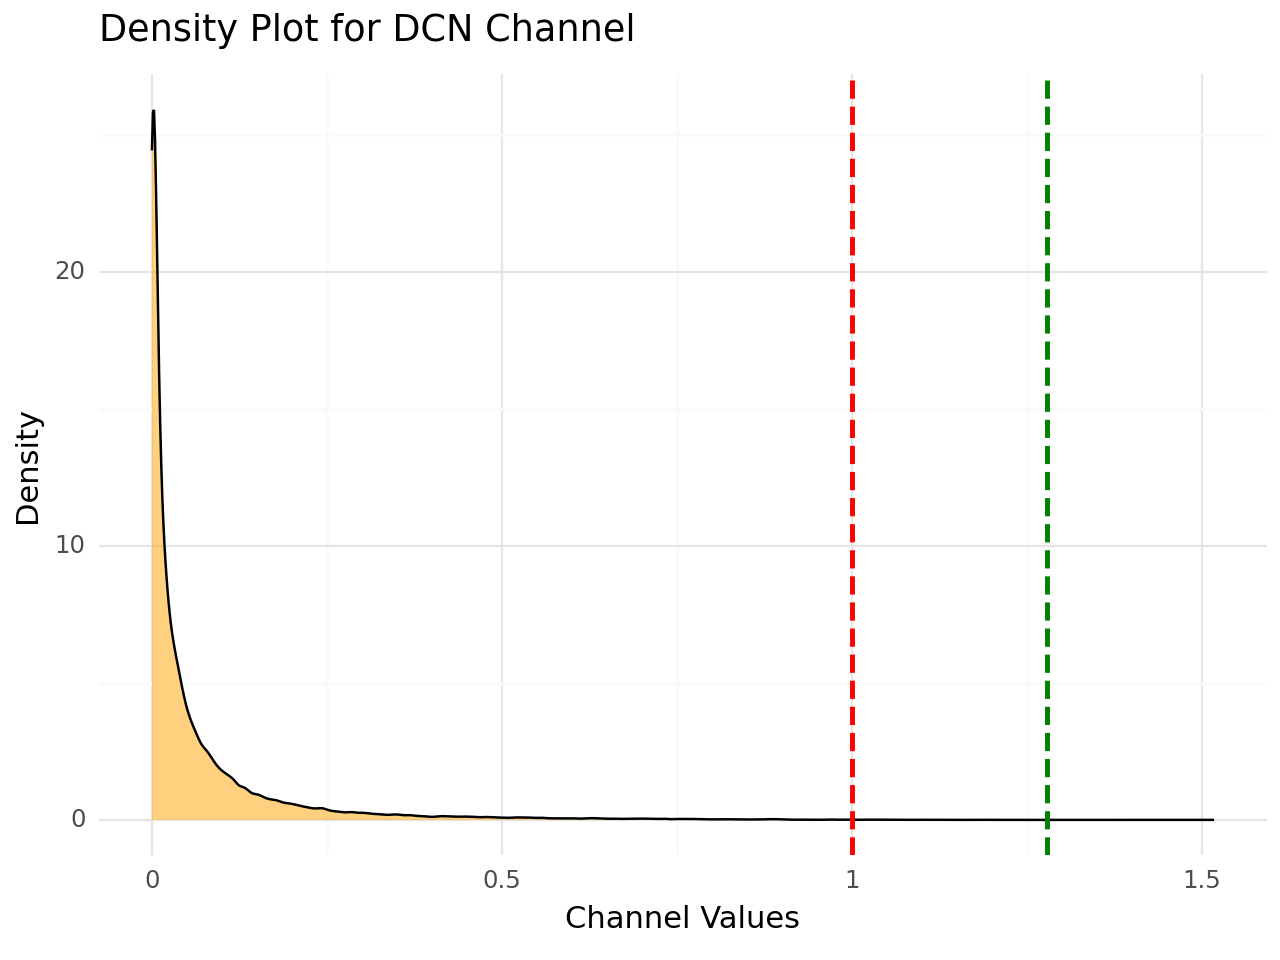

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_GS.png


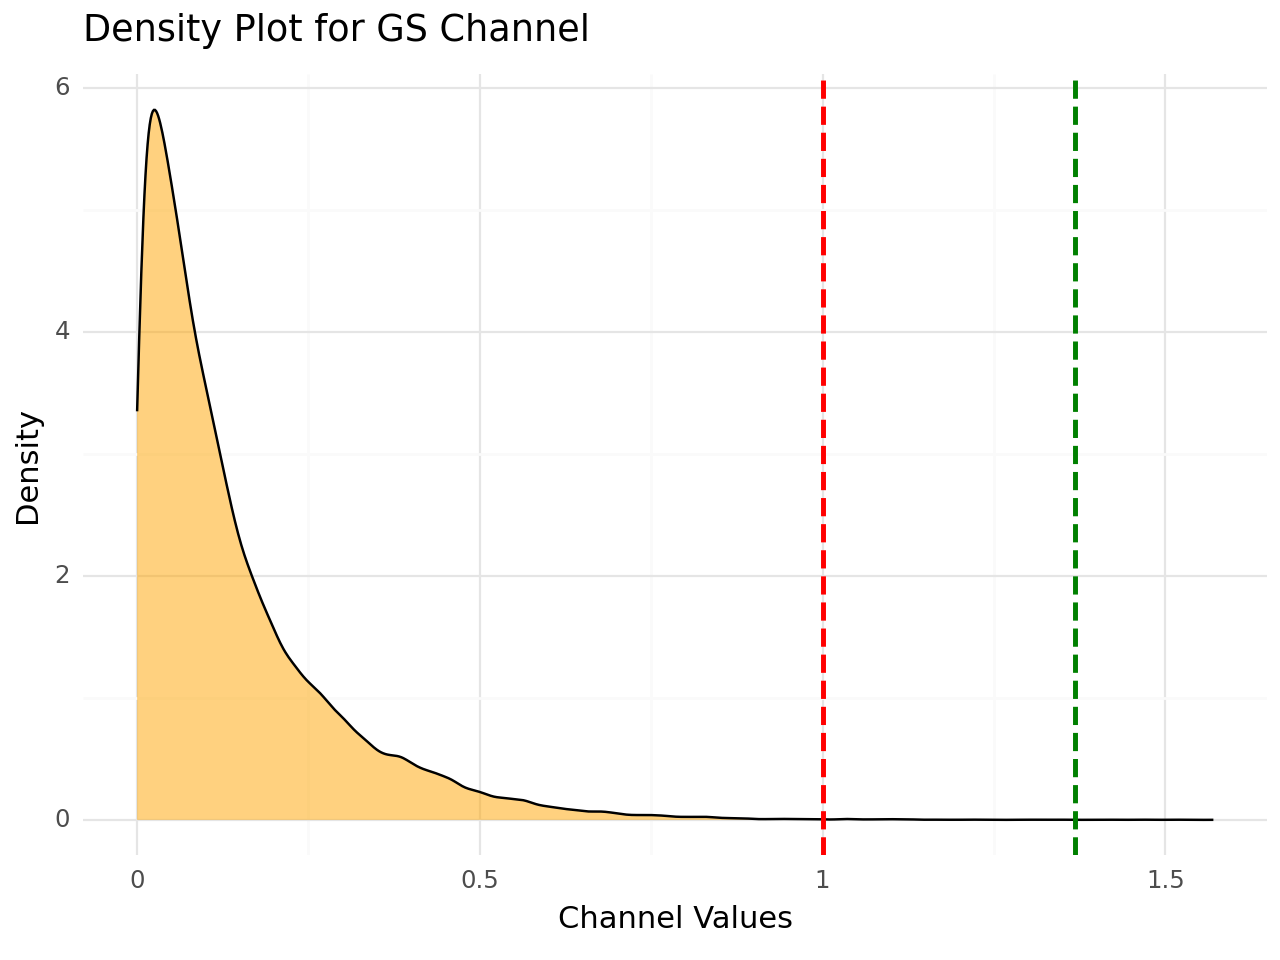

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_MPO.png


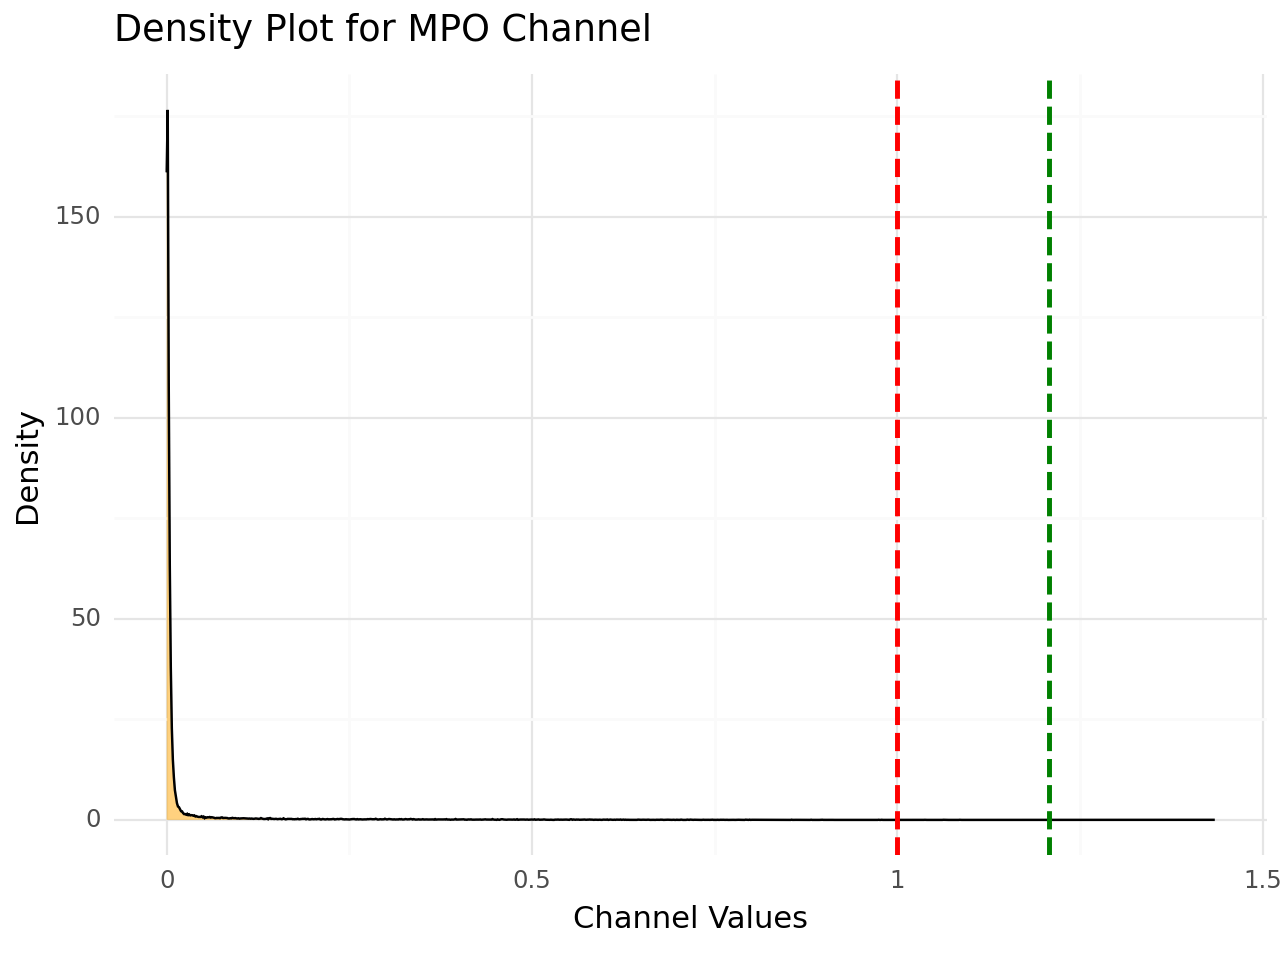

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_MSH2.png


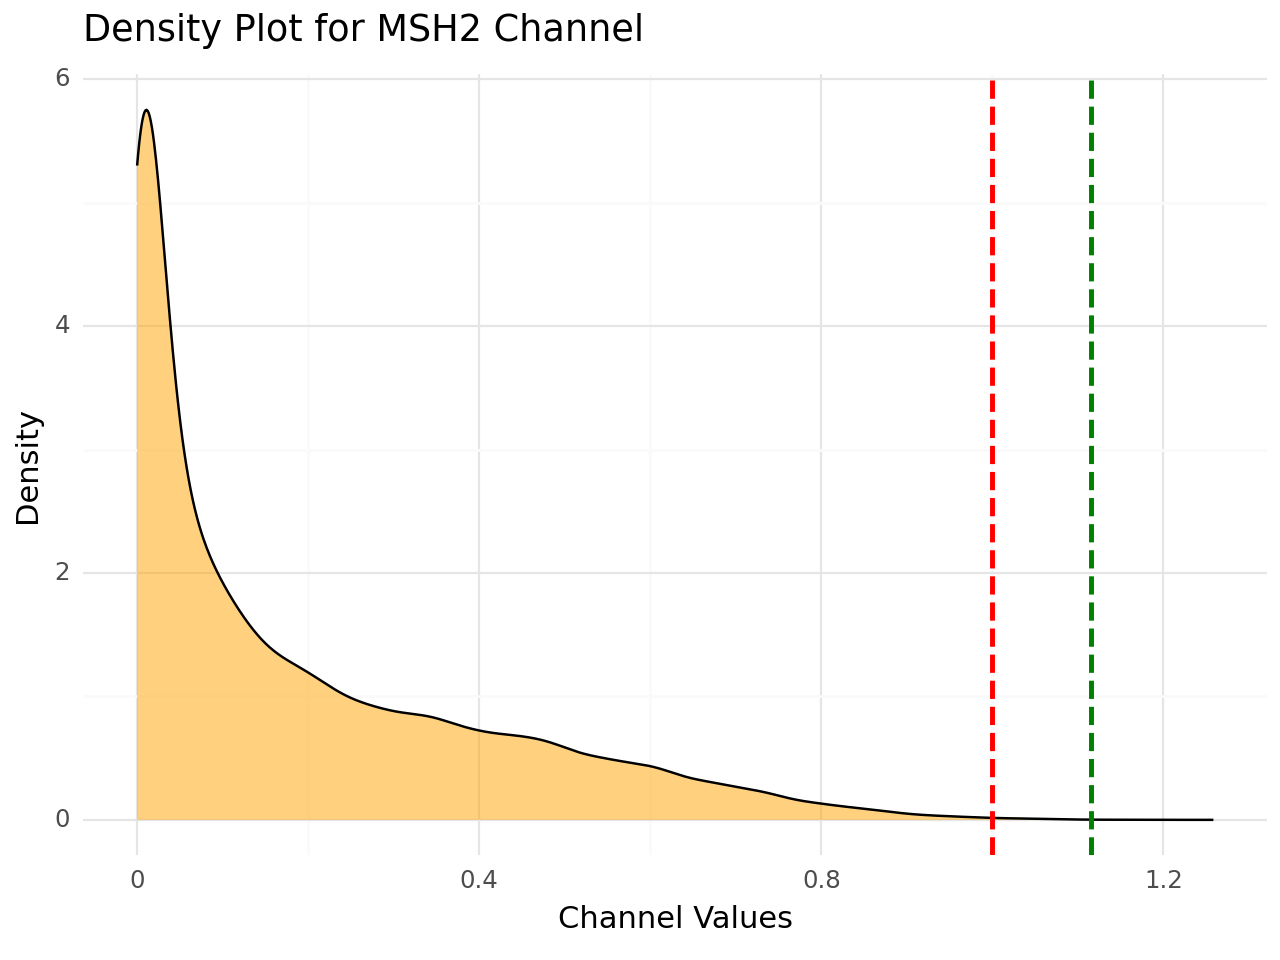

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_MSH6.png


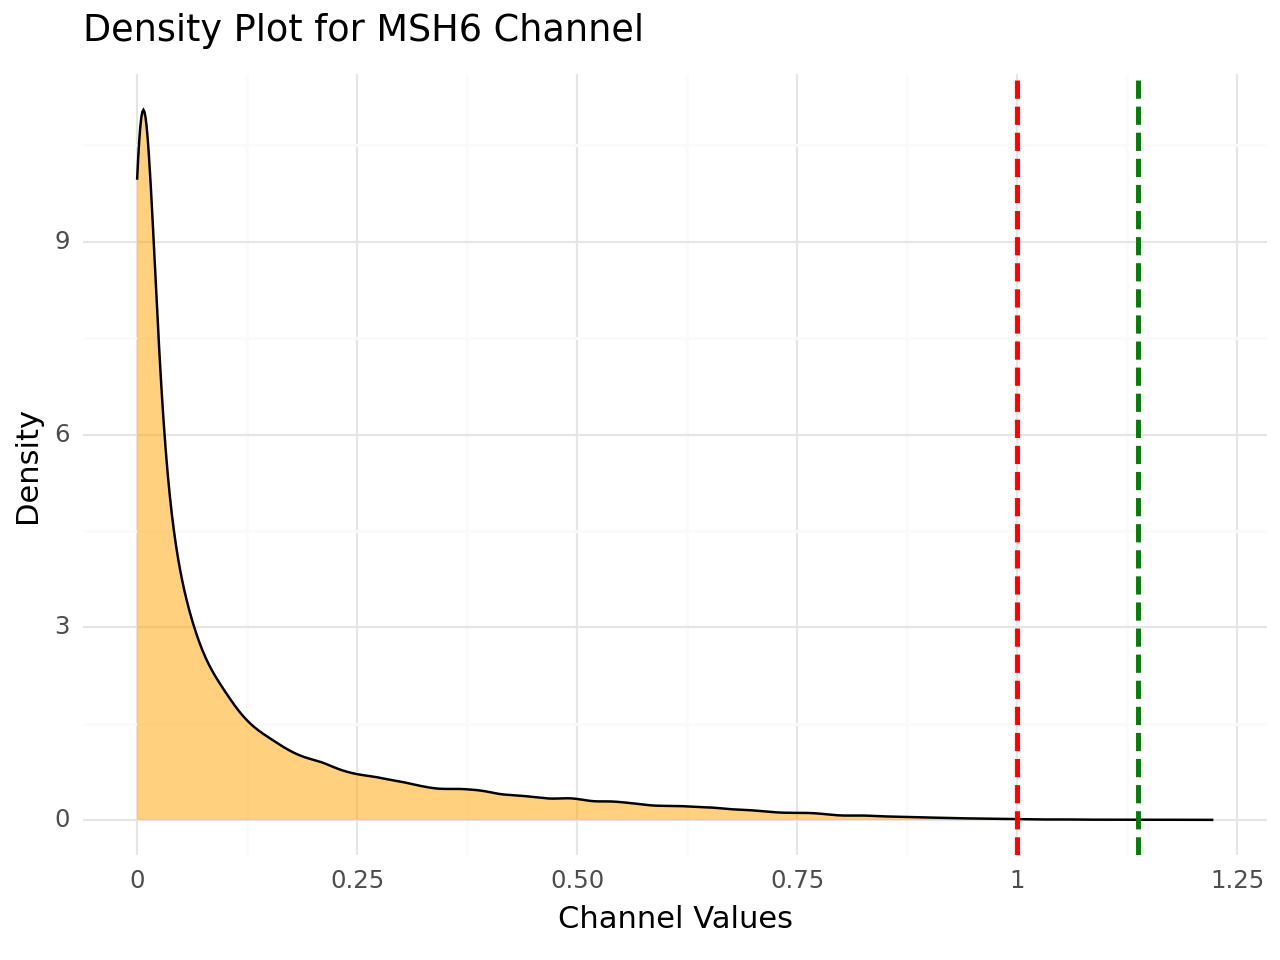

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_CytC.png


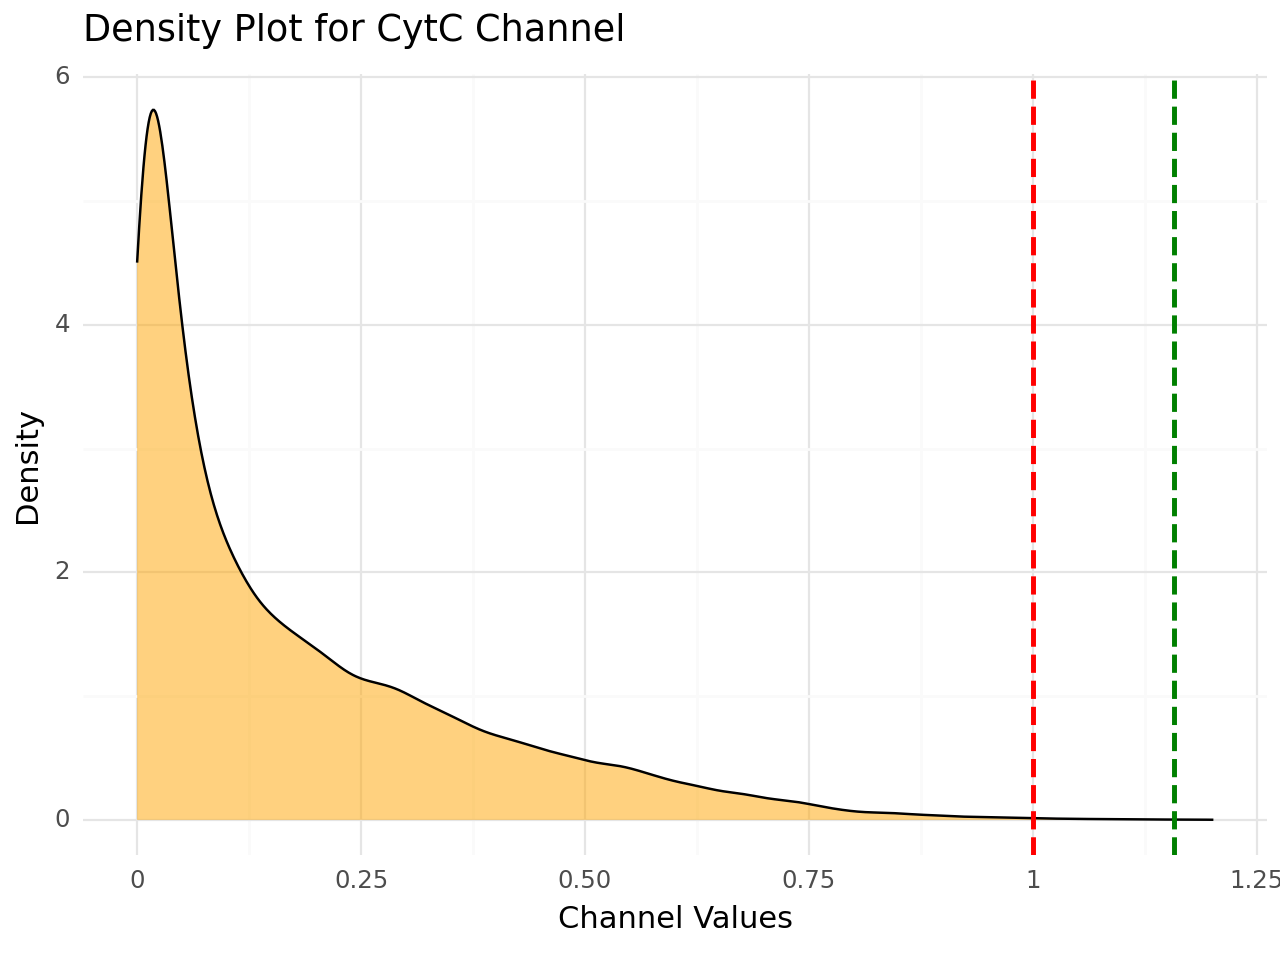

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_FoxP3.png


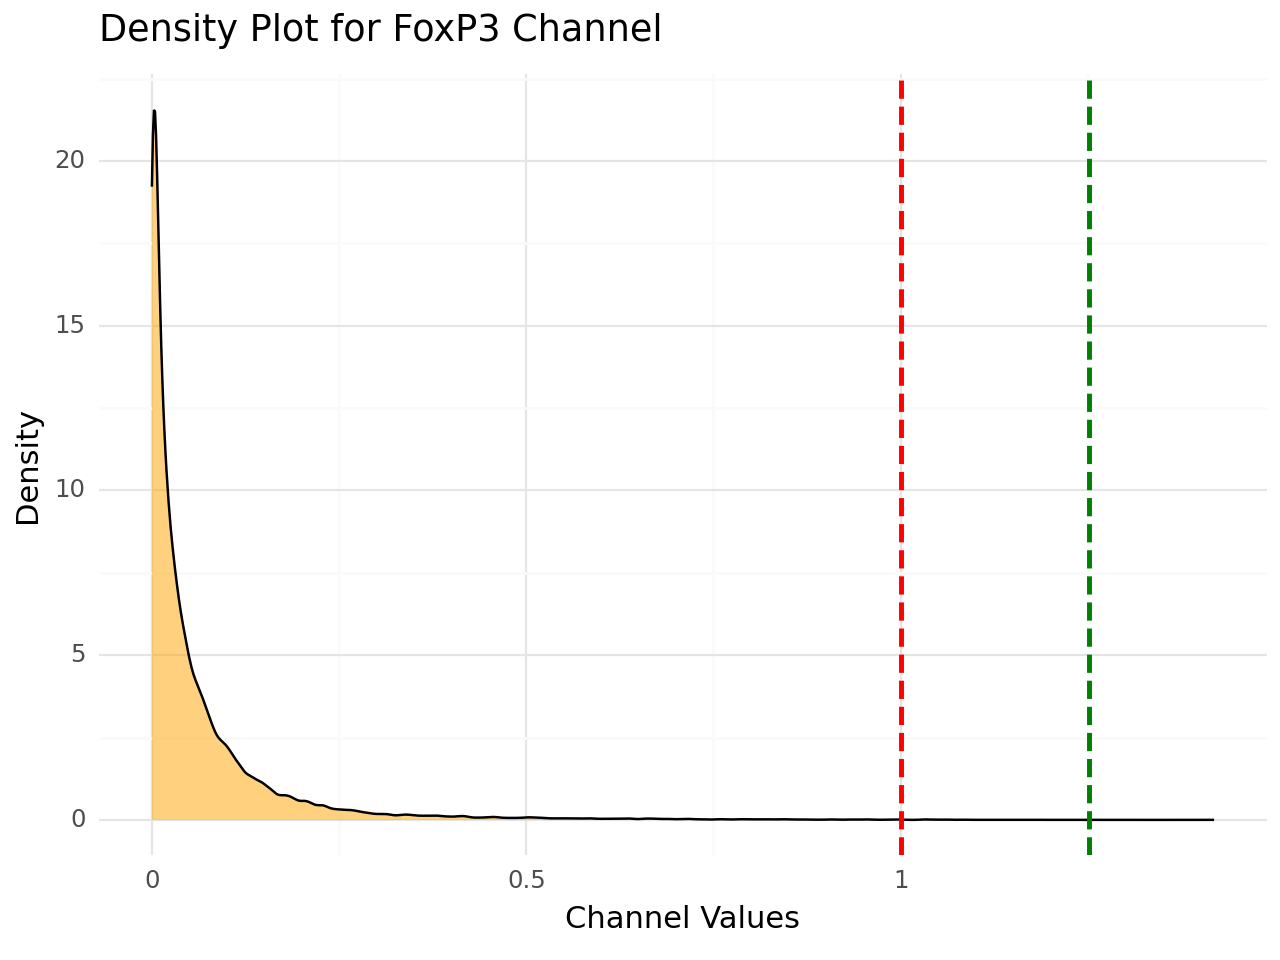

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_GLS.png


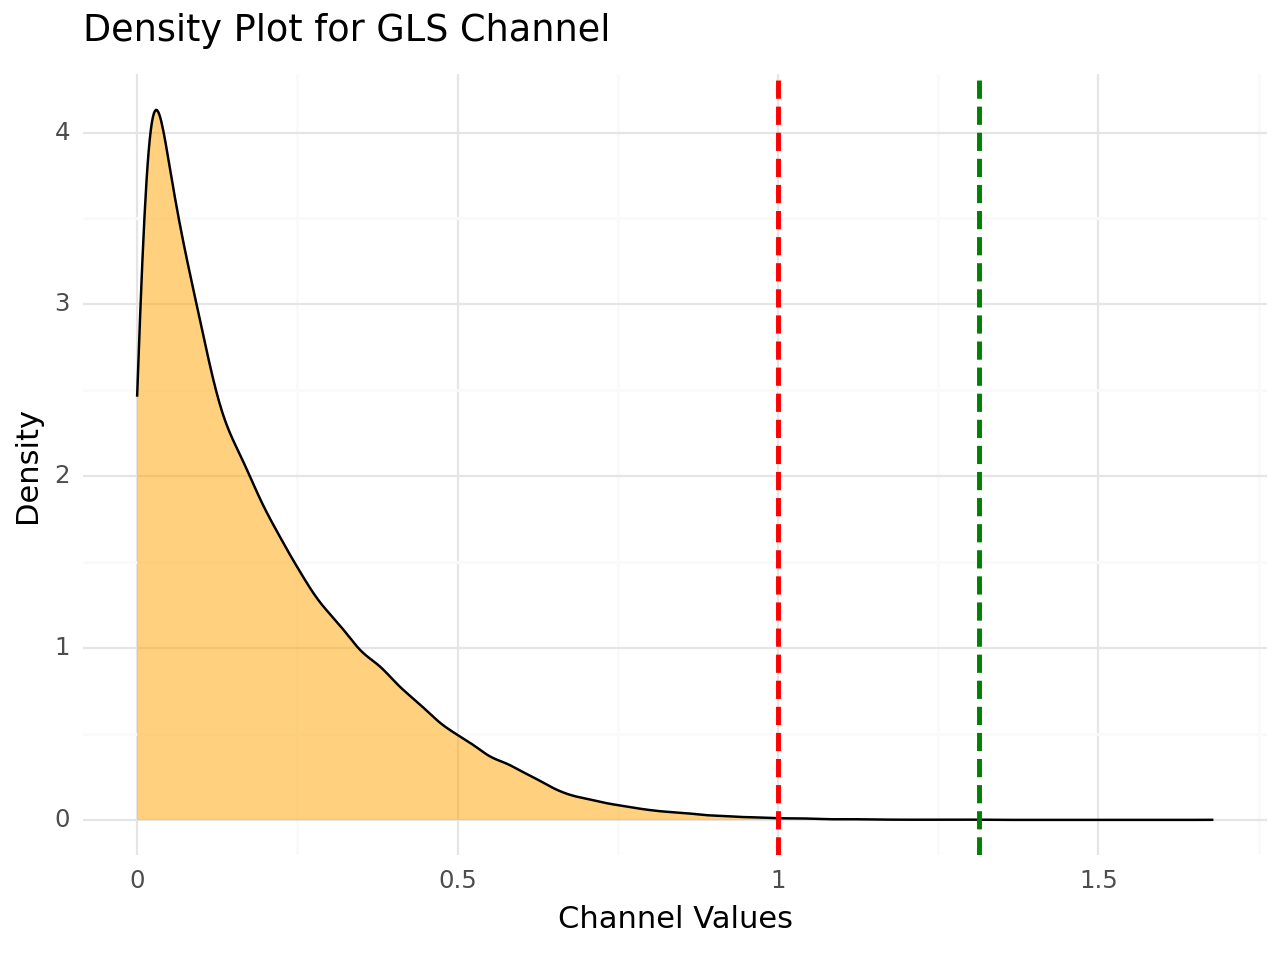

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_GLUT1.png


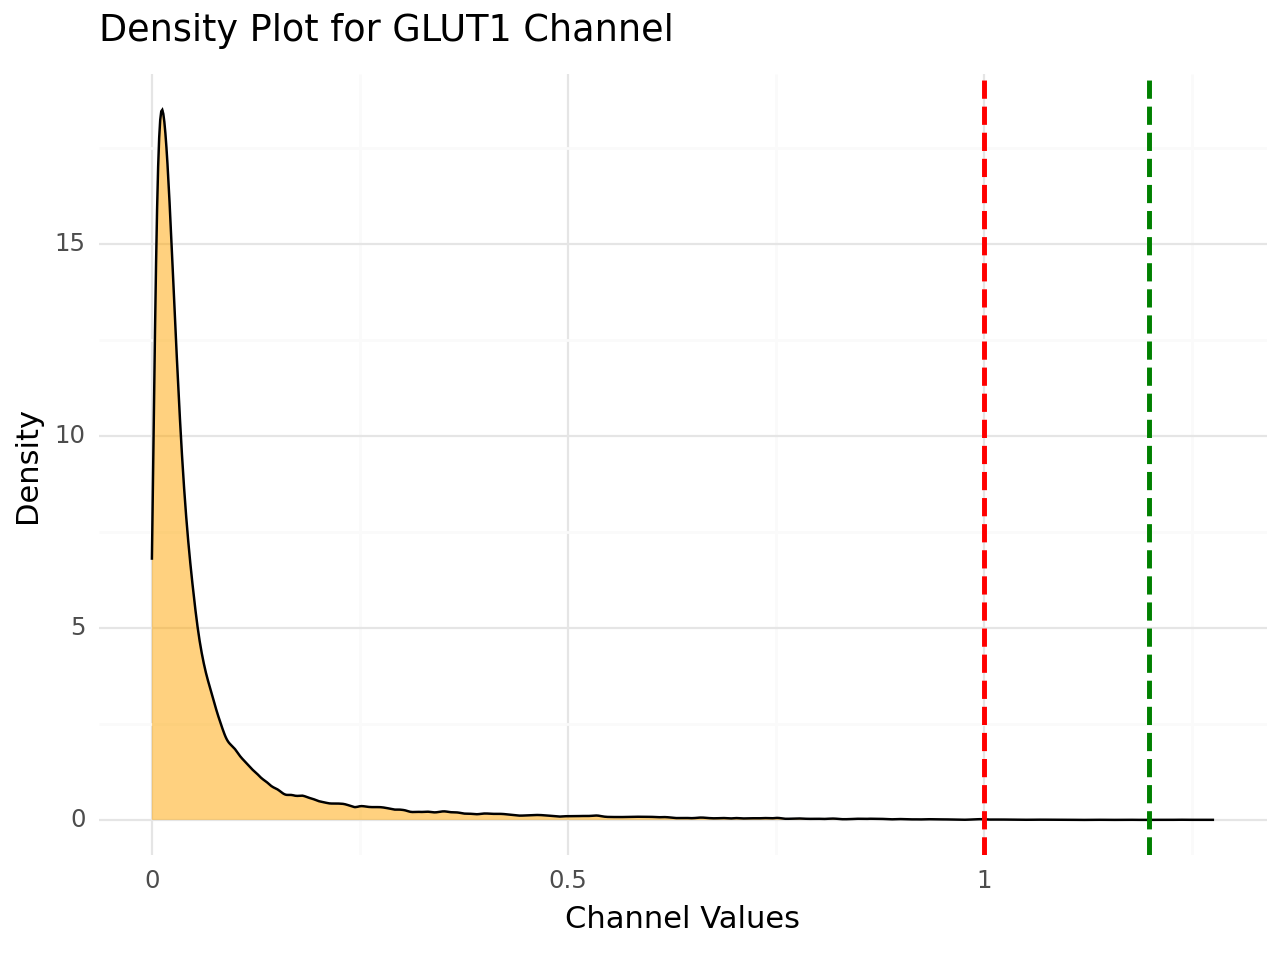

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_HLADRa.png


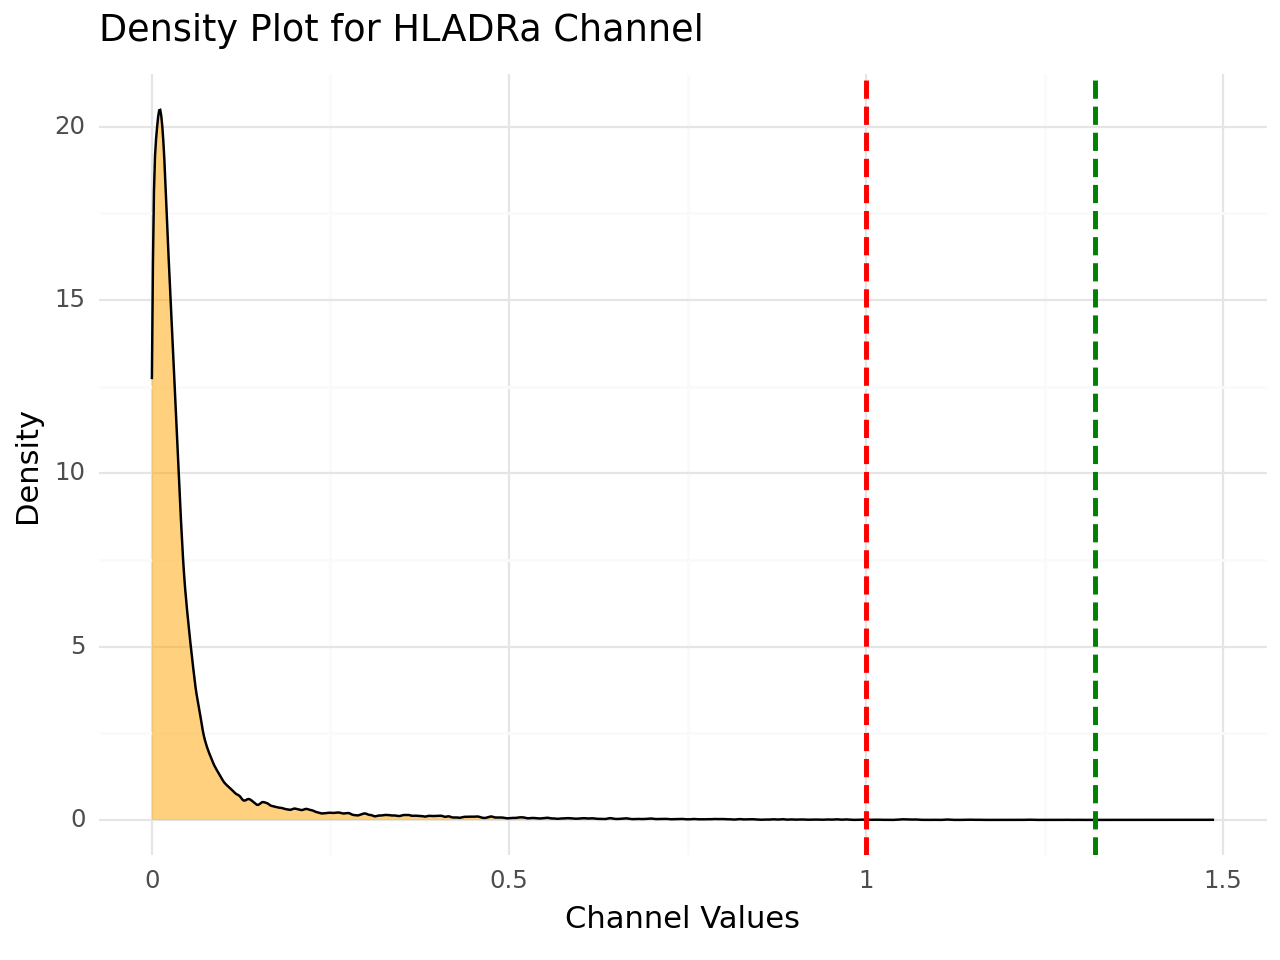

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_Ki67.png


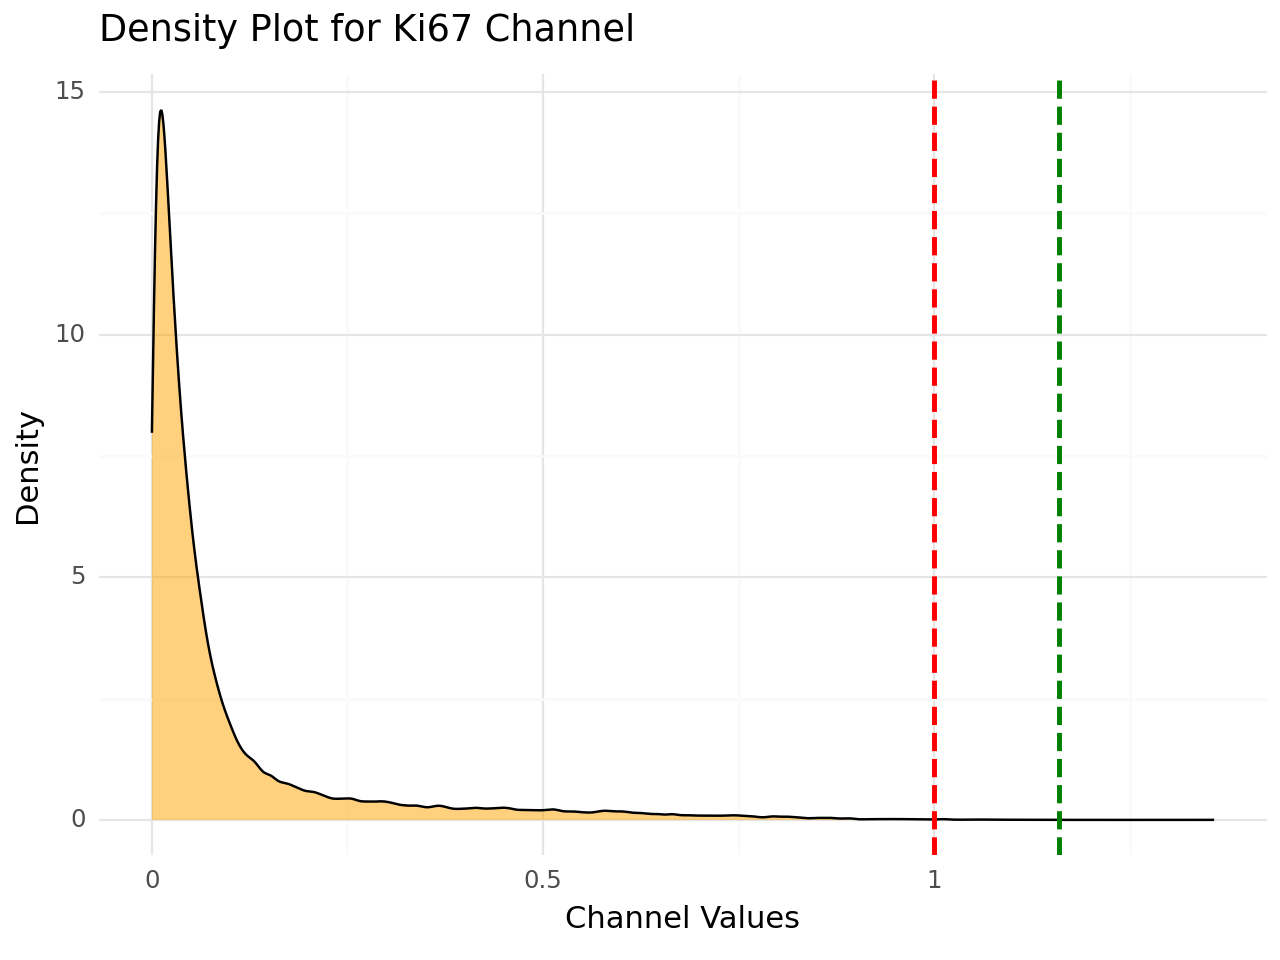

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_LDH.png


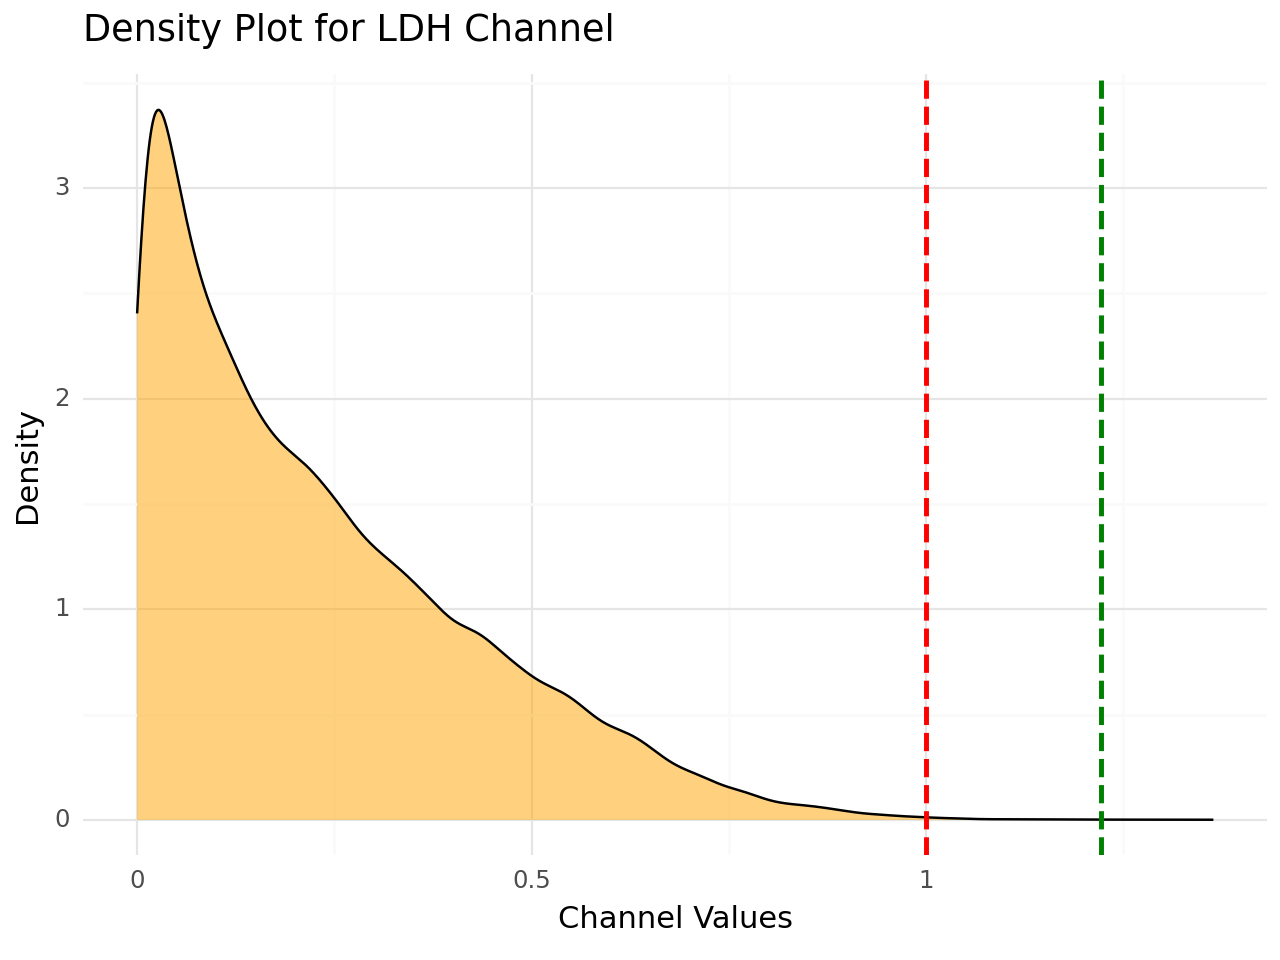

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_MCT1.png


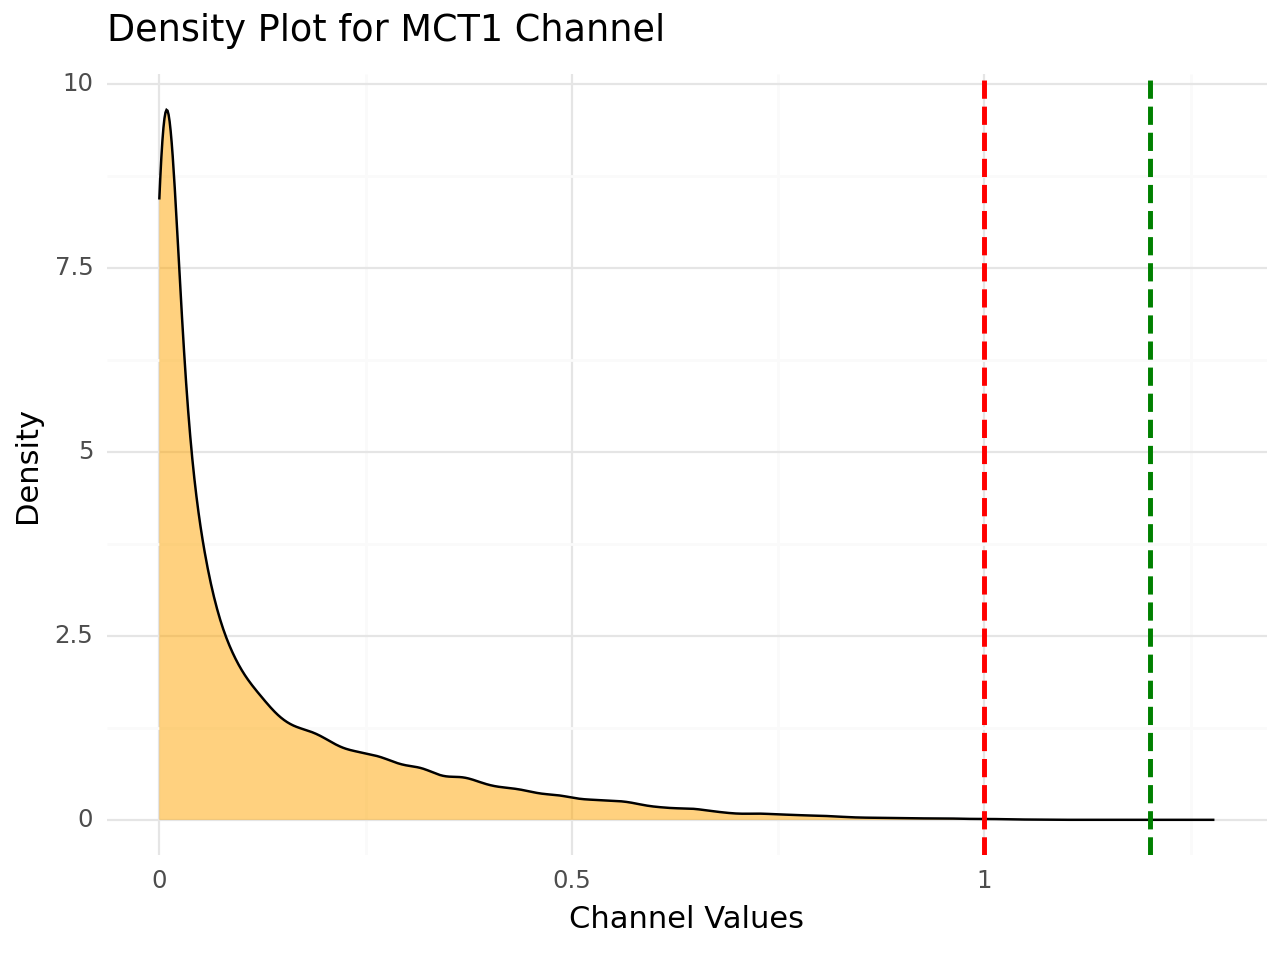

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_PDL1.png


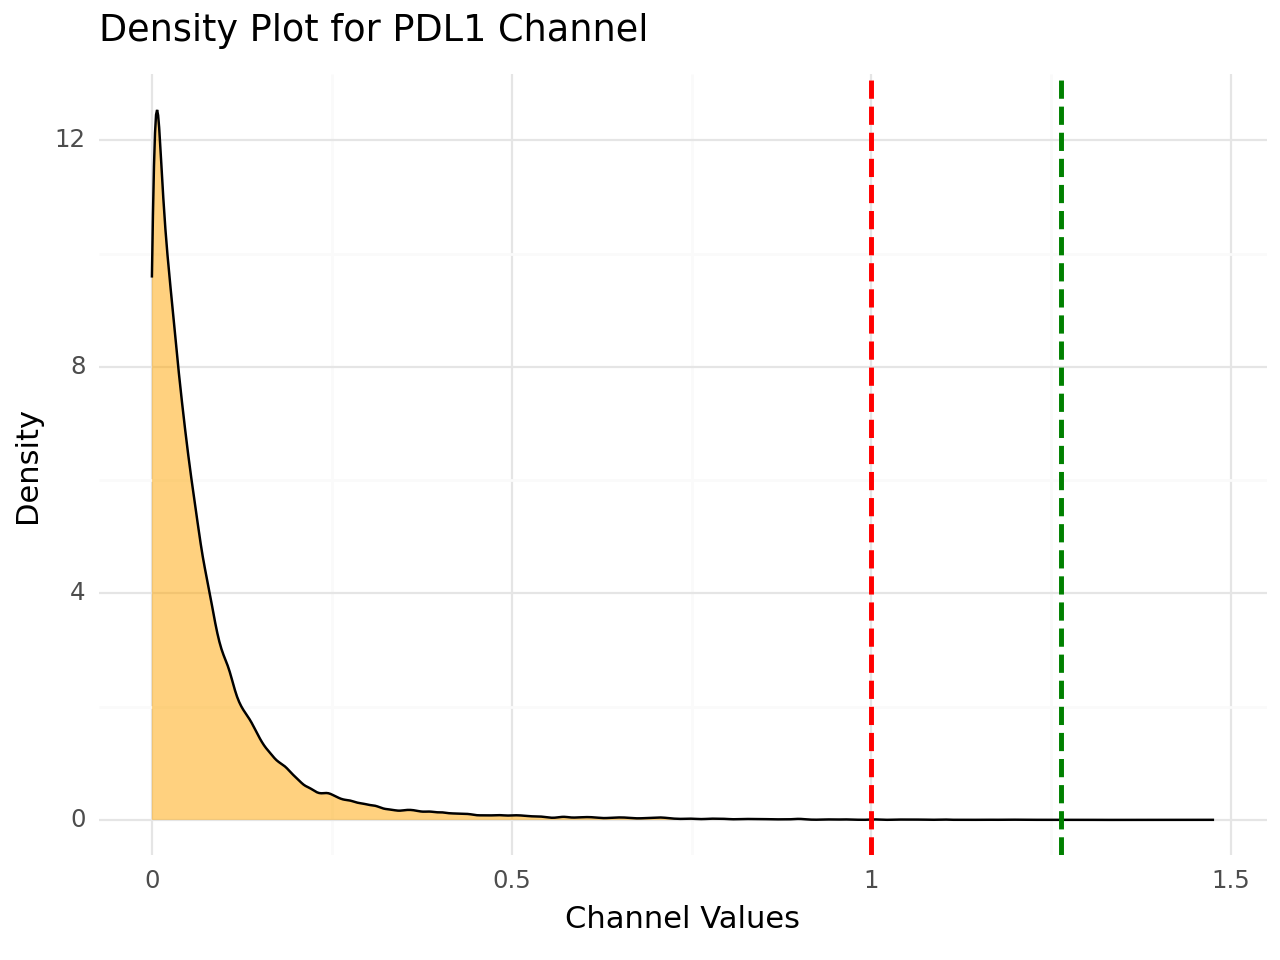

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_PD1.png


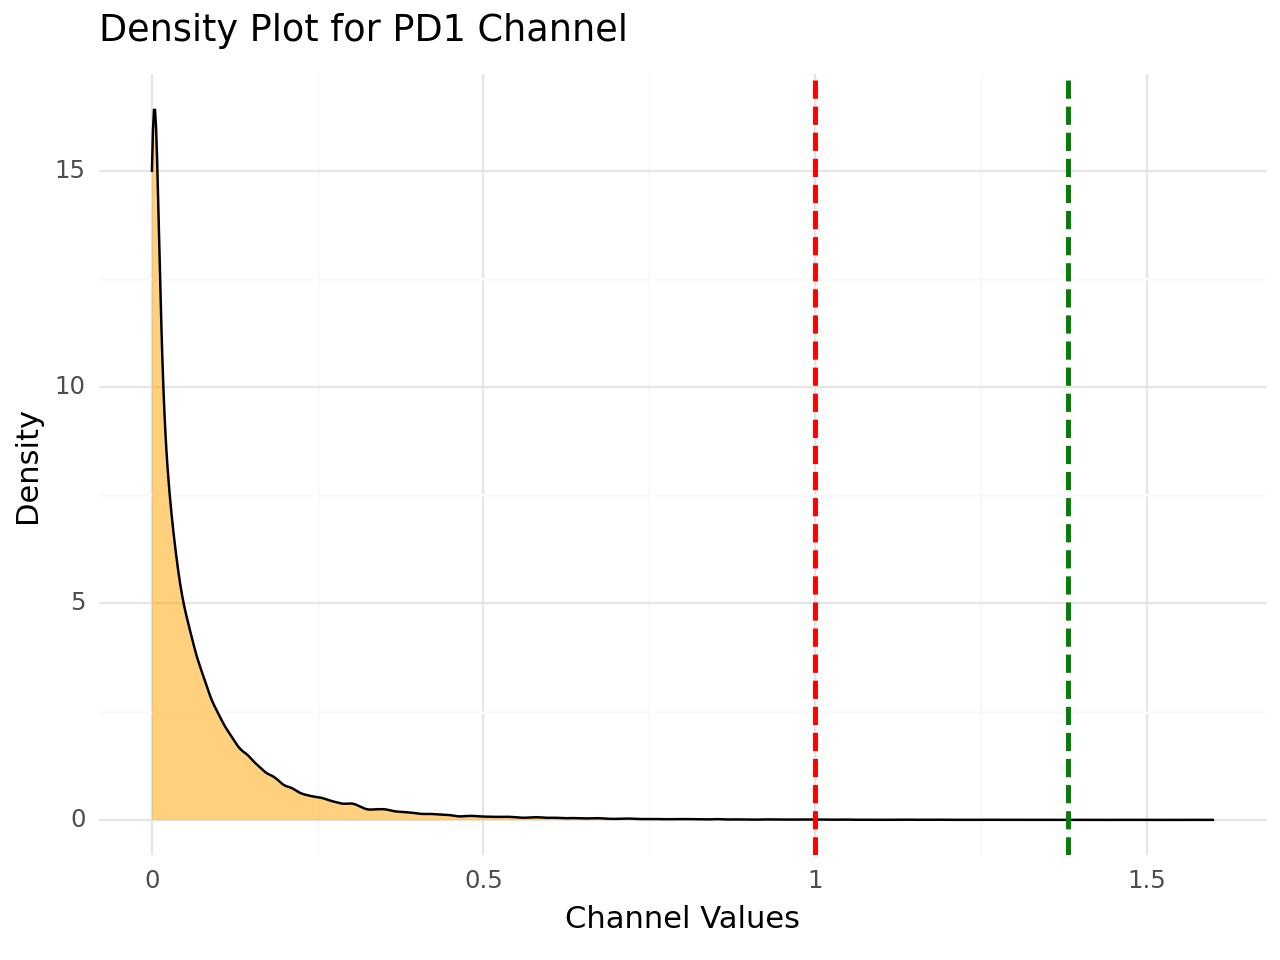

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_PKM2.png


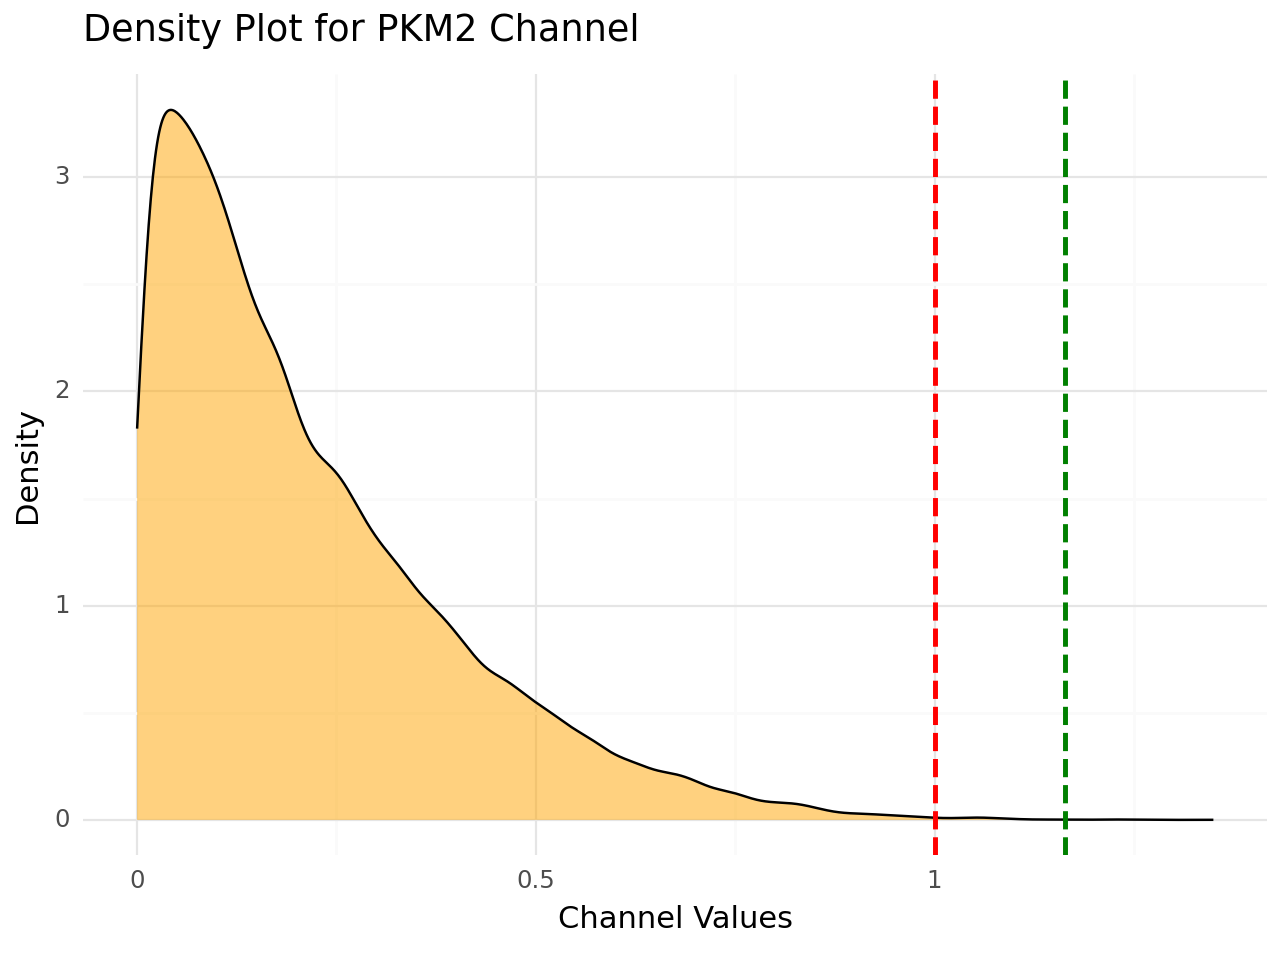

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_PanCK.png


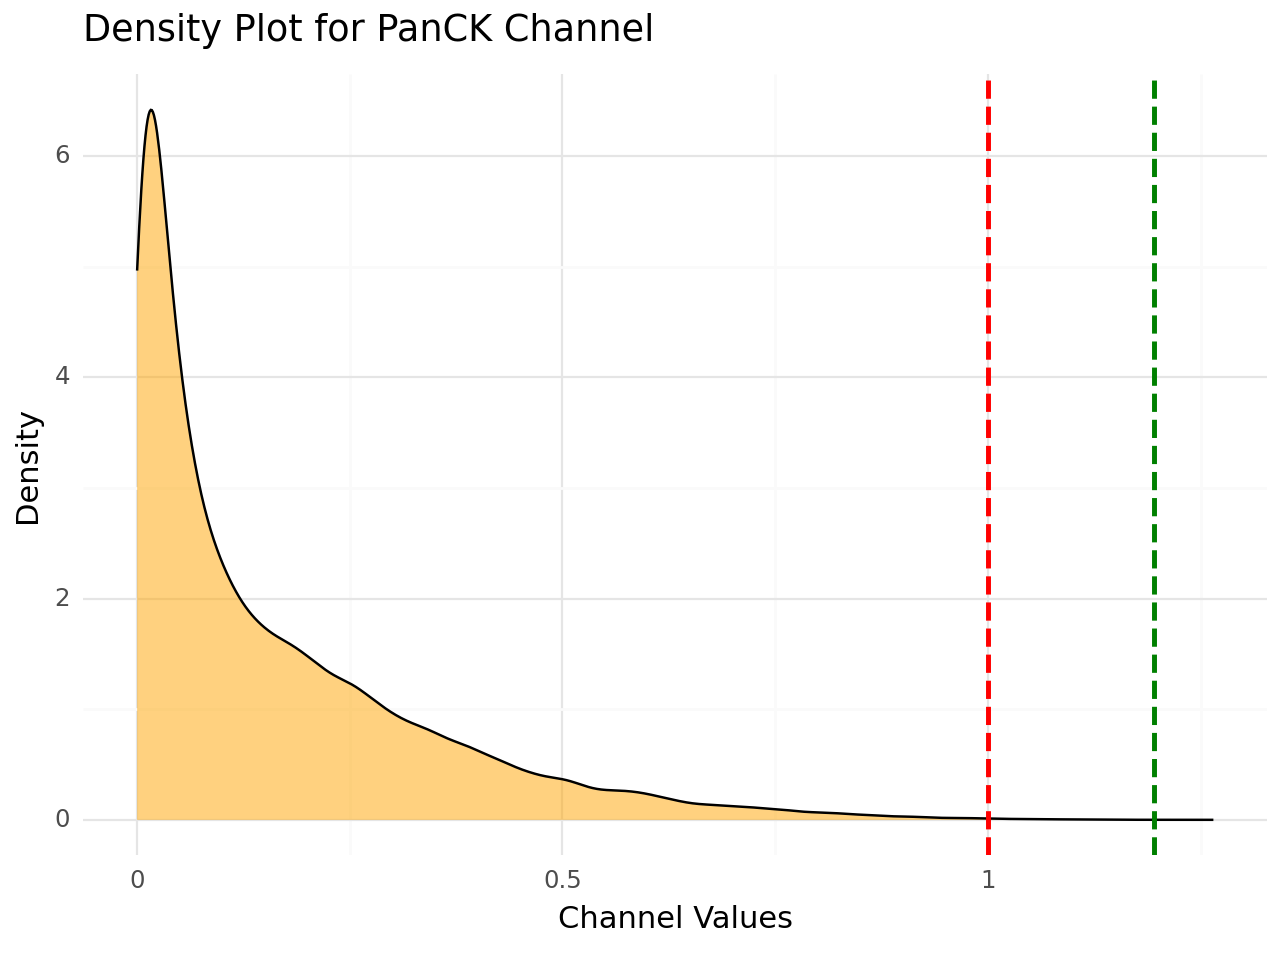

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_SMA.png


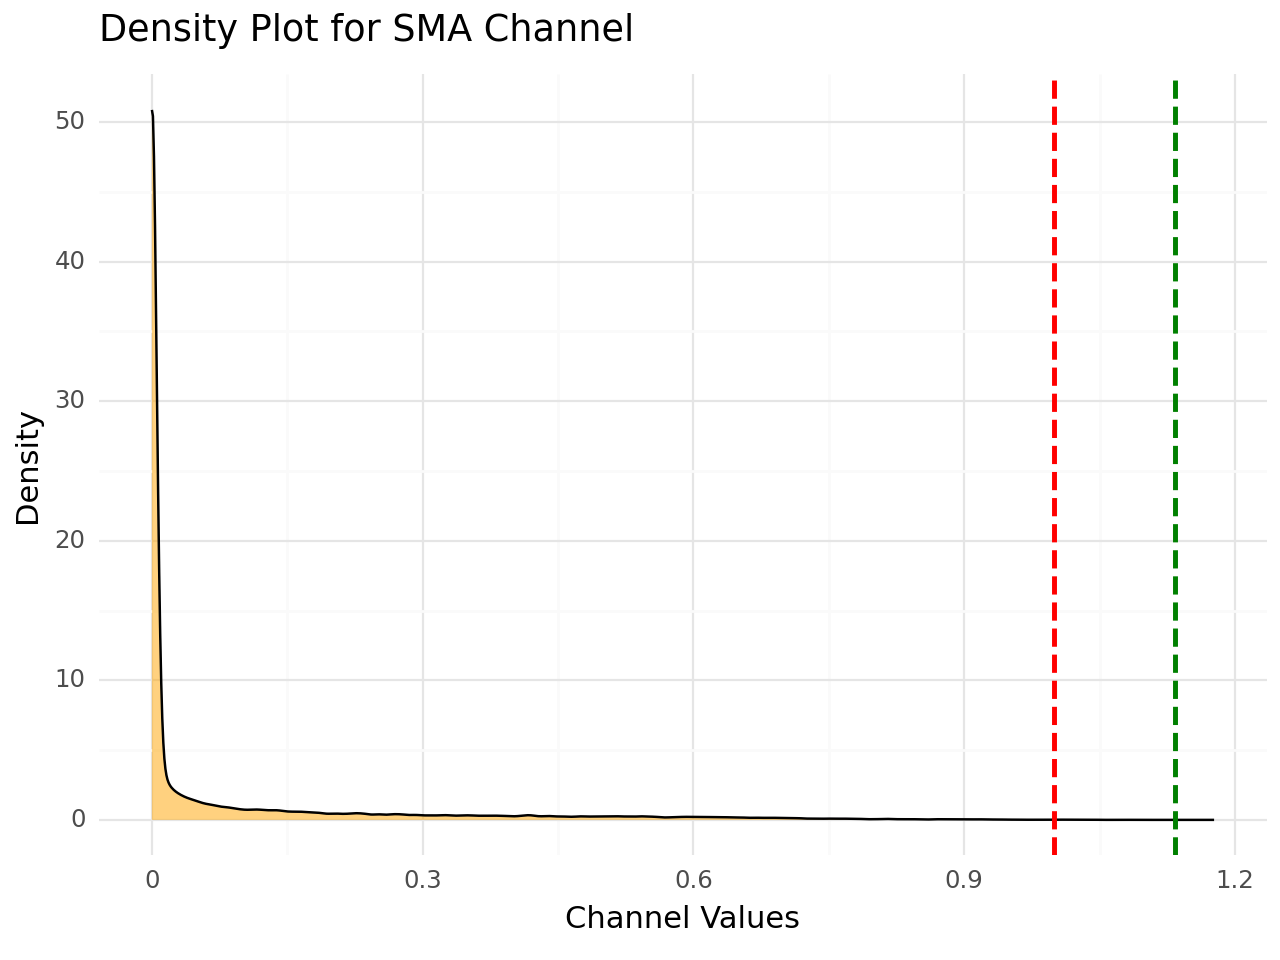

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./ProcessAll/preprocessing_figures/transformed/density_plot_Vimentin.png


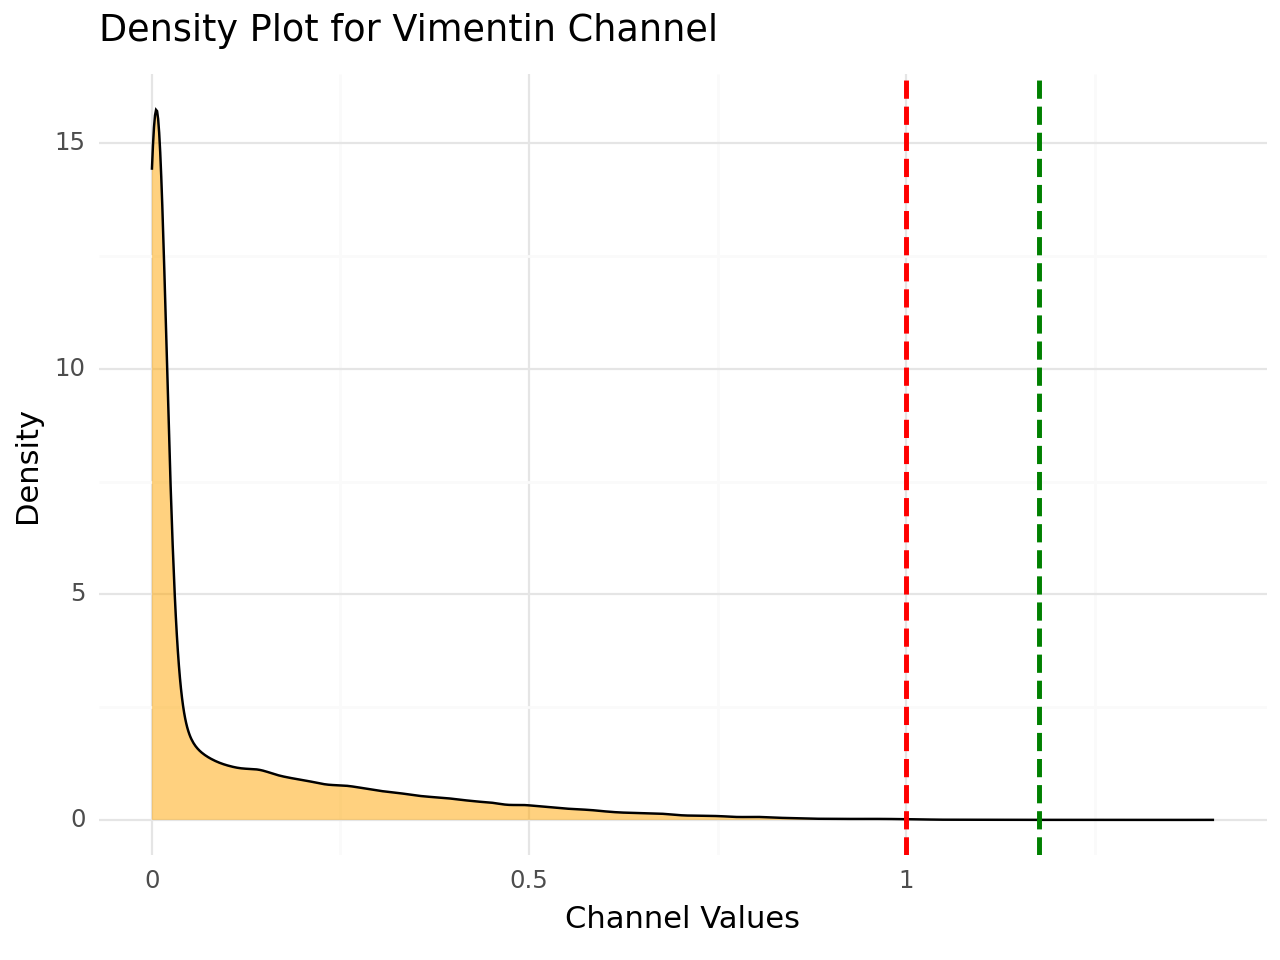

In [19]:
# Create output directory if it doesn't exist
transformed_dir = os.path.join(preprocess_dir, "transformed")
if not os.path.exists(transformed_dir):
    os.makedirs(transformed_dir)

# We represent up to 50000 cells on the density plot
cell_subtable = cell_table.sample(min(cell_table.shape[0], 50000))

# Iterate over each channel and create a density plot
for channel in channels:
    cytof_99_9 = np.percentile(cell_table[channel], 99.9)
    cytof_99_99 = np.percentile(cell_table[channel], 99.99)
    
    plot = (
        ggplot(cell_subtable, aes(x=channel)) 
        + geom_density(fill='orange', alpha=0.5)
        + geom_vline(aes(xintercept=cytof_99_9), color='red', linetype='--', size=1)
        + geom_vline(aes(xintercept=cytof_99_99), color='green', linetype='--', size=1)
        + labs(x='Channel Values', y='Density', title=f'Density Plot for {channel} Channel')
        + theme_minimal()
    )
    
    # Save the image
    save_path = os.path.join(transformed_dir, f'density_plot_{channel}.png')
    ggsave(plot, save_path)

    # Print the plot
    print(plot)

In [20]:
# Export transformed data
cell_table.to_csv(os.path.join(preprocess_dir, "cell_table_transformed.csv"))